In [9]:
from liblinear.liblinearutil import *
from itertools import combinations_with_replacement
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from tqdm import tqdm


# Dataset

- `mnist.scale` for training
- `mnist.scale.t` for testing


In [10]:
train_data = 'mnist.scale'
test_data = 'mnist.scale.t'

## Read and save data

The training data is saved in the `X_train` list, with each element being a dictionary of features.
example format: {153: 0.0117647, 154: 0.0705882, 155: 0.0705882, ...}

The corresponding label list is saved in `y_train`.

Similarily, the testing data is saved in `X_test` and the corresponding label list is saved in `y_test`.

In [11]:
def read_linear_format(file_path):
    X, y = [], []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if parts[0] == '2' or parts[0] == '6':
                y.append(int(parts[0]))  
                features = {}
                for item in parts[1:]:
                    index, value = item.split(":")
                    features[int(index)] = float(value)
                X.append(features)
    return X, y

X_train, y_train = read_linear_format(train_data)
X_test, y_test = read_linear_format(test_data)


### Example of the saved data format

- Note: This example has not done selecting out the class 2 and 6 examples.

In [12]:
X = []
with open(train_data, 'r') as f:
    for line in f:
        print("original line:", line)
        parts = line.strip().split()
        print("parts after stripping:", parts)
        features = {}
        for item in parts[1:]:
            index, value = item.split(":")
            features[int(index)] = float(value)
        X.append(features)
        break
        
print("X after first line processed:", X)


original line: 5 153:0.0117647 154:0.0705882 155:0.0705882 156:0.0705882 157:0.494118 158:0.533333 159:0.686275 160:0.101961 161:0.65098 162:1 163:0.968627 164:0.498039 177:0.117647 178:0.141176 179:0.368627 180:0.603922 181:0.666667 182:0.992157 183:0.992157 184:0.992157 185:0.992157 186:0.992157 187:0.882353 188:0.67451 189:0.992157 190:0.94902 191:0.764706 192:0.25098 204:0.192157 205:0.933333 206:0.992157 207:0.992157 208:0.992157 209:0.992157 210:0.992157 211:0.992157 212:0.992157 213:0.992157 214:0.984314 215:0.364706 216:0.321569 217:0.321569 218:0.219608 219:0.152941 232:0.0705882 233:0.858824 234:0.992157 235:0.992157 236:0.992157 237:0.992157 238:0.992157 239:0.776471 240:0.713725 241:0.968627 242:0.945098 261:0.313725 262:0.611765 263:0.419608 264:0.992157 265:0.992157 266:0.803922 267:0.0431373 269:0.168627 270:0.603922 290:0.054902 291:0.00392157 292:0.603922 293:0.992157 294:0.352941 320:0.545098 321:0.992157 322:0.745098 323:0.00784314 348:0.0431373 349:0.745098 350:0.99

## $0/1$ error

In [13]:
def ZeroOneError(predictions, y):
    return sum(p_i != y_i for p_i, y_i in zip(predictions, y)) / len(predictions)

# Regularized logistic regression

## Original Formulation in README.md

As the explanation in the liblinear README file, for <u>L1-regularized logistic regression</u> `(-s 6)`, we solve

\begin{equation} \tag{$\star$}
\min_{\vec{w}} \sum |w_j| + C \sum \log(1 + \exp(-y_i \vec{w}^T\vec{x}_i))
\end{equation}

### Components of this equation

In this equation, the <u>L1 regularizer</u> is defined as:

\begin{equation*}
\Omega(\vec{w}) = \sum |w_j| = ||\vec{w}||_1
\end{equation*}
> info in Lec14 slide 18

- Note: using L1 regularization encourages sparsity, which means fewer parameters.

And the <u>in-sample error</u> for logistic regression is:

\begin{equation*}
E_{in}(\vec{w}) = \frac{1}{N}\sum \log(1 + \exp(-y_i \vec{w}^T\vec{x}_i))
\end{equation*}
> in textbook p.91

## Derivation of $C$

Since we knew that:

\begin{equation*}
E_{aug}(\vec{w}) = E_{in}(\vec{w}) + \frac{\lambda}{N} \Omega(\vec{w})
\end{equation*}

We can derive that:

\begin{equation*}
E_{aug}(\vec{w}) = E_{in}(\vec{w}) + \frac{\lambda}{N}\sum |w_j|
\end{equation*}

For minimization:

\begin{equation*}
\begin{split}
\argmin_{\vec{w}} E_{aug}(\vec{w}) 
&= \argmin_{\vec{w}} (E_{in}(\vec{w}) + \frac{\lambda}{N}\sum |w_j|) \\
&= \argmin_{\vec{w}} \frac{N}{\lambda}(\frac{1}{N}\sum \log(1 + \exp(-y_i \vec{w}^T\vec{x}_i)) + \frac{\lambda}{N}\sum |w_j|) \\
&= \argmin_{\vec{w}} \frac{1}{\lambda}\sum \log(1 + \exp(-y_i \vec{w}^T\vec{x}_i)) + \sum |w_j|
\end{split}
\end{equation*}

Compare to the original equation marked with ($\star$), we can see that:

\begin{equation*}
C = \frac{1}{\lambda}
\end{equation*}



## Select the best $\lambda^*$

Selecting optimal $\lambda^*$ using the following equation:

\begin{equation*}
\lambda^* = \argmin_{\log_{10}(\lambda) \in \{-2, -1, 0, 1, 2, 3\}} E_{in}(\vec{w}_{\lambda})
\end{equation*}



# Randomly split data

In this problem, we're asked to randomly split the training data into 2 sets:
- subtraining set (8000)
- validation set (rest)

In [21]:
Eouts = []

for experiment in tqdm(range(1126)):

    np.random.seed(experiment)
    
    total_size = len(X_train)
    indices = np.random.permutation(total_size)
    
    subtrain_indices = indices[:8000]
    validation_indices = indices[8000:]
    
    X_subtrain = [X_train[i] for i in subtrain_indices]
    X_validation = [X_train[i] for i in validation_indices]
    y_subtrain = [y_train[i] for i in subtrain_indices]
    y_validation = [y_train[i] for i in validation_indices]

    subtrain_prob = problem(y_subtrain, X_subtrain)

    min_validation_err = np.inf
    opt_log10_lambda = 0
    for log10_lambda in (-2, -1, 0, 1, 2, 3):
        subtrain_pred_res = []
        c = 1 / (10 ** log10_lambda)
        param = parameter('-s 6 -c ' + str(c))
        model_by_subtrain = train(subtrain_prob, param)

        validation_label, _, _ = predict(y_validation, X_validation, model_by_subtrain)
        validation_err = ZeroOneError(validation_label, y_validation)
        if validation_err == min_validation_err:
            opt_log10_lambda = max(opt_log10_lambda, log10_lambda)      # break tie by choosing the larger lambda
        elif validation_err < min_validation_err:
            min_validation_err = validation_err
            opt_log10_lambda = log10_lambda

    # rerun the model with the best lambda on the whole training set
    whole_train_prob = problem(y_train, X_train)
    param_with_opt_lambda = parameter('-s 6 -c ' + str(1 / (10 ** opt_log10_lambda)))
    whole_train_model = train(whole_train_prob, param_with_opt_lambda)

    test_label, _, _ = predict(y_test, X_test, whole_train_model)
    Eout = ZeroOneError(test_label, y_test)
    
    Eouts.append(Eout)

  0%|          | 0/1126 [00:00<?, ?it/s]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16564.890899
#nonzeros/#features = 558/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1991.924492
#nonzeros/#features = 484/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 376.148958
#nonzeros/#features = 337/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective valu

  0%|          | 1/1126 [00:04<1:27:15,  4.65s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18568.597790
#nonzeros/#features = 558/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2265.458146
#nonzeros/#features = 486/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.079147
#nonzeros/#features = 348/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

  0%|          | 2/1126 [00:08<1:14:25,  3.97s/it]

Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16929.229157
#nonzeros/#features = 554/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2028.192111
#nonzeros/#features = 493/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 386.728815
#nonzeros/#features = 347/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

  0%|          | 3/1126 [00:11<1:09:12,  3.70s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17975.835316
#nonzeros/#features = 557/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2213.388549
#nonzeros/#features = 488/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.347541
#nonzeros/#features = 354/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

  0%|          | 4/1126 [00:14<1:05:19,  3.49s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.485502
#nonzeros/#features = 388/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18448.783500
#nonzeros/#features = 555/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2365.610560
#nonzeros/#features = 498/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  0%|          | 5/1126 [00:17<1:03:15,  3.39s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32357.924220
#nonzeros/#features = 567/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17428.087175
#nonzeros/#features = 552/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2147.632798
#nonzeros/#features = 498/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

  1%|          | 6/1126 [00:20<1:00:59,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.683541
#nonzeros/#features = 381/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15437.896328
#nonzeros/#features = 550/724
Accuracy = 97.9102% (3795/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1988.027077
#nonzeros/#features = 501/724
Accuracy = 97.8586% (3793/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, 

  1%|          | 7/1126 [00:24<1:01:00,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 565.047925
#nonzeros/#features = 379/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19983.071793
#nonzeros/#features = 557/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2318.454235
#nonzeros/#features = 498/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

  1%|          | 8/1126 [00:27<1:02:18,  3.34s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16073.667339
#nonzeros/#features = 555/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2001.197241
#nonzeros/#features = 501/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 392.729433
#nonzeros/#features = 358/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

  1%|          | 9/1126 [00:30<1:01:50,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.673857
#nonzeros/#features = 373/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18158.103796
#nonzeros/#features = 553/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2223.545335
#nonzeros/#features = 491/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

  1%|          | 10/1126 [00:34<1:02:24,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.613527
#nonzeros/#features = 381/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18705.012258
#nonzeros/#features = 555/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2406.517090
#nonzeros/#features = 499/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  1%|          | 11/1126 [00:37<1:01:36,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3832.196757
#nonzeros/#features = 520/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19539.401560
#nonzeros/#features = 561/722
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2383.585035
#nonzeros/#features = 494/722
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

  1%|          | 12/1126 [00:40<1:00:59,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3676.058497
#nonzeros/#features = 506/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19267.988352
#nonzeros/#features = 549/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2343.134444
#nonzeros/#features = 498/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  1%|          | 13/1126 [00:44<1:00:16,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32003.080943
#nonzeros/#features = 566/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20909.106981
#nonzeros/#features = 556/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2456.832781
#nonzeros/#features = 492/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

  1%|          | 14/1126 [00:47<1:00:15,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 553.228354
#nonzeros/#features = 380/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18625.988067
#nonzeros/#features = 554/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2221.860457
#nonzeros/#features = 491/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  1%|▏         | 15/1126 [00:50<59:41,  3.22s/it]  

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.813196
#nonzeros/#features = 377/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18408.035942
#nonzeros/#features = 553/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2178.317935
#nonzeros/#features = 495/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  1%|▏         | 16/1126 [00:53<59:13,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.523054
#nonzeros/#features = 390/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17961.845946
#nonzeros/#features = 552/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2224.200872
#nonzeros/#features = 496/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  2%|▏         | 17/1126 [00:57<1:01:49,  3.34s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16601.051561
#nonzeros/#features = 549/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2014.288838
#nonzeros/#features = 498/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 384.272842
#nonzeros/#features = 343/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

  2%|▏         | 18/1126 [01:00<1:01:55,  3.35s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.193305
#nonzeros/#features = 389/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19311.653996
#nonzeros/#features = 557/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2336.569104
#nonzeros/#features = 490/724
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

  2%|▏         | 19/1126 [01:03<1:00:47,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.309029
#nonzeros/#features = 387/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18078.832139
#nonzeros/#features = 551/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2148.915642
#nonzeros/#features = 493/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  2%|▏         | 20/1126 [01:07<1:00:41,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3806.631118
#nonzeros/#features = 520/727
Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15032.836270
#nonzeros/#features = 555/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1875.450435
#nonzeros/#features = 485/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  2%|▏         | 21/1126 [01:10<1:00:21,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3669.476741
#nonzeros/#features = 510/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16518.426601
#nonzeros/#features = 556/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2007.561422
#nonzeros/#features = 493/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

  2%|▏         | 22/1126 [01:13<59:46,  3.25s/it]  

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3642.226593
#nonzeros/#features = 509/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16130.571378
#nonzeros/#features = 556/724
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1955.017317
#nonzeros/#features = 499/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  2%|▏         | 23/1126 [01:16<59:47,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.677794
#nonzeros/#features = 386/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20416.660451
#nonzeros/#features = 557/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2384.039885
#nonzeros/#features = 499/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

  2%|▏         | 24/1126 [01:19<59:29,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.002338
#nonzeros/#features = 379/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17514.993234
#nonzeros/#features = 555/724
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2136.467954
#nonzeros/#features = 491/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  2%|▏         | 25/1126 [01:23<58:48,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.992357
#nonzeros/#features = 380/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18351.349549
#nonzeros/#features = 542/722
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2156.220569
#nonzeros/#features = 487/722
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

  2%|▏         | 26/1126 [01:26<59:33,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 552.833267
#nonzeros/#features = 386/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16749.170423
#nonzeros/#features = 552/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1978.531174
#nonzeros/#features = 490/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  2%|▏         | 27/1126 [01:29<1:00:38,  3.31s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16385.671915
#nonzeros/#features = 542/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2037.337268
#nonzeros/#features = 488/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 366.270350
#nonzeros/#features = 344/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

  2%|▏         | 28/1126 [01:33<1:01:06,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3620.866080
#nonzeros/#features = 502/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19151.841072
#nonzeros/#features = 544/723
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2289.730158
#nonzeros/#features = 489/723
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  3%|▎         | 29/1126 [01:36<1:00:37,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.256875
#nonzeros/#features = 391/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18366.058230
#nonzeros/#features = 555/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2236.473155
#nonzeros/#features = 493/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

  3%|▎         | 30/1126 [01:39<1:00:50,  3.33s/it]

Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15455.917506
#nonzeros/#features = 559/727
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1912.844744
#nonzeros/#features = 489/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 376.881143
#nonzeros/#features = 364/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

  3%|▎         | 31/1126 [01:43<1:00:12,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.048342
#nonzeros/#features = 382/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18372.945712
#nonzeros/#features = 555/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2217.121786
#nonzeros/#features = 497/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, 

  3%|▎         | 32/1126 [01:46<1:00:14,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.327310
#nonzeros/#features = 386/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18557.805554
#nonzeros/#features = 560/723
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2197.404647
#nonzeros/#features = 485/723
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  3%|▎         | 33/1126 [01:49<1:00:02,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.041974
#nonzeros/#features = 390/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17043.386776
#nonzeros/#features = 555/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2091.101302
#nonzeros/#features = 499/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  3%|▎         | 34/1126 [01:53<59:54,  3.29s/it]  

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3635.507706
#nonzeros/#features = 507/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18664.415553
#nonzeros/#features = 555/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2234.221055
#nonzeros/#features = 492/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  3%|▎         | 35/1126 [01:56<59:38,  3.28s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15806.248117
#nonzeros/#features = 548/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1936.682960
#nonzeros/#features = 495/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 378.686037
#nonzeros/#features = 341/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

  3%|▎         | 36/1126 [01:59<59:25,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3629.456204
#nonzeros/#features = 511/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19940.650261
#nonzeros/#features = 552/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2364.227899
#nonzeros/#features = 494/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

  3%|▎         | 37/1126 [02:02<59:23,  3.27s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16533.491164
#nonzeros/#features = 555/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2218.625834
#nonzeros/#features = 498/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 384.374718
#nonzeros/#features = 351/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

  3%|▎         | 38/1126 [02:06<59:34,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.180623
#nonzeros/#features = 381/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19173.540649
#nonzeros/#features = 550/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2301.637086
#nonzeros/#features = 493/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

  3%|▎         | 39/1126 [02:09<59:15,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18741.251020
#nonzeros/#features = 555/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2289.103475
#nonzeros/#features = 493/723
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 407.291498
#nonzeros/#features = 361/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

  4%|▎         | 40/1126 [02:12<59:30,  3.29s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18692.120758
#nonzeros/#features = 551/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2216.727869
#nonzeros/#features = 502/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 400.917650
#nonzeros/#features = 344/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

  4%|▎         | 41/1126 [02:17<1:07:28,  3.73s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.872803
#nonzeros/#features = 382/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15703.330724
#nonzeros/#features = 557/724
Accuracy = 97.9102% (3795/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1978.621042
#nonzeros/#features = 489/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  4%|▎         | 42/1126 [02:20<1:04:23,  3.56s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3657.840720
#nonzeros/#features = 517/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15444.619537
#nonzeros/#features = 550/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1889.303576
#nonzeros/#features = 483/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  4%|▍         | 43/1126 [02:23<1:01:43,  3.42s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.685700
#nonzeros/#features = 384/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16357.810753
#nonzeros/#features = 550/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1966.061280
#nonzeros/#features = 481/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  4%|▍         | 44/1126 [02:26<1:00:02,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32389.793660
#nonzeros/#features = 566/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19532.209692
#nonzeros/#features = 553/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2364.648603
#nonzeros/#features = 501/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

  4%|▍         | 45/1126 [02:29<58:47,  3.26s/it]  

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.095535
#nonzeros/#features = 384/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17899.172306
#nonzeros/#features = 558/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2142.320177
#nonzeros/#features = 492/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  4%|▍         | 46/1126 [02:33<57:56,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.542930
#nonzeros/#features = 382/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17230.145400
#nonzeros/#features = 535/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2041.122881
#nonzeros/#features = 483/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  4%|▍         | 47/1126 [02:36<57:30,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.569510
#nonzeros/#features = 380/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17333.357409
#nonzeros/#features = 550/723
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2064.046857
#nonzeros/#features = 490/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  4%|▍         | 48/1126 [02:39<57:04,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.847896
#nonzeros/#features = 397/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18092.225575
#nonzeros/#features = 554/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2227.702678
#nonzeros/#features = 484/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
iter   7  #CD cycles 6

  4%|▍         | 49/1126 [02:42<56:53,  3.17s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.209198
#nonzeros/#features = 387/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17001.837076
#nonzeros/#features = 546/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2048.920208
#nonzeros/#features = 489/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  4%|▍         | 50/1126 [02:45<56:33,  3.15s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.419320
#nonzeros/#features = 384/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17644.641420
#nonzeros/#features = 548/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2131.942373
#nonzeros/#features = 485/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  5%|▍         | 51/1126 [02:48<56:09,  3.13s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 544.136340
#nonzeros/#features = 364/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18619.796343
#nonzeros/#features = 553/724
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2157.108307
#nonzeros/#features = 490/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

  5%|▍         | 52/1126 [02:51<55:57,  3.13s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3821.757929
#nonzeros/#features = 513/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17848.473470
#nonzeros/#features = 554/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2142.357764
#nonzeros/#features = 482/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  5%|▍         | 53/1126 [02:54<56:03,  3.13s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3667.762967
#nonzeros/#features = 516/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 16250.813606
#nonzeros/#features = 559/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1899.453013
#nonzeros/#features = 495/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  5%|▍         | 54/1126 [02:58<55:57,  3.13s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32768.497138
#nonzeros/#features = 567/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15849.077303
#nonzeros/#features = 552/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1972.991268
#nonzeros/#features = 491/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  5%|▍         | 55/1126 [03:01<55:21,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3847.354339
#nonzeros/#features = 519/727
Accuracy = 98.2412% (1955/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17680.557657
#nonzeros/#features = 550/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2161.702001
#nonzeros/#features = 489/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  5%|▍         | 56/1126 [03:04<55:14,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3782.749509
#nonzeros/#features = 503/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18949.024258
#nonzeros/#features = 555/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2257.435357
#nonzeros/#features = 499/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  5%|▌         | 57/1126 [03:07<55:27,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 565.423375
#nonzeros/#features = 393/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18430.247003
#nonzeros/#features = 555/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2207.817423
#nonzeros/#features = 490/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  5%|▌         | 58/1126 [03:10<55:41,  3.13s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21096.754394
#nonzeros/#features = 558/722
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2475.329834
#nonzeros/#features = 502/722
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 421.848870
#nonzeros/#features = 360/722
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

  5%|▌         | 59/1126 [03:13<55:10,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.750150
#nonzeros/#features = 394/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18015.202195
#nonzeros/#features = 561/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2352.691315
#nonzeros/#features = 495/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

  5%|▌         | 60/1126 [03:16<55:14,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.342432
#nonzeros/#features = 385/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15634.551160
#nonzeros/#features = 556/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2041.393185
#nonzeros/#features = 493/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  5%|▌         | 61/1126 [03:19<54:50,  3.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.524096
#nonzeros/#features = 384/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18809.831459
#nonzeros/#features = 552/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2259.601079
#nonzeros/#features = 494/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

  6%|▌         | 62/1126 [03:22<54:40,  3.08s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.025638
#nonzeros/#features = 388/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 21873.335771
#nonzeros/#features = 554/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2509.217850
#nonzeros/#features = 507/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  6%|▌         | 63/1126 [03:25<54:25,  3.07s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3902.986663
#nonzeros/#features = 515/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18874.467979
#nonzeros/#features = 554/724
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2287.864177
#nonzeros/#features = 506/724
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  6%|▌         | 64/1126 [03:28<54:35,  3.08s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.904654
#nonzeros/#features = 382/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16836.588258
#nonzeros/#features = 550/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2152.578553
#nonzeros/#features = 487/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  6%|▌         | 65/1126 [03:32<54:41,  3.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3633.628936
#nonzeros/#features = 506/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18875.171497
#nonzeros/#features = 543/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2211.404332
#nonzeros/#features = 488/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  6%|▌         | 66/1126 [03:35<55:00,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.352751
#nonzeros/#features = 399/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17675.328266
#nonzeros/#features = 551/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2150.462270
#nonzeros/#features = 495/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

  6%|▌         | 67/1126 [03:38<55:06,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15360.005327
#nonzeros/#features = 553/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1925.566761
#nonzeros/#features = 497/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 373.532357
#nonzeros/#features = 353/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

  6%|▌         | 68/1126 [03:41<54:40,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3820.844975
#nonzeros/#features = 508/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18939.937286
#nonzeros/#features = 556/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2183.050291
#nonzeros/#features = 488/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  6%|▌         | 69/1126 [03:44<54:37,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.551540
#nonzeros/#features = 376/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19891.438151
#nonzeros/#features = 548/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2379.816337
#nonzeros/#features = 499/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

  6%|▌         | 70/1126 [03:47<54:12,  3.08s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3820.797250
#nonzeros/#features = 521/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20232.312058
#nonzeros/#features = 561/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2402.384406
#nonzeros/#features = 500/724
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  6%|▋         | 71/1126 [03:50<54:19,  3.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.281498
#nonzeros/#features = 378/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19356.046996
#nonzeros/#features = 555/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2297.287290
#nonzeros/#features = 488/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  6%|▋         | 72/1126 [03:53<54:21,  3.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32608.245117
#nonzeros/#features = 563/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20541.007313
#nonzeros/#features = 559/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2337.181353
#nonzeros/#features = 494/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

  6%|▋         | 73/1126 [03:56<54:35,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3610.465538
#nonzeros/#features = 496/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19777.577507
#nonzeros/#features = 552/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2348.066136
#nonzeros/#features = 501/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  7%|▋         | 74/1126 [03:59<54:08,  3.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 553.690272
#nonzeros/#features = 385/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 16767.335064
#nonzeros/#features = 551/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2190.512900
#nonzeros/#features = 488/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1

  7%|▋         | 75/1126 [04:03<54:46,  3.13s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32911.487055
#nonzeros/#features = 569/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16671.481604
#nonzeros/#features = 556/724
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2051.149220
#nonzeros/#features = 496/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

  7%|▋         | 76/1126 [04:06<54:53,  3.14s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3775.280494
#nonzeros/#features = 510/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16666.484730
#nonzeros/#features = 549/724
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1998.945564
#nonzeros/#features = 492/724
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  7%|▋         | 77/1126 [04:09<54:51,  3.14s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18764.136144
#nonzeros/#features = 553/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2284.624436
#nonzeros/#features = 491/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 399.193334
#nonzeros/#features = 345/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

  7%|▋         | 78/1126 [04:12<54:44,  3.13s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3854.518332
#nonzeros/#features = 517/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19261.273987
#nonzeros/#features = 555/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2320.621079
#nonzeros/#features = 495/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  7%|▋         | 79/1126 [04:15<54:19,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.126161
#nonzeros/#features = 382/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17095.626446
#nonzeros/#features = 549/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2194.257033
#nonzeros/#features = 496/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  7%|▋         | 80/1126 [04:18<54:01,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3613.463706
#nonzeros/#features = 511/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20414.890824
#nonzeros/#features = 559/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2400.070086
#nonzeros/#features = 495/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  7%|▋         | 81/1126 [04:21<54:18,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.916218
#nonzeros/#features = 387/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14562.076494
#nonzeros/#features = 547/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1867.471187
#nonzeros/#features = 487/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  7%|▋         | 82/1126 [04:24<54:06,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3644.950745
#nonzeros/#features = 512/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19120.734098
#nonzeros/#features = 543/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2263.235251
#nonzeros/#features = 493/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished,

  7%|▋         | 83/1126 [04:28<54:05,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18328.973287
#nonzeros/#features = 555/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2119.022818
#nonzeros/#features = 489/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 393.635599
#nonzeros/#features = 346/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective valu

  7%|▋         | 84/1126 [04:31<54:01,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.268771
#nonzeros/#features = 382/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18947.981055
#nonzeros/#features = 565/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2279.629125
#nonzeros/#features = 496/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  8%|▊         | 85/1126 [04:34<53:52,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.859806
#nonzeros/#features = 387/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16127.487844
#nonzeros/#features = 553/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1986.075418
#nonzeros/#features = 494/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  8%|▊         | 86/1126 [04:37<53:27,  3.08s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3888.392000
#nonzeros/#features = 522/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18418.144558
#nonzeros/#features = 552/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2162.695767
#nonzeros/#features = 487/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  8%|▊         | 87/1126 [04:40<53:48,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.877964
#nonzeros/#features = 388/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18250.604860
#nonzeros/#features = 551/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2152.968527
#nonzeros/#features = 487/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  8%|▊         | 88/1126 [04:43<53:34,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3582.878500
#nonzeros/#features = 508/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 17500.352981
#nonzeros/#features = 552/724
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1926.880880
#nonzeros/#features = 486/724
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  8%|▊         | 89/1126 [04:46<53:40,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3662.975336
#nonzeros/#features = 508/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18968.530064
#nonzeros/#features = 545/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2237.702648
#nonzeros/#features = 484/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  8%|▊         | 90/1126 [04:49<53:46,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3818.717218
#nonzeros/#features = 515/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17701.202648
#nonzeros/#features = 553/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2181.812069
#nonzeros/#features = 491/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

  8%|▊         | 91/1126 [04:53<54:01,  3.13s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.835738
#nonzeros/#features = 386/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20389.138098
#nonzeros/#features = 561/723
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2446.192924
#nonzeros/#features = 494/723
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

  8%|▊         | 92/1126 [04:56<53:37,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.889381
#nonzeros/#features = 389/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19636.828424
#nonzeros/#features = 555/727
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2300.078729
#nonzeros/#features = 491/727
Accuracy = 98.8906% (3833/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

  8%|▊         | 93/1126 [04:59<53:40,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3600.080748
#nonzeros/#features = 504/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16784.829758
#nonzeros/#features = 551/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1995.385064
#nonzeros/#features = 487/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

  8%|▊         | 94/1126 [05:02<53:20,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3651.440636
#nonzeros/#features = 515/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17734.421609
#nonzeros/#features = 558/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2159.026509
#nonzeros/#features = 495/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  8%|▊         | 95/1126 [05:05<53:04,  3.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3682.121230
#nonzeros/#features = 505/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15781.446595
#nonzeros/#features = 556/723
Accuracy = 97.8586% (3793/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1903.614008
#nonzeros/#features = 483/723
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  9%|▊         | 96/1126 [05:08<53:00,  3.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3670.110494
#nonzeros/#features = 505/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17146.238041
#nonzeros/#features = 547/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2120.335645
#nonzeros/#features = 489/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  9%|▊         | 97/1126 [05:11<52:54,  3.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3638.331641
#nonzeros/#features = 513/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20331.229924
#nonzeros/#features = 551/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2354.573288
#nonzeros/#features = 493/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  9%|▊         | 98/1126 [05:14<52:43,  3.08s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3558.014397
#nonzeros/#features = 504/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19304.950192
#nonzeros/#features = 563/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2339.112903
#nonzeros/#features = 490/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
iter   7  #CD cycles 7

  9%|▉         | 99/1126 [05:17<53:53,  3.15s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 552.478913
#nonzeros/#features = 380/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19614.367608
#nonzeros/#features = 554/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2320.624381
#nonzeros/#features = 491/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #

  9%|▉         | 100/1126 [05:20<53:43,  3.14s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3677.504745
#nonzeros/#features = 510/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18014.263996
#nonzeros/#features = 553/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2115.449699
#nonzeros/#features = 488/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  9%|▉         | 101/1126 [05:24<53:33,  3.14s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32423.639285
#nonzeros/#features = 568/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16523.813962
#nonzeros/#features = 556/722
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2027.905046
#nonzeros/#features = 501/722
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

  9%|▉         | 102/1126 [05:27<53:17,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32606.899478
#nonzeros/#features = 567/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17037.821281
#nonzeros/#features = 560/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2076.676936
#nonzeros/#features = 511/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

  9%|▉         | 103/1126 [05:30<53:01,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.065939
#nonzeros/#features = 381/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18153.243774
#nonzeros/#features = 557/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2215.315206
#nonzeros/#features = 487/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

  9%|▉         | 104/1126 [05:33<52:40,  3.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.454999
#nonzeros/#features = 380/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18504.510799
#nonzeros/#features = 551/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2124.494454
#nonzeros/#features = 484/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

  9%|▉         | 105/1126 [05:36<53:02,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.524449
#nonzeros/#features = 382/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19051.659757
#nonzeros/#features = 545/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2223.704433
#nonzeros/#features = 495/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

  9%|▉         | 106/1126 [05:39<53:00,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 33163.289825
#nonzeros/#features = 567/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18751.443605
#nonzeros/#features = 560/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2247.781586
#nonzeros/#features = 495/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 10%|▉         | 107/1126 [05:42<52:55,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.626745
#nonzeros/#features = 389/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19050.488327
#nonzeros/#features = 552/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2287.121006
#nonzeros/#features = 486/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 10%|▉         | 108/1126 [05:45<52:55,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32319.105662
#nonzeros/#features = 573/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17886.577734
#nonzeros/#features = 550/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2199.094705
#nonzeros/#features = 495/723
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 10%|▉         | 109/1126 [05:49<53:06,  3.13s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.638366
#nonzeros/#features = 377/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17527.132892
#nonzeros/#features = 548/727
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2140.266749
#nonzeros/#features = 488/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 10%|▉         | 110/1126 [05:52<52:38,  3.11s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17123.747027
#nonzeros/#features = 553/727
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2119.054324
#nonzeros/#features = 491/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 390.609927
#nonzeros/#features = 350/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 10%|▉         | 111/1126 [05:55<52:49,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3639.988619
#nonzeros/#features = 517/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18711.669742
#nonzeros/#features = 547/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2290.404436
#nonzeros/#features = 497/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 10%|▉         | 112/1126 [05:58<53:23,  3.16s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 35434.123539
#nonzeros/#features = 569/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18406.630434
#nonzeros/#features = 557/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2243.951984
#nonzeros/#features = 497/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 10%|█         | 113/1126 [06:01<52:49,  3.13s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3622.765819
#nonzeros/#features = 503/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15421.693053
#nonzeros/#features = 556/723
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1947.901859
#nonzeros/#features = 485/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 10%|█         | 114/1126 [06:04<52:33,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.073197
#nonzeros/#features = 371/727
Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19840.166216
#nonzeros/#features = 555/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2308.752250
#nonzeros/#features = 494/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 10%|█         | 115/1126 [06:07<52:12,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3630.163735
#nonzeros/#features = 508/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20458.605058
#nonzeros/#features = 546/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2394.873138
#nonzeros/#features = 492/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 10%|█         | 116/1126 [06:10<51:58,  3.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3654.526138
#nonzeros/#features = 508/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19276.592611
#nonzeros/#features = 554/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2296.530873
#nonzeros/#features = 497/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 10%|█         | 117/1126 [06:13<52:02,  3.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3623.431028
#nonzeros/#features = 509/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17549.024848
#nonzeros/#features = 557/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2216.313263
#nonzeros/#features = 490/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 10%|█         | 118/1126 [06:16<52:14,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3643.533052
#nonzeros/#features = 510/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18926.512361
#nonzeros/#features = 551/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2201.405131
#nonzeros/#features = 492/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished

 11%|█         | 119/1126 [06:20<52:07,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32332.070339
#nonzeros/#features = 572/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18401.342992
#nonzeros/#features = 547/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2285.125116
#nonzeros/#features = 498/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

 11%|█         | 120/1126 [06:23<52:11,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.856762
#nonzeros/#features = 390/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16280.365856
#nonzeros/#features = 557/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1937.090987
#nonzeros/#features = 486/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 11%|█         | 121/1126 [06:26<52:12,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 567.167181
#nonzeros/#features = 392/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17278.240223
#nonzeros/#features = 547/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2101.575766
#nonzeros/#features = 488/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 11%|█         | 122/1126 [06:29<52:04,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3647.934217
#nonzeros/#features = 515/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20713.278138
#nonzeros/#features = 552/727
Accuracy = 98.8648% (3832/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2415.895792
#nonzeros/#features = 492/727
Accuracy = 98.968% (3836/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 11%|█         | 123/1126 [06:32<52:02,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.832040
#nonzeros/#features = 386/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17705.567274
#nonzeros/#features = 553/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2260.055084
#nonzeros/#features = 500/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 11%|█         | 124/1126 [06:35<52:01,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3638.723566
#nonzeros/#features = 512/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19375.137335
#nonzeros/#features = 560/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2306.995422
#nonzeros/#features = 494/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 11%|█         | 125/1126 [06:38<51:47,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3643.464046
#nonzeros/#features = 507/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18407.900718
#nonzeros/#features = 550/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2231.338886
#nonzeros/#features = 482/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 11%|█         | 126/1126 [06:41<51:49,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.262151
#nonzeros/#features = 395/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18090.384404
#nonzeros/#features = 559/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2146.736891
#nonzeros/#features = 486/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 11%|█▏        | 127/1126 [06:45<51:49,  3.11s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3612.188480
#nonzeros/#features = 505/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17912.125921
#nonzeros/#features = 552/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2102.076890
#nonzeros/#features = 486/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 11%|█▏        | 128/1126 [06:48<52:04,  3.13s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3611.360424
#nonzeros/#features = 512/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19203.136248
#nonzeros/#features = 541/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2378.695823
#nonzeros/#features = 495/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 11%|█▏        | 129/1126 [06:51<51:34,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.070325
#nonzeros/#features = 379/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18248.743181
#nonzeros/#features = 550/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2194.369129
#nonzeros/#features = 487/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 12%|█▏        | 130/1126 [06:54<52:05,  3.14s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3584.409077
#nonzeros/#features = 518/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17739.238024
#nonzeros/#features = 558/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2147.251588
#nonzeros/#features = 501/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 12%|█▏        | 131/1126 [06:57<51:56,  3.13s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 567.293070
#nonzeros/#features = 394/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 20321.768073
#nonzeros/#features = 564/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2213.641669
#nonzeros/#features = 489/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 12%|█▏        | 132/1126 [07:00<51:43,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3653.122878
#nonzeros/#features = 508/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19138.602058
#nonzeros/#features = 560/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2262.673915
#nonzeros/#features = 498/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 12%|█▏        | 133/1126 [07:03<51:37,  3.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3608.697158
#nonzeros/#features = 507/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19185.924167
#nonzeros/#features = 557/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2254.334087
#nonzeros/#features = 486/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 12%|█▏        | 134/1126 [07:06<51:45,  3.13s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.505207
#nonzeros/#features = 383/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18055.501251
#nonzeros/#features = 555/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2263.302066
#nonzeros/#features = 490/724
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 12%|█▏        | 135/1126 [07:09<51:07,  3.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.065398
#nonzeros/#features = 389/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18707.086277
#nonzeros/#features = 551/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2201.648845
#nonzeros/#features = 487/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 12%|█▏        | 136/1126 [07:13<52:31,  3.18s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20427.572197
#nonzeros/#features = 555/727
Accuracy = 98.9164% (3834/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2471.561280
#nonzeros/#features = 498/727
Accuracy = 98.839% (3831/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 419.372837
#nonzeros/#features = 360/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 12%|█▏        | 137/1126 [07:16<53:02,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32837.029082
#nonzeros/#features = 571/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18113.378932
#nonzeros/#features = 545/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2131.069100
#nonzeros/#features = 489/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 12%|█▏        | 138/1126 [07:19<53:19,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.156713
#nonzeros/#features = 378/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17977.090062
#nonzeros/#features = 559/727
Accuracy = 98.8648% (3832/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2162.630850
#nonzeros/#features = 492/727
Accuracy = 98.8648% (3832/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 12%|█▏        | 139/1126 [07:23<54:15,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3843.147420
#nonzeros/#features = 518/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19630.762418
#nonzeros/#features = 548/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2333.599700
#nonzeros/#features = 486/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 12%|█▏        | 140/1126 [07:26<53:33,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.632154
#nonzeros/#features = 385/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18953.200426
#nonzeros/#features = 549/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2302.224052
#nonzeros/#features = 490/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 13%|█▎        | 141/1126 [07:29<52:42,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.479253
#nonzeros/#features = 390/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18745.136212
#nonzeros/#features = 551/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2291.819042
#nonzeros/#features = 494/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 13%|█▎        | 142/1126 [07:32<52:23,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.301153
#nonzeros/#features = 383/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19195.384527
#nonzeros/#features = 556/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2262.198580
#nonzeros/#features = 486/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 13%|█▎        | 143/1126 [07:35<52:25,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.037526
#nonzeros/#features = 388/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18974.699934
#nonzeros/#features = 549/723
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2263.962042
#nonzeros/#features = 483/723
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 13%|█▎        | 144/1126 [07:39<52:38,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.910845
#nonzeros/#features = 391/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18412.761750
#nonzeros/#features = 547/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2244.406117
#nonzeros/#features = 494/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

 13%|█▎        | 145/1126 [07:42<52:29,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.938416
#nonzeros/#features = 387/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18455.948767
#nonzeros/#features = 561/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2248.484209
#nonzeros/#features = 501/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 13%|█▎        | 146/1126 [07:45<52:31,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.675307
#nonzeros/#features = 395/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18604.725741
#nonzeros/#features = 556/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2254.045624
#nonzeros/#features = 493/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 13%|█▎        | 147/1126 [07:48<51:38,  3.16s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.622171
#nonzeros/#features = 381/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17176.691470
#nonzeros/#features = 555/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2063.277244
#nonzeros/#features = 486/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 13%|█▎        | 148/1126 [07:51<51:42,  3.17s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3559.027371
#nonzeros/#features = 499/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19649.602861
#nonzeros/#features = 554/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2294.566062
#nonzeros/#features = 489/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 13%|█▎        | 149/1126 [07:55<52:04,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.365604
#nonzeros/#features = 389/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15468.292834
#nonzeros/#features = 562/724
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1899.037956
#nonzeros/#features = 489/724
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 13%|█▎        | 150/1126 [07:58<52:04,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 553.997405
#nonzeros/#features = 387/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18978.689409
#nonzeros/#features = 554/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2230.517954
#nonzeros/#features = 495/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 13%|█▎        | 151/1126 [08:01<52:32,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.091960
#nonzeros/#features = 389/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18148.840255
#nonzeros/#features = 555/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2182.649537
#nonzeros/#features = 496/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 13%|█▎        | 152/1126 [08:04<52:32,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3688.610092
#nonzeros/#features = 514/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18822.498837
#nonzeros/#features = 561/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2270.192517
#nonzeros/#features = 501/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 14%|█▎        | 153/1126 [08:08<52:09,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20125.452406
#nonzeros/#features = 554/723
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2363.733350
#nonzeros/#features = 499/723
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 410.123594
#nonzeros/#features = 350/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 14%|█▎        | 154/1126 [08:11<52:04,  3.21s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17155.454303
#nonzeros/#features = 554/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2012.628322
#nonzeros/#features = 490/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 386.927210
#nonzeros/#features = 357/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 14%|█▍        | 155/1126 [08:14<52:48,  3.26s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18793.652636
#nonzeros/#features = 563/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2239.139340
#nonzeros/#features = 488/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 396.190451
#nonzeros/#features = 343/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 14%|█▍        | 156/1126 [08:17<52:43,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32731.108738
#nonzeros/#features = 567/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17902.569581
#nonzeros/#features = 551/727
Accuracy = 98.8648% (3832/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2249.373125
#nonzeros/#features = 491/727
Accuracy = 98.9164% (3834/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 14%|█▍        | 157/1126 [08:21<52:46,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3879.803872
#nonzeros/#features = 520/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17924.579125
#nonzeros/#features = 553/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2130.547507
#nonzeros/#features = 490/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 14%|█▍        | 158/1126 [08:24<52:12,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.519727
#nonzeros/#features = 380/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 14980.492827
#nonzeros/#features = 539/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2060.225260
#nonzeros/#features = 486/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1

 14%|█▍        | 159/1126 [08:27<52:12,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 33174.022581
#nonzeros/#features = 563/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15977.768484
#nonzeros/#features = 553/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1973.078976
#nonzeros/#features = 493/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished,

 14%|█▍        | 160/1126 [08:30<51:41,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.092300
#nonzeros/#features = 393/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16583.316630
#nonzeros/#features = 544/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2104.377420
#nonzeros/#features = 493/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 14%|█▍        | 161/1126 [08:33<51:38,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.989612
#nonzeros/#features = 397/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19264.284621
#nonzeros/#features = 555/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2240.374555
#nonzeros/#features = 487/727
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 14%|█▍        | 162/1126 [08:37<51:33,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.569793
#nonzeros/#features = 384/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19547.632065
#nonzeros/#features = 550/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2423.503443
#nonzeros/#features = 501/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 14%|█▍        | 163/1126 [08:40<51:55,  3.24s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18619.528365
#nonzeros/#features = 558/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2233.457162
#nonzeros/#features = 493/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.654357
#nonzeros/#features = 359/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 15%|█▍        | 164/1126 [08:43<51:35,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3668.716209
#nonzeros/#features = 503/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21239.161424
#nonzeros/#features = 551/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2465.198377
#nonzeros/#features = 491/723
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 15%|█▍        | 165/1126 [08:46<51:28,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.074604
#nonzeros/#features = 379/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20961.224675
#nonzeros/#features = 555/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2433.139247
#nonzeros/#features = 486/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

 15%|█▍        | 166/1126 [08:50<51:26,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3648.360505
#nonzeros/#features = 509/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18114.902577
#nonzeros/#features = 552/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2187.322047
#nonzeros/#features = 491/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 15%|█▍        | 167/1126 [08:53<51:49,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.250631
#nonzeros/#features = 390/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17062.440839
#nonzeros/#features = 557/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2053.898879
#nonzeros/#features = 503/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 15%|█▍        | 168/1126 [08:56<51:10,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32030.198340
#nonzeros/#features = 561/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18225.114245
#nonzeros/#features = 549/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2194.020754
#nonzeros/#features = 485/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 15%|█▌        | 169/1126 [08:59<51:43,  3.24s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15758.881362
#nonzeros/#features = 551/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1950.697388
#nonzeros/#features = 497/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 373.730803
#nonzeros/#features = 350/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 15%|█▌        | 170/1126 [09:03<51:45,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3622.533344
#nonzeros/#features = 513/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16128.182170
#nonzeros/#features = 552/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1973.800638
#nonzeros/#features = 486/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 15%|█▌        | 171/1126 [09:06<51:41,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3633.062707
#nonzeros/#features = 513/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17633.086050
#nonzeros/#features = 557/723
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2141.161669
#nonzeros/#features = 485/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished

 15%|█▌        | 172/1126 [09:09<51:24,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16649.361874
#nonzeros/#features = 542/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2069.944029
#nonzeros/#features = 484/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.230770
#nonzeros/#features = 350/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 15%|█▌        | 173/1126 [09:12<52:10,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3573.231621
#nonzeros/#features = 510/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18713.941320
#nonzeros/#features = 560/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2192.604945
#nonzeros/#features = 491/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 15%|█▌        | 174/1126 [09:16<51:56,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3589.880273
#nonzeros/#features = 502/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18638.009167
#nonzeros/#features = 548/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2246.549927
#nonzeros/#features = 493/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 16%|█▌        | 175/1126 [09:19<52:16,  3.30s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19089.990684
#nonzeros/#features = 557/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2299.462093
#nonzeros/#features = 501/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 413.399561
#nonzeros/#features = 363/724
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycle

 16%|█▌        | 176/1126 [09:22<51:53,  3.28s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18247.022896
#nonzeros/#features = 563/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2303.194073
#nonzeros/#features = 491/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 393.100954
#nonzeros/#features = 346/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 16%|█▌        | 177/1126 [09:25<51:15,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32356.252400
#nonzeros/#features = 559/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16619.437905
#nonzeros/#features = 554/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2085.585292
#nonzeros/#features = 496/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 16%|█▌        | 178/1126 [09:29<50:38,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.056390
#nonzeros/#features = 378/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19193.395035
#nonzeros/#features = 552/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2237.463149
#nonzeros/#features = 500/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 16%|█▌        | 179/1126 [09:32<50:48,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.861374
#nonzeros/#features = 402/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15854.045827
#nonzeros/#features = 553/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1958.417728
#nonzeros/#features = 490/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 16%|█▌        | 180/1126 [09:35<50:41,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.346397
#nonzeros/#features = 384/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21582.623619
#nonzeros/#features = 556/723
Accuracy = 98.8648% (3832/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2531.441075
#nonzeros/#features = 482/723
Accuracy = 98.9938% (3837/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 16%|█▌        | 181/1126 [09:39<52:03,  3.30s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 15831.535583
#nonzeros/#features = 549/727
Accuracy = 97.936% (3796/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2014.032103
#nonzeros/#features = 491/727
Accuracy = 97.9102% (3795/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 363.852974
#nonzeros/#features = 340/727
Accuracy = 97.8844% (3794/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 16%|█▌        | 182/1126 [09:42<51:24,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 34812.187764
#nonzeros/#features = 572/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18685.574432
#nonzeros/#features = 554/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 2095.678426
#nonzeros/#features = 490/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 

 16%|█▋        | 183/1126 [09:45<51:28,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32499.249825
#nonzeros/#features = 569/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15935.426019
#nonzeros/#features = 554/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2018.500555
#nonzeros/#features = 488/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 16%|█▋        | 184/1126 [09:48<50:43,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3636.558294
#nonzeros/#features = 505/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18524.272819
#nonzeros/#features = 554/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2202.929962
#nonzeros/#features = 492/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 16%|█▋        | 185/1126 [09:51<50:49,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19289.533603
#nonzeros/#features = 559/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2273.109677
#nonzeros/#features = 478/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 398.849932
#nonzeros/#features = 343/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 17%|█▋        | 186/1126 [09:55<50:26,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3611.818290
#nonzeros/#features = 514/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 20962.745220
#nonzeros/#features = 562/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2235.037796
#nonzeros/#features = 489/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 17%|█▋        | 187/1126 [09:58<50:38,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3584.192063
#nonzeros/#features = 509/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16650.011135
#nonzeros/#features = 552/723
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2011.792280
#nonzeros/#features = 491/723
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 17%|█▋        | 188/1126 [10:01<50:44,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.917983
#nonzeros/#features = 383/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15898.543881
#nonzeros/#features = 549/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1962.776892
#nonzeros/#features = 486/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 17%|█▋        | 189/1126 [10:04<50:29,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.709833
#nonzeros/#features = 388/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15747.815714
#nonzeros/#features = 560/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1929.585235
#nonzeros/#features = 498/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 17%|█▋        | 190/1126 [10:08<50:22,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 18008.594705
#nonzeros/#features = 545/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2354.445631
#nonzeros/#features = 498/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 419.504659
#nonzeros/#features = 347/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished,

 17%|█▋        | 191/1126 [10:11<51:03,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.610776
#nonzeros/#features = 391/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17143.676184
#nonzeros/#features = 555/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2093.244194
#nonzeros/#features = 493/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 17%|█▋        | 192/1126 [10:14<50:56,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19199.306872
#nonzeros/#features = 551/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2323.564283
#nonzeros/#features = 489/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.965409
#nonzeros/#features = 346/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective valu

 17%|█▋        | 193/1126 [10:17<50:55,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17843.156156
#nonzeros/#features = 551/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2139.253645
#nonzeros/#features = 501/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 393.830992
#nonzeros/#features = 340/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 17%|█▋        | 194/1126 [10:21<50:33,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.741691
#nonzeros/#features = 391/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21275.745243
#nonzeros/#features = 554/723
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2421.078046
#nonzeros/#features = 483/723
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 17%|█▋        | 195/1126 [10:24<50:30,  3.25s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18233.548335
#nonzeros/#features = 563/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2206.981962
#nonzeros/#features = 497/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 389.861020
#nonzeros/#features = 341/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 17%|█▋        | 196/1126 [10:27<50:13,  3.24s/it]

Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20725.515884
#nonzeros/#features = 554/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2413.855218
#nonzeros/#features = 497/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.784371
#nonzeros/#features = 342/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 17%|█▋        | 197/1126 [10:30<49:56,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3656.478662
#nonzeros/#features = 513/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20396.630529
#nonzeros/#features = 550/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2364.380078
#nonzeros/#features = 488/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 18%|█▊        | 198/1126 [10:34<50:47,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.931156
#nonzeros/#features = 388/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18370.557014
#nonzeros/#features = 549/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2219.555175
#nonzeros/#features = 492/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 18%|█▊        | 199/1126 [10:37<50:32,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18374.426048
#nonzeros/#features = 552/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2211.631822
#nonzeros/#features = 488/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
iter   7  #CD cycles 7
optimization finished, #iter = 7
Objective value = 370.636947
#nonzeros/#features = 283/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, 

 18%|█▊        | 200/1126 [10:40<50:58,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32764.386599
#nonzeros/#features = 560/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19522.200035
#nonzeros/#features = 553/724
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2331.518887
#nonzeros/#features = 492/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 18%|█▊        | 201/1126 [10:44<50:28,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.403525
#nonzeros/#features = 389/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17976.797348
#nonzeros/#features = 545/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2088.257784
#nonzeros/#features = 490/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 18%|█▊        | 202/1126 [10:47<50:18,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19180.391431
#nonzeros/#features = 557/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2230.422398
#nonzeros/#features = 497/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 406.508461
#nonzeros/#features = 358/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 18%|█▊        | 203/1126 [10:50<50:21,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.119774
#nonzeros/#features = 388/727
Accuracy = 98.2412% (1955/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19447.659482
#nonzeros/#features = 552/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2339.940494
#nonzeros/#features = 492/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 18%|█▊        | 204/1126 [10:53<50:15,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3601.426082
#nonzeros/#features = 508/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17137.487037
#nonzeros/#features = 551/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2083.023216
#nonzeros/#features = 494/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 18%|█▊        | 205/1126 [10:57<49:48,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.369577
#nonzeros/#features = 373/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19708.793621
#nonzeros/#features = 554/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2394.929651
#nonzeros/#features = 496/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 18%|█▊        | 206/1126 [11:00<49:54,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.306767
#nonzeros/#features = 371/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15654.778490
#nonzeros/#features = 557/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1994.422078
#nonzeros/#features = 490/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 18%|█▊        | 207/1126 [11:04<51:46,  3.38s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3634.190267
#nonzeros/#features = 509/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18367.451096
#nonzeros/#features = 551/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2142.697568
#nonzeros/#features = 494/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 18%|█▊        | 208/1126 [11:07<51:31,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 565.264442
#nonzeros/#features = 392/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18780.436538
#nonzeros/#features = 556/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2202.362455
#nonzeros/#features = 490/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 19%|█▊        | 209/1126 [11:10<51:29,  3.37s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20914.105286
#nonzeros/#features = 555/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2457.641267
#nonzeros/#features = 497/727
Accuracy = 98.8906% (3833/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 426.239108
#nonzeros/#features = 359/727
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 19%|█▊        | 210/1126 [11:14<51:55,  3.40s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16380.209575
#nonzeros/#features = 557/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1995.567403
#nonzeros/#features = 490/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 380.034942
#nonzeros/#features = 342/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 19%|█▊        | 211/1126 [11:17<51:22,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.033487
#nonzeros/#features = 390/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16744.242570
#nonzeros/#features = 552/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2100.034267
#nonzeros/#features = 495/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

 19%|█▉        | 212/1126 [11:20<50:32,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3631.466240
#nonzeros/#features = 509/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18022.721782
#nonzeros/#features = 551/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2233.956842
#nonzeros/#features = 499/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 19%|█▉        | 213/1126 [11:23<50:21,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17744.153385
#nonzeros/#features = 548/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2114.491797
#nonzeros/#features = 495/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 392.787029
#nonzeros/#features = 344/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 19%|█▉        | 214/1126 [11:27<50:08,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3644.235688
#nonzeros/#features = 510/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17997.583987
#nonzeros/#features = 553/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2139.671695
#nonzeros/#features = 489/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 19%|█▉        | 215/1126 [11:30<50:16,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3648.336946
#nonzeros/#features = 510/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17875.685497
#nonzeros/#features = 561/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2155.901204
#nonzeros/#features = 493/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 19%|█▉        | 216/1126 [11:33<50:16,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3664.245653
#nonzeros/#features = 510/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14809.237683
#nonzeros/#features = 548/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1880.082788
#nonzeros/#features = 495/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 19%|█▉        | 217/1126 [11:37<49:56,  3.30s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19175.013760
#nonzeros/#features = 559/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2255.746095
#nonzeros/#features = 488/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.773091
#nonzeros/#features = 359/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 19%|█▉        | 218/1126 [11:40<49:49,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.270404
#nonzeros/#features = 389/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15575.869100
#nonzeros/#features = 564/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1976.059782
#nonzeros/#features = 496/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 19%|█▉        | 219/1126 [11:43<49:12,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 552.742297
#nonzeros/#features = 385/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18420.357902
#nonzeros/#features = 547/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2165.768417
#nonzeros/#features = 487/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 20%|█▉        | 220/1126 [11:46<48:40,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3628.970904
#nonzeros/#features = 503/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16445.277736
#nonzeros/#features = 552/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2038.900608
#nonzeros/#features = 488/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 20%|█▉        | 221/1126 [11:49<48:04,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 33363.853304
#nonzeros/#features = 562/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20530.351696
#nonzeros/#features = 561/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2439.558021
#nonzeros/#features = 489/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 20%|█▉        | 222/1126 [11:52<47:41,  3.17s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.099494
#nonzeros/#features = 388/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15564.243205
#nonzeros/#features = 548/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1907.000620
#nonzeros/#features = 486/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 20%|█▉        | 223/1126 [11:56<47:21,  3.15s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.984150
#nonzeros/#features = 389/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20000.113657
#nonzeros/#features = 566/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2373.799097
#nonzeros/#features = 492/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 20%|█▉        | 224/1126 [11:59<47:33,  3.16s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.220243
#nonzeros/#features = 389/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18641.205492
#nonzeros/#features = 552/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2259.575536
#nonzeros/#features = 489/724
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 20%|█▉        | 225/1126 [12:02<47:11,  3.14s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3623.907333
#nonzeros/#features = 512/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18531.057983
#nonzeros/#features = 553/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2147.569263
#nonzeros/#features = 493/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 20%|██        | 226/1126 [12:05<47:23,  3.16s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3646.058419
#nonzeros/#features = 513/727
Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16736.622869
#nonzeros/#features = 565/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2007.333461
#nonzeros/#features = 488/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 20%|██        | 227/1126 [12:08<47:17,  3.16s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.289566
#nonzeros/#features = 388/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17842.869106
#nonzeros/#features = 547/724
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2158.853308
#nonzeros/#features = 493/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 20%|██        | 228/1126 [12:12<47:47,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32977.691358
#nonzeros/#features = 565/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19731.076050
#nonzeros/#features = 550/723
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2294.880205
#nonzeros/#features = 495/723
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 20%|██        | 229/1126 [12:15<47:46,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.836480
#nonzeros/#features = 388/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17093.496922
#nonzeros/#features = 555/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2097.942076
#nonzeros/#features = 499/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 20%|██        | 230/1126 [12:18<48:00,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.244228
#nonzeros/#features = 395/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19787.195296
#nonzeros/#features = 551/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2339.979910
#nonzeros/#features = 492/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 21%|██        | 231/1126 [12:21<48:17,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.947445
#nonzeros/#features = 388/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19744.972321
#nonzeros/#features = 553/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2349.245901
#nonzeros/#features = 495/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 21%|██        | 232/1126 [12:25<49:08,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.295310
#nonzeros/#features = 396/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14619.407729
#nonzeros/#features = 550/724
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1850.832262
#nonzeros/#features = 484/724
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, 

 21%|██        | 233/1126 [12:28<49:20,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.109125
#nonzeros/#features = 386/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20537.523726
#nonzeros/#features = 549/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2420.501668
#nonzeros/#features = 496/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 21%|██        | 234/1126 [12:31<49:30,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17738.935832
#nonzeros/#features = 544/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2085.147959
#nonzeros/#features = 494/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 396.807887
#nonzeros/#features = 350/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective valu

 21%|██        | 235/1126 [12:35<49:26,  3.33s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18868.828502
#nonzeros/#features = 552/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2224.628441
#nonzeros/#features = 487/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 405.223888
#nonzeros/#features = 365/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycle

 21%|██        | 236/1126 [12:38<49:57,  3.37s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20064.154814
#nonzeros/#features = 552/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2352.913376
#nonzeros/#features = 500/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 405.324987
#nonzeros/#features = 364/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 21%|██        | 237/1126 [12:42<49:50,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3602.614490
#nonzeros/#features = 509/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17851.053157
#nonzeros/#features = 554/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2137.090821
#nonzeros/#features = 494/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 21%|██        | 238/1126 [12:45<49:39,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.038749
#nonzeros/#features = 393/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19162.829084
#nonzeros/#features = 558/724
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2316.287181
#nonzeros/#features = 496/724
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 21%|██        | 239/1126 [12:48<49:34,  3.35s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16211.666449
#nonzeros/#features = 557/727
Accuracy = 97.9102% (3795/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2015.714697
#nonzeros/#features = 497/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 382.725461
#nonzeros/#features = 360/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 21%|██▏       | 240/1126 [12:52<49:22,  3.34s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16741.477552
#nonzeros/#features = 554/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2111.976571
#nonzeros/#features = 493/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 388.447074
#nonzeros/#features = 361/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 21%|██▏       | 241/1126 [12:55<48:52,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3834.808477
#nonzeros/#features = 514/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17639.563362
#nonzeros/#features = 551/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2072.733743
#nonzeros/#features = 492/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 21%|██▏       | 242/1126 [12:58<48:10,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32637.976391
#nonzeros/#features = 570/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17815.070812
#nonzeros/#features = 549/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2175.675989
#nonzeros/#features = 493/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

 22%|██▏       | 243/1126 [13:01<47:34,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.279046
#nonzeros/#features = 385/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18584.904723
#nonzeros/#features = 553/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2257.700607
#nonzeros/#features = 495/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 22%|██▏       | 244/1126 [13:04<46:56,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.986654
#nonzeros/#features = 382/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19866.114738
#nonzeros/#features = 554/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2331.816142
#nonzeros/#features = 490/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 22%|██▏       | 245/1126 [13:07<47:01,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.150459
#nonzeros/#features = 385/727
Accuracy = 98.1407% (1953/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17259.888752
#nonzeros/#features = 551/723
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2109.570295
#nonzeros/#features = 492/723
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 22%|██▏       | 246/1126 [13:11<46:47,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 552.712068
#nonzeros/#features = 387/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17741.761748
#nonzeros/#features = 565/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2226.602500
#nonzeros/#features = 493/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 22%|██▏       | 247/1126 [13:14<46:32,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3653.577807
#nonzeros/#features = 505/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17860.560377
#nonzeros/#features = 553/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2137.805977
#nonzeros/#features = 486/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 22%|██▏       | 248/1126 [13:17<46:47,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3664.422610
#nonzeros/#features = 511/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16962.601668
#nonzeros/#features = 559/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2062.971951
#nonzeros/#features = 484/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 22%|██▏       | 249/1126 [13:20<46:48,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.003381
#nonzeros/#features = 390/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18126.849191
#nonzeros/#features = 548/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2204.591864
#nonzeros/#features = 493/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 22%|██▏       | 250/1126 [13:23<46:34,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32127.046229
#nonzeros/#features = 565/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16398.862830
#nonzeros/#features = 553/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2006.899207
#nonzeros/#features = 486/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 22%|██▏       | 251/1126 [13:27<46:24,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3613.699047
#nonzeros/#features = 501/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18052.356631
#nonzeros/#features = 556/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2232.985370
#nonzeros/#features = 489/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 22%|██▏       | 252/1126 [13:30<46:16,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.401147
#nonzeros/#features = 400/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17716.694933
#nonzeros/#features = 554/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2193.375174
#nonzeros/#features = 496/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 22%|██▏       | 253/1126 [13:33<46:25,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18037.838620
#nonzeros/#features = 552/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 2027.536206
#nonzeros/#features = 487/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 406.903465
#nonzeros/#features = 351/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished,

 23%|██▎       | 254/1126 [13:36<47:20,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.692879
#nonzeros/#features = 386/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19369.015001
#nonzeros/#features = 563/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2341.811851
#nonzeros/#features = 492/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 23%|██▎       | 255/1126 [13:40<47:43,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.557081
#nonzeros/#features = 374/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17538.636024
#nonzeros/#features = 555/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2105.372547
#nonzeros/#features = 502/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 23%|██▎       | 256/1126 [13:43<47:30,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3568.655521
#nonzeros/#features = 510/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18061.106698
#nonzeros/#features = 554/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2209.122989
#nonzeros/#features = 494/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 23%|██▎       | 257/1126 [13:46<47:08,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3642.918373
#nonzeros/#features = 510/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18826.472782
#nonzeros/#features = 557/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2256.472970
#nonzeros/#features = 504/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 23%|██▎       | 258/1126 [13:49<46:36,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.707908
#nonzeros/#features = 384/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16805.282460
#nonzeros/#features = 554/723
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2042.436858
#nonzeros/#features = 479/723
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 23%|██▎       | 259/1126 [13:52<46:20,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3621.607482
#nonzeros/#features = 509/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17243.998670
#nonzeros/#features = 558/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2155.179523
#nonzeros/#features = 493/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 23%|██▎       | 260/1126 [13:56<45:56,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.030952
#nonzeros/#features = 391/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17629.227719
#nonzeros/#features = 556/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2286.566414
#nonzeros/#features = 502/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 23%|██▎       | 261/1126 [13:59<46:05,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3611.386135
#nonzeros/#features = 509/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17448.636759
#nonzeros/#features = 558/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2101.472181
#nonzeros/#features = 492/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 23%|██▎       | 262/1126 [14:02<46:07,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3662.422635
#nonzeros/#features = 502/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19782.756674
#nonzeros/#features = 559/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2311.056062
#nonzeros/#features = 494/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 23%|██▎       | 263/1126 [14:05<46:33,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17758.382493
#nonzeros/#features = 554/723
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 1981.557372
#nonzeros/#features = 485/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 393.798021
#nonzeros/#features = 352/723
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished,

 23%|██▎       | 264/1126 [14:08<45:49,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3805.022580
#nonzeros/#features = 508/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16991.979164
#nonzeros/#features = 548/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2080.028141
#nonzeros/#features = 490/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 24%|██▎       | 265/1126 [14:12<45:47,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21221.057187
#nonzeros/#features = 562/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2429.705714
#nonzeros/#features = 503/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 418.552644
#nonzeros/#features = 342/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 24%|██▎       | 266/1126 [14:15<45:36,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.962910
#nonzeros/#features = 381/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19449.656709
#nonzeros/#features = 551/727
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2317.861019
#nonzeros/#features = 501/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 24%|██▎       | 267/1126 [14:18<45:55,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15561.770219
#nonzeros/#features = 561/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1993.330583
#nonzeros/#features = 500/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 376.755710
#nonzeros/#features = 360/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 24%|██▍       | 268/1126 [14:21<46:04,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.390711
#nonzeros/#features = 398/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15850.291742
#nonzeros/#features = 549/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1914.992696
#nonzeros/#features = 477/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 24%|██▍       | 269/1126 [14:24<45:42,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 567.341016
#nonzeros/#features = 389/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17459.833509
#nonzeros/#features = 547/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2106.811999
#nonzeros/#features = 494/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 24%|██▍       | 270/1126 [14:28<46:01,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3649.542613
#nonzeros/#features = 505/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18590.224876
#nonzeros/#features = 558/722
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2185.223113
#nonzeros/#features = 489/722
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 24%|██▍       | 271/1126 [14:31<46:04,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32524.803897
#nonzeros/#features = 564/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16547.537492
#nonzeros/#features = 555/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1978.768945
#nonzeros/#features = 495/724
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 24%|██▍       | 272/1126 [14:34<45:35,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.373152
#nonzeros/#features = 384/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16046.657483
#nonzeros/#features = 541/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1973.550335
#nonzeros/#features = 495/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 24%|██▍       | 273/1126 [14:37<45:50,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.276835
#nonzeros/#features = 383/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16420.541436
#nonzeros/#features = 551/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1966.229920
#nonzeros/#features = 490/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 24%|██▍       | 274/1126 [14:41<45:49,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3647.918729
#nonzeros/#features = 511/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16695.960493
#nonzeros/#features = 558/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2112.633793
#nonzeros/#features = 498/724
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 24%|██▍       | 275/1126 [14:44<45:36,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3787.004303
#nonzeros/#features = 512/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18580.277885
#nonzeros/#features = 546/724
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2242.902364
#nonzeros/#features = 488/724
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 25%|██▍       | 276/1126 [14:47<45:16,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3599.691575
#nonzeros/#features = 511/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18936.676868
#nonzeros/#features = 553/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2287.049996
#nonzeros/#features = 492/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 25%|██▍       | 277/1126 [14:50<45:06,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.777584
#nonzeros/#features = 387/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19496.840927
#nonzeros/#features = 545/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2264.267349
#nonzeros/#features = 482/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 25%|██▍       | 278/1126 [14:53<45:02,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3608.974927
#nonzeros/#features = 513/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18436.301556
#nonzeros/#features = 543/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2227.553491
#nonzeros/#features = 492/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 25%|██▍       | 279/1126 [14:57<45:16,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.345805
#nonzeros/#features = 383/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19820.510734
#nonzeros/#features = 553/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2342.490678
#nonzeros/#features = 490/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 25%|██▍       | 280/1126 [15:00<44:53,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3632.149034
#nonzeros/#features = 509/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18750.430359
#nonzeros/#features = 552/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2303.591891
#nonzeros/#features = 492/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 25%|██▍       | 281/1126 [15:03<44:45,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.113804
#nonzeros/#features = 381/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17344.351352
#nonzeros/#features = 553/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2098.508446
#nonzeros/#features = 494/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 25%|██▌       | 282/1126 [15:06<45:16,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17837.382237
#nonzeros/#features = 554/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2133.192615
#nonzeros/#features = 497/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 396.154980
#nonzeros/#features = 351/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective valu

 25%|██▌       | 283/1126 [15:09<44:47,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3588.646911
#nonzeros/#features = 514/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19617.761912
#nonzeros/#features = 546/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2309.171846
#nonzeros/#features = 499/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 25%|██▌       | 284/1126 [15:12<44:23,  3.16s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3609.957825
#nonzeros/#features = 508/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17100.045218
#nonzeros/#features = 549/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2147.382309
#nonzeros/#features = 489/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 25%|██▌       | 285/1126 [15:16<44:26,  3.17s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32322.548109
#nonzeros/#features = 565/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16655.856129
#nonzeros/#features = 556/724
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2033.608823
#nonzeros/#features = 499/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 25%|██▌       | 286/1126 [15:19<44:20,  3.17s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.289622
#nonzeros/#features = 373/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19003.963276
#nonzeros/#features = 543/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2339.837489
#nonzeros/#features = 504/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 25%|██▌       | 287/1126 [15:22<44:14,  3.16s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32761.647337
#nonzeros/#features = 569/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19418.821164
#nonzeros/#features = 552/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2291.111289
#nonzeros/#features = 486/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

 26%|██▌       | 288/1126 [15:25<44:38,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.021526
#nonzeros/#features = 383/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17278.008106
#nonzeros/#features = 553/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2034.767353
#nonzeros/#features = 491/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 26%|██▌       | 289/1126 [15:28<44:55,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32610.207308
#nonzeros/#features = 566/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18557.077037
#nonzeros/#features = 561/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2177.374084
#nonzeros/#features = 485/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

 26%|██▌       | 290/1126 [15:32<45:00,  3.23s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18084.269880
#nonzeros/#features = 547/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2239.373125
#nonzeros/#features = 495/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.100175
#nonzeros/#features = 354/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 26%|██▌       | 291/1126 [15:35<45:55,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.801944
#nonzeros/#features = 393/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16091.152295
#nonzeros/#features = 554/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2034.717421
#nonzeros/#features = 492/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 26%|██▌       | 292/1126 [15:39<45:56,  3.30s/it]

Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16957.268833
#nonzeros/#features = 556/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2049.540218
#nonzeros/#features = 485/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 386.039729
#nonzeros/#features = 359/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 26%|██▌       | 293/1126 [15:42<45:28,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32452.952404
#nonzeros/#features = 560/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16772.537591
#nonzeros/#features = 550/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2027.579862
#nonzeros/#features = 497/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 26%|██▌       | 294/1126 [15:45<45:28,  3.28s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16360.258197
#nonzeros/#features = 551/724
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1990.306163
#nonzeros/#features = 498/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 361.872062
#nonzeros/#features = 317/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 26%|██▌       | 295/1126 [15:48<45:06,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.983520
#nonzeros/#features = 382/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19031.431074
#nonzeros/#features = 559/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2315.793172
#nonzeros/#features = 502/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 26%|██▋       | 296/1126 [15:51<45:00,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32837.419272
#nonzeros/#features = 561/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17301.205704
#nonzeros/#features = 557/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2051.761316
#nonzeros/#features = 498/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished

 26%|██▋       | 297/1126 [15:55<44:49,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.421979
#nonzeros/#features = 384/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16197.021796
#nonzeros/#features = 556/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1964.970119
#nonzeros/#features = 489/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 26%|██▋       | 298/1126 [15:58<44:38,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32168.607056
#nonzeros/#features = 564/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20262.425777
#nonzeros/#features = 565/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2341.014739
#nonzeros/#features = 495/724
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 27%|██▋       | 299/1126 [16:01<44:40,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.618036
#nonzeros/#features = 398/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18336.374124
#nonzeros/#features = 555/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2273.024215
#nonzeros/#features = 493/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 27%|██▋       | 300/1126 [16:04<44:19,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3610.075592
#nonzeros/#features = 506/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17827.669914
#nonzeros/#features = 545/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2213.771889
#nonzeros/#features = 484/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 27%|██▋       | 301/1126 [16:07<43:42,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3612.109311
#nonzeros/#features = 508/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17239.424629
#nonzeros/#features = 552/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2140.741151
#nonzeros/#features = 490/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 27%|██▋       | 302/1126 [16:11<43:42,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 550.044928
#nonzeros/#features = 377/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19189.967876
#nonzeros/#features = 550/723
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2245.091836
#nonzeros/#features = 494/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 27%|██▋       | 303/1126 [16:14<43:55,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.580461
#nonzeros/#features = 385/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15869.324627
#nonzeros/#features = 555/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1929.487081
#nonzeros/#features = 475/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 27%|██▋       | 304/1126 [16:17<44:23,  3.24s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21102.612120
#nonzeros/#features = 554/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2432.890654
#nonzeros/#features = 492/727
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 431.046629
#nonzeros/#features = 360/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 27%|██▋       | 305/1126 [16:20<44:32,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3584.259715
#nonzeros/#features = 509/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 19382.868917
#nonzeros/#features = 560/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2162.010859
#nonzeros/#features = 489/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 27%|██▋       | 306/1126 [16:24<44:18,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3818.743529
#nonzeros/#features = 511/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17352.100019
#nonzeros/#features = 554/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2077.578378
#nonzeros/#features = 489/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 27%|██▋       | 307/1126 [16:27<43:50,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3846.948179
#nonzeros/#features = 517/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18227.558177
#nonzeros/#features = 548/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2153.076948
#nonzeros/#features = 489/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 27%|██▋       | 308/1126 [16:30<43:39,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3622.489903
#nonzeros/#features = 506/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20817.533889
#nonzeros/#features = 555/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2379.968631
#nonzeros/#features = 483/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 27%|██▋       | 309/1126 [16:33<43:56,  3.23s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17019.105558
#nonzeros/#features = 547/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2158.340165
#nonzeros/#features = 498/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 392.575749
#nonzeros/#features = 354/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 28%|██▊       | 310/1126 [16:36<43:41,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32639.353146
#nonzeros/#features = 571/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21055.016062
#nonzeros/#features = 552/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2668.095321
#nonzeros/#features = 488/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 28%|██▊       | 311/1126 [16:40<43:29,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3605.310707
#nonzeros/#features = 511/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18019.953068
#nonzeros/#features = 549/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2170.356917
#nonzeros/#features = 489/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 28%|██▊       | 312/1126 [16:43<45:35,  3.36s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18486.564775
#nonzeros/#features = 557/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2179.106311
#nonzeros/#features = 490/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 396.124531
#nonzeros/#features = 342/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 28%|██▊       | 313/1126 [16:47<45:50,  3.38s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3593.494978
#nonzeros/#features = 512/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19884.669193
#nonzeros/#features = 551/724
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2368.456144
#nonzeros/#features = 479/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 28%|██▊       | 314/1126 [16:50<45:21,  3.35s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 34376.883538
#nonzeros/#features = 570/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20168.937765
#nonzeros/#features = 558/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2409.371717
#nonzeros/#features = 499/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 28%|██▊       | 315/1126 [16:53<45:29,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.428178
#nonzeros/#features = 386/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16278.709881
#nonzeros/#features = 548/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2012.106566
#nonzeros/#features = 487/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 28%|██▊       | 316/1126 [16:57<47:54,  3.55s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18579.266048
#nonzeros/#features = 546/723
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2278.521974
#nonzeros/#features = 490/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 401.756097
#nonzeros/#features = 338/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 28%|██▊       | 317/1126 [17:02<52:00,  3.86s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19158.764875
#nonzeros/#features = 549/723
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2280.924274
#nonzeros/#features = 483/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.950195
#nonzeros/#features = 370/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 28%|██▊       | 318/1126 [17:07<55:02,  4.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17773.021759
#nonzeros/#features = 552/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2107.684606
#nonzeros/#features = 491/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 382.858093
#nonzeros/#features = 336/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 28%|██▊       | 319/1126 [17:10<51:43,  3.85s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32728.807675
#nonzeros/#features = 568/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18342.680795
#nonzeros/#features = 556/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2166.662351
#nonzeros/#features = 494/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 28%|██▊       | 320/1126 [17:13<49:30,  3.69s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.497740
#nonzeros/#features = 387/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17270.719783
#nonzeros/#features = 557/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2009.037108
#nonzeros/#features = 492/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 29%|██▊       | 321/1126 [17:16<47:32,  3.54s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.062549
#nonzeros/#features = 383/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 19173.934995
#nonzeros/#features = 553/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2132.627991
#nonzeros/#features = 482/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 29%|██▊       | 322/1126 [17:20<46:04,  3.44s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3601.792806
#nonzeros/#features = 505/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19261.215574
#nonzeros/#features = 551/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2296.822310
#nonzeros/#features = 490/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 29%|██▊       | 323/1126 [17:23<46:37,  3.48s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18758.145997
#nonzeros/#features = 559/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2276.165370
#nonzeros/#features = 495/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 393.851077
#nonzeros/#features = 352/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 29%|██▉       | 324/1126 [17:27<47:45,  3.57s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19281.776084
#nonzeros/#features = 558/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2312.334787
#nonzeros/#features = 492/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 408.228659
#nonzeros/#features = 356/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 29%|██▉       | 325/1126 [17:32<52:10,  3.91s/it]

Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18684.847289
#nonzeros/#features = 545/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2267.289928
#nonzeros/#features = 488/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 398.977702
#nonzeros/#features = 345/724
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 29%|██▉       | 326/1126 [17:36<51:47,  3.88s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17681.482972
#nonzeros/#features = 558/723
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2130.207821
#nonzeros/#features = 491/723
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 391.058680
#nonzeros/#features = 351/723
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 29%|██▉       | 327/1126 [17:40<52:42,  3.96s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17277.375528
#nonzeros/#features = 553/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2089.225407
#nonzeros/#features = 485/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 379.759630
#nonzeros/#features = 359/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 29%|██▉       | 328/1126 [17:44<53:49,  4.05s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17711.421095
#nonzeros/#features = 553/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2085.691877
#nonzeros/#features = 491/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 376.701986
#nonzeros/#features = 334/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 29%|██▉       | 329/1126 [17:50<1:01:54,  4.66s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18057.224835
#nonzeros/#features = 553/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2167.564555
#nonzeros/#features = 486/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 400.385176
#nonzeros/#features = 351/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 29%|██▉       | 330/1126 [17:54<58:16,  4.39s/it]  

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17849.836306
#nonzeros/#features = 550/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2148.533803
#nonzeros/#features = 486/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.153441
#nonzeros/#features = 353/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 29%|██▉       | 331/1126 [17:57<54:15,  4.09s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.423271
#nonzeros/#features = 375/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19171.763477
#nonzeros/#features = 552/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2284.824704
#nonzeros/#features = 497/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 29%|██▉       | 332/1126 [18:00<50:47,  3.84s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16828.582489
#nonzeros/#features = 546/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2032.485305
#nonzeros/#features = 491/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 389.220135
#nonzeros/#features = 347/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective valu

 30%|██▉       | 333/1126 [18:04<48:44,  3.69s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.946923
#nonzeros/#features = 390/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19739.782023
#nonzeros/#features = 557/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2399.298429
#nonzeros/#features = 501/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 30%|██▉       | 334/1126 [18:07<47:33,  3.60s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.132846
#nonzeros/#features = 392/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17670.547849
#nonzeros/#features = 554/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2189.580229
#nonzeros/#features = 498/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 30%|██▉       | 335/1126 [18:10<46:08,  3.50s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.088597
#nonzeros/#features = 395/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17342.317930
#nonzeros/#features = 563/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2079.275073
#nonzeros/#features = 500/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 30%|██▉       | 336/1126 [18:14<45:12,  3.43s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19016.178262
#nonzeros/#features = 552/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2207.970690
#nonzeros/#features = 495/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 411.208827
#nonzeros/#features = 348/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective valu

 30%|██▉       | 337/1126 [18:17<44:57,  3.42s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3647.011050
#nonzeros/#features = 510/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19737.857874
#nonzeros/#features = 556/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2310.087706
#nonzeros/#features = 496/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished,

 30%|███       | 338/1126 [18:20<44:04,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.040229
#nonzeros/#features = 385/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19211.213664
#nonzeros/#features = 559/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2332.645214
#nonzeros/#features = 500/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

 30%|███       | 339/1126 [18:24<43:42,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.452090
#nonzeros/#features = 370/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20054.207005
#nonzeros/#features = 546/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2377.758992
#nonzeros/#features = 492/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 30%|███       | 340/1126 [18:27<43:05,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.041333
#nonzeros/#features = 389/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18731.815623
#nonzeros/#features = 557/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2400.700133
#nonzeros/#features = 491/723
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 30%|███       | 341/1126 [18:30<42:46,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3608.456751
#nonzeros/#features = 503/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18918.211252
#nonzeros/#features = 551/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2174.512659
#nonzeros/#features = 485/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 30%|███       | 342/1126 [18:33<42:20,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.727339
#nonzeros/#features = 397/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18811.315191
#nonzeros/#features = 551/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2215.575540
#nonzeros/#features = 507/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, 

 30%|███       | 343/1126 [18:36<42:14,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.485074
#nonzeros/#features = 386/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20337.151777
#nonzeros/#features = 562/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2423.398725
#nonzeros/#features = 500/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 31%|███       | 344/1126 [18:40<41:54,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 548.274416
#nonzeros/#features = 376/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17174.348673
#nonzeros/#features = 551/724
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2058.835646
#nonzeros/#features = 491/724
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 31%|███       | 345/1126 [18:43<41:32,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.138375
#nonzeros/#features = 381/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16781.247718
#nonzeros/#features = 551/721
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2237.223078
#nonzeros/#features = 494/721
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 31%|███       | 346/1126 [18:46<41:54,  3.22s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19169.455706
#nonzeros/#features = 551/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2440.960672
#nonzeros/#features = 510/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 403.396522
#nonzeros/#features = 354/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 31%|███       | 347/1126 [18:49<42:26,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.347977
#nonzeros/#features = 386/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17517.553583
#nonzeros/#features = 563/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2112.190276
#nonzeros/#features = 500/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 31%|███       | 348/1126 [18:53<42:08,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3868.998045
#nonzeros/#features = 517/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19152.447409
#nonzeros/#features = 548/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2250.341413
#nonzeros/#features = 493/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 31%|███       | 349/1126 [18:56<41:49,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3628.308570
#nonzeros/#features = 510/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18120.596395
#nonzeros/#features = 554/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2199.180586
#nonzeros/#features = 498/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 31%|███       | 350/1126 [18:59<41:22,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.919121
#nonzeros/#features = 391/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19767.237225
#nonzeros/#features = 563/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2288.143546
#nonzeros/#features = 489/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 31%|███       | 351/1126 [19:02<41:56,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.355400
#nonzeros/#features = 384/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18783.869434
#nonzeros/#features = 553/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2169.408393
#nonzeros/#features = 484/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 31%|███▏      | 352/1126 [19:06<42:12,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.690565
#nonzeros/#features = 385/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17924.523239
#nonzeros/#features = 559/723
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2165.587027
#nonzeros/#features = 499/723
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 31%|███▏      | 353/1126 [19:09<42:07,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.368696
#nonzeros/#features = 401/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19738.550065
#nonzeros/#features = 559/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2303.157376
#nonzeros/#features = 491/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 31%|███▏      | 354/1126 [19:12<41:57,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.899022
#nonzeros/#features = 385/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15928.831065
#nonzeros/#features = 556/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1952.290801
#nonzeros/#features = 483/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 32%|███▏      | 355/1126 [19:15<42:17,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3641.344014
#nonzeros/#features = 506/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17774.211657
#nonzeros/#features = 559/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2159.536723
#nonzeros/#features = 506/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 32%|███▏      | 356/1126 [19:19<41:40,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3830.095933
#nonzeros/#features = 506/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18811.457413
#nonzeros/#features = 553/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2251.033417
#nonzeros/#features = 492/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 32%|███▏      | 357/1126 [19:22<41:14,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32749.056532
#nonzeros/#features = 568/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16965.563364
#nonzeros/#features = 557/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2065.926896
#nonzeros/#features = 487/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 32%|███▏      | 358/1126 [19:25<40:58,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.657975
#nonzeros/#features = 389/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16053.782111
#nonzeros/#features = 557/727
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1961.482973
#nonzeros/#features = 496/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 32%|███▏      | 359/1126 [19:28<40:59,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3884.490653
#nonzeros/#features = 515/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18195.661400
#nonzeros/#features = 555/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2237.806821
#nonzeros/#features = 487/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 32%|███▏      | 360/1126 [19:32<41:43,  3.27s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18553.555301
#nonzeros/#features = 554/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2243.695374
#nonzeros/#features = 492/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 398.363324
#nonzeros/#features = 346/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 32%|███▏      | 361/1126 [19:35<41:29,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.807470
#nonzeros/#features = 400/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19840.498577
#nonzeros/#features = 549/723
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2309.011950
#nonzeros/#features = 487/723
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 32%|███▏      | 362/1126 [19:38<41:03,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32776.923644
#nonzeros/#features = 564/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18693.012557
#nonzeros/#features = 556/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2220.196711
#nonzeros/#features = 493/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 32%|███▏      | 363/1126 [19:41<41:20,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.452076
#nonzeros/#features = 392/727
Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15772.993874
#nonzeros/#features = 557/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1961.842147
#nonzeros/#features = 496/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 32%|███▏      | 364/1126 [19:45<41:35,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3639.636242
#nonzeros/#features = 517/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19705.469617
#nonzeros/#features = 544/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2339.012831
#nonzeros/#features = 492/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 32%|███▏      | 365/1126 [19:48<41:07,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.775107
#nonzeros/#features = 384/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17692.408966
#nonzeros/#features = 552/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2155.978280
#nonzeros/#features = 490/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 33%|███▎      | 366/1126 [19:51<41:13,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3802.738996
#nonzeros/#features = 516/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14964.285848
#nonzeros/#features = 553/727
Accuracy = 97.9102% (3795/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1949.862260
#nonzeros/#features = 489/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 33%|███▎      | 367/1126 [19:54<40:44,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.893600
#nonzeros/#features = 381/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17667.797617
#nonzeros/#features = 547/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2150.924382
#nonzeros/#features = 491/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 33%|███▎      | 368/1126 [19:57<41:10,  3.26s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20263.122176
#nonzeros/#features = 556/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2421.021119
#nonzeros/#features = 487/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 413.839848
#nonzeros/#features = 340/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 33%|███▎      | 369/1126 [20:01<40:36,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.501382
#nonzeros/#features = 388/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18925.525234
#nonzeros/#features = 555/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 2159.805416
#nonzeros/#features = 486/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
o

 33%|███▎      | 370/1126 [20:04<40:28,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3850.216878
#nonzeros/#features = 518/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17589.454550
#nonzeros/#features = 553/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2121.298944
#nonzeros/#features = 483/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 33%|███▎      | 371/1126 [20:07<40:11,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.384257
#nonzeros/#features = 396/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18741.027034
#nonzeros/#features = 555/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2306.208271
#nonzeros/#features = 495/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 33%|███▎      | 372/1126 [20:10<40:25,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.132620
#nonzeros/#features = 384/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18518.477334
#nonzeros/#features = 555/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2207.872703
#nonzeros/#features = 494/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 33%|███▎      | 373/1126 [20:14<40:40,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.217377
#nonzeros/#features = 386/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17559.731676
#nonzeros/#features = 560/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2126.720736
#nonzeros/#features = 499/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 33%|███▎      | 374/1126 [20:17<40:30,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3823.427929
#nonzeros/#features = 514/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21723.053179
#nonzeros/#features = 549/727
Accuracy = 98.8906% (3833/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2505.778870
#nonzeros/#features = 486/727
Accuracy = 98.9164% (3834/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished

 33%|███▎      | 375/1126 [20:20<39:56,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.992676
#nonzeros/#features = 382/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17893.191720
#nonzeros/#features = 550/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2102.170315
#nonzeros/#features = 493/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 33%|███▎      | 376/1126 [20:23<39:42,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.732821
#nonzeros/#features = 393/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16617.703743
#nonzeros/#features = 558/727
Accuracy = 97.9618% (3797/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2000.456716
#nonzeros/#features = 493/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 33%|███▎      | 377/1126 [20:26<40:08,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3838.064209
#nonzeros/#features = 509/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18883.513162
#nonzeros/#features = 549/723
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2197.110921
#nonzeros/#features = 488/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 34%|███▎      | 378/1126 [20:29<39:57,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.516497
#nonzeros/#features = 384/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19285.992639
#nonzeros/#features = 551/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2298.709026
#nonzeros/#features = 497/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 34%|███▎      | 379/1126 [20:33<40:03,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3819.646655
#nonzeros/#features = 517/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18763.866524
#nonzeros/#features = 556/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2151.181355
#nonzeros/#features = 482/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 34%|███▎      | 380/1126 [20:36<40:11,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.704648
#nonzeros/#features = 376/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18300.133565
#nonzeros/#features = 551/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2153.293892
#nonzeros/#features = 489/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 34%|███▍      | 381/1126 [20:39<39:53,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3810.795214
#nonzeros/#features = 516/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16856.760943
#nonzeros/#features = 555/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2069.656093
#nonzeros/#features = 497/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 34%|███▍      | 382/1126 [20:43<40:35,  3.27s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17366.574275
#nonzeros/#features = 560/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2129.876530
#nonzeros/#features = 491/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 401.185539
#nonzeros/#features = 353/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 34%|███▍      | 383/1126 [20:46<40:09,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.496958
#nonzeros/#features = 393/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16403.710133
#nonzeros/#features = 555/723
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2030.332274
#nonzeros/#features = 498/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 34%|███▍      | 384/1126 [20:49<39:55,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3830.497771
#nonzeros/#features = 511/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17333.501944
#nonzeros/#features = 553/723
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2071.569435
#nonzeros/#features = 484/723
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 34%|███▍      | 385/1126 [20:52<39:43,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3663.714647
#nonzeros/#features = 511/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17582.560393
#nonzeros/#features = 549/723
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2143.342605
#nonzeros/#features = 496/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 34%|███▍      | 386/1126 [20:55<39:26,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3622.017863
#nonzeros/#features = 506/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19014.021674
#nonzeros/#features = 548/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2247.587174
#nonzeros/#features = 482/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished

 34%|███▍      | 387/1126 [20:58<39:08,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3633.206628
#nonzeros/#features = 507/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18699.320229
#nonzeros/#features = 557/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2265.114795
#nonzeros/#features = 495/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 34%|███▍      | 388/1126 [21:02<39:07,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18901.227335
#nonzeros/#features = 563/723
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2268.197558
#nonzeros/#features = 491/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.470671
#nonzeros/#features = 342/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 35%|███▍      | 389/1126 [21:05<39:11,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.133083
#nonzeros/#features = 382/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 16544.156580
#nonzeros/#features = 542/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2221.388634
#nonzeros/#features = 493/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1

 35%|███▍      | 390/1126 [21:08<39:44,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3734.862141
#nonzeros/#features = 505/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16941.578576
#nonzeros/#features = 553/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2074.983704
#nonzeros/#features = 488/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 35%|███▍      | 391/1126 [21:11<39:53,  3.26s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19092.559035
#nonzeros/#features = 564/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2274.108714
#nonzeros/#features = 496/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 405.669525
#nonzeros/#features = 355/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 35%|███▍      | 392/1126 [21:15<39:42,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.780383
#nonzeros/#features = 387/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19390.323576
#nonzeros/#features = 544/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2389.255956
#nonzeros/#features = 494/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 35%|███▍      | 393/1126 [21:18<39:09,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.137794
#nonzeros/#features = 383/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16543.150908
#nonzeros/#features = 545/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2013.574869
#nonzeros/#features = 491/723
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 35%|███▍      | 394/1126 [21:21<38:57,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.132756
#nonzeros/#features = 379/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17137.235587
#nonzeros/#features = 562/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2025.218408
#nonzeros/#features = 495/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 35%|███▌      | 395/1126 [21:24<38:48,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3838.913153
#nonzeros/#features = 516/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19148.800280
#nonzeros/#features = 555/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2284.022929
#nonzeros/#features = 503/723
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 35%|███▌      | 396/1126 [21:27<38:27,  3.16s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3626.193394
#nonzeros/#features = 506/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18788.777647
#nonzeros/#features = 544/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2231.691045
#nonzeros/#features = 487/723
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 35%|███▌      | 397/1126 [21:30<38:41,  3.18s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17926.862837
#nonzeros/#features = 554/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2247.677355
#nonzeros/#features = 490/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 395.577478
#nonzeros/#features = 349/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 35%|███▌      | 398/1126 [21:34<39:10,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3621.888208
#nonzeros/#features = 513/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20414.832359
#nonzeros/#features = 553/723
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2361.722647
#nonzeros/#features = 493/723
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 35%|███▌      | 399/1126 [21:37<39:15,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20244.858124
#nonzeros/#features = 547/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2437.268702
#nonzeros/#features = 504/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 420.360527
#nonzeros/#features = 353/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 36%|███▌      | 400/1126 [21:40<39:31,  3.27s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18682.175222
#nonzeros/#features = 550/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2175.444138
#nonzeros/#features = 490/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 398.536077
#nonzeros/#features = 345/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 36%|███▌      | 401/1126 [21:44<39:34,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.858499
#nonzeros/#features = 397/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18949.054773
#nonzeros/#features = 555/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2203.086756
#nonzeros/#features = 495/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 36%|███▌      | 402/1126 [21:47<39:17,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.736703
#nonzeros/#features = 381/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15856.015977
#nonzeros/#features = 551/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2117.857183
#nonzeros/#features = 498/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 36%|███▌      | 403/1126 [21:50<39:14,  3.26s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16815.798601
#nonzeros/#features = 561/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2102.303591
#nonzeros/#features = 495/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 385.404034
#nonzeros/#features = 356/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 36%|███▌      | 404/1126 [21:53<39:28,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16968.931284
#nonzeros/#features = 555/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2129.867002
#nonzeros/#features = 491/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 389.368469
#nonzeros/#features = 359/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective val

 36%|███▌      | 405/1126 [21:57<38:53,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3623.171503
#nonzeros/#features = 497/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19282.807518
#nonzeros/#features = 553/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2299.874921
#nonzeros/#features = 483/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished,

 36%|███▌      | 406/1126 [22:00<38:52,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3569.966363
#nonzeros/#features = 510/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17766.524340
#nonzeros/#features = 554/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2139.284657
#nonzeros/#features = 494/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 36%|███▌      | 407/1126 [22:03<38:52,  3.24s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16380.600619
#nonzeros/#features = 549/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2104.793603
#nonzeros/#features = 493/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.083774
#nonzeros/#features = 350/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 36%|███▌      | 408/1126 [22:06<38:26,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.502147
#nonzeros/#features = 394/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16348.102657
#nonzeros/#features = 552/727
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1971.683828
#nonzeros/#features = 481/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 36%|███▋      | 409/1126 [22:09<38:04,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 553.824752
#nonzeros/#features = 381/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16889.271766
#nonzeros/#features = 552/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2105.369088
#nonzeros/#features = 493/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 36%|███▋      | 410/1126 [22:13<38:39,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17945.577513
#nonzeros/#features = 552/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2205.329168
#nonzeros/#features = 492/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 400.674701
#nonzeros/#features = 355/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 37%|███▋      | 411/1126 [22:16<38:19,  3.22s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18123.061344
#nonzeros/#features = 556/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2204.996731
#nonzeros/#features = 503/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 408.833060
#nonzeros/#features = 359/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 37%|███▋      | 412/1126 [22:19<37:49,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3630.023366
#nonzeros/#features = 515/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18727.034989
#nonzeros/#features = 559/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2244.990890
#nonzeros/#features = 495/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 37%|███▋      | 413/1126 [22:22<37:53,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32758.022609
#nonzeros/#features = 562/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18473.073956
#nonzeros/#features = 554/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2172.802184
#nonzeros/#features = 498/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 37%|███▋      | 414/1126 [22:25<38:07,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.216260
#nonzeros/#features = 384/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19595.444617
#nonzeros/#features = 556/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2308.586762
#nonzeros/#features = 486/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 37%|███▋      | 415/1126 [22:29<37:47,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.290317
#nonzeros/#features = 384/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20223.352831
#nonzeros/#features = 546/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2389.679531
#nonzeros/#features = 496/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 37%|███▋      | 416/1126 [22:32<38:07,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32691.358133
#nonzeros/#features = 566/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20872.851727
#nonzeros/#features = 560/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2471.099346
#nonzeros/#features = 503/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 37%|███▋      | 417/1126 [22:35<37:45,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.124456
#nonzeros/#features = 389/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16694.566079
#nonzeros/#features = 559/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2092.072975
#nonzeros/#features = 502/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 37%|███▋      | 418/1126 [22:38<38:07,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 552.620110
#nonzeros/#features = 379/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 16215.393920
#nonzeros/#features = 551/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2160.679406
#nonzeros/#features = 495/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
o

 37%|███▋      | 419/1126 [22:44<47:38,  4.04s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19396.634781
#nonzeros/#features = 545/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2342.930517
#nonzeros/#features = 491/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 407.759702
#nonzeros/#features = 356/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 37%|███▋      | 420/1126 [22:48<46:40,  3.97s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.024666
#nonzeros/#features = 378/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18560.076241
#nonzeros/#features = 553/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2258.243469
#nonzeros/#features = 501/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 37%|███▋      | 421/1126 [22:52<47:31,  4.04s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20491.513236
#nonzeros/#features = 556/724
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2406.827264
#nonzeros/#features = 491/724
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 416.712003
#nonzeros/#features = 355/724
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 37%|███▋      | 422/1126 [22:56<44:31,  3.79s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.687257
#nonzeros/#features = 372/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19464.611917
#nonzeros/#features = 560/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2319.627530
#nonzeros/#features = 494/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 38%|███▊      | 423/1126 [22:59<42:09,  3.60s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32292.297178
#nonzeros/#features = 567/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18648.495507
#nonzeros/#features = 555/724
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2225.507152
#nonzeros/#features = 491/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 38%|███▊      | 424/1126 [23:02<40:23,  3.45s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.380306
#nonzeros/#features = 385/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15130.324501
#nonzeros/#features = 552/723
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2079.651994
#nonzeros/#features = 495/723
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 38%|███▊      | 425/1126 [23:05<39:17,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.406380
#nonzeros/#features = 393/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19037.574078
#nonzeros/#features = 559/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2284.312916
#nonzeros/#features = 494/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 38%|███▊      | 426/1126 [23:08<38:47,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.484583
#nonzeros/#features = 393/727
Accuracy = 98.2412% (1955/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 22163.324962
#nonzeros/#features = 558/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2512.196093
#nonzeros/#features = 493/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 38%|███▊      | 427/1126 [23:11<38:29,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15685.542232
#nonzeros/#features = 551/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1943.597317
#nonzeros/#features = 485/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 373.312976
#nonzeros/#features = 359/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 38%|███▊      | 428/1126 [23:15<38:01,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3604.460403
#nonzeros/#features = 510/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17963.135109
#nonzeros/#features = 548/727
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2206.492676
#nonzeros/#features = 496/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 38%|███▊      | 429/1126 [23:18<37:38,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.070757
#nonzeros/#features = 398/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20911.446630
#nonzeros/#features = 557/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2414.658847
#nonzeros/#features = 487/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 38%|███▊      | 430/1126 [23:21<37:00,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3606.292826
#nonzeros/#features = 508/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18828.287564
#nonzeros/#features = 551/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2230.071810
#nonzeros/#features = 493/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 38%|███▊      | 431/1126 [23:24<36:48,  3.18s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18510.942255
#nonzeros/#features = 554/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2203.925290
#nonzeros/#features = 489/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 396.769831
#nonzeros/#features = 361/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 38%|███▊      | 432/1126 [23:27<36:50,  3.19s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14352.944151
#nonzeros/#features = 542/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1807.050829
#nonzeros/#features = 480/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 370.374294
#nonzeros/#features = 362/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 38%|███▊      | 433/1126 [23:30<36:37,  3.17s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.139249
#nonzeros/#features = 395/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18828.558693
#nonzeros/#features = 553/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2216.261353
#nonzeros/#features = 494/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 39%|███▊      | 434/1126 [23:34<36:38,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.933367
#nonzeros/#features = 386/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18913.128314
#nonzeros/#features = 542/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2303.170296
#nonzeros/#features = 495/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 39%|███▊      | 435/1126 [23:37<37:41,  3.27s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20263.801381
#nonzeros/#features = 553/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2457.395085
#nonzeros/#features = 492/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 414.420368
#nonzeros/#features = 352/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 39%|███▊      | 436/1126 [23:40<38:15,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 568.137014
#nonzeros/#features = 392/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18960.740665
#nonzeros/#features = 556/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2270.999851
#nonzeros/#features = 493/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 39%|███▉      | 437/1126 [23:44<38:30,  3.35s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17233.243011
#nonzeros/#features = 548/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2071.694210
#nonzeros/#features = 489/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 381.478668
#nonzeros/#features = 351/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 39%|███▉      | 438/1126 [23:47<38:04,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3602.308428
#nonzeros/#features = 508/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19090.739688
#nonzeros/#features = 551/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2272.430635
#nonzeros/#features = 490/723
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 39%|███▉      | 439/1126 [23:50<37:59,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32206.427712
#nonzeros/#features = 564/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19363.365787
#nonzeros/#features = 561/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2341.953898
#nonzeros/#features = 492/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 39%|███▉      | 440/1126 [23:54<38:28,  3.36s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 20335.544143
#nonzeros/#features = 549/723
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2371.516332
#nonzeros/#features = 493/723
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.148939
#nonzeros/#features = 350/723
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 39%|███▉      | 441/1126 [23:57<37:52,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 33008.314539
#nonzeros/#features = 561/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17850.667757
#nonzeros/#features = 550/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
iter   7  #CD cycles 10
optimization finished, #iter = 7
Objective value = 1771.487030
#nonzeros/#features = 475/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 

 39%|███▉      | 442/1126 [24:00<37:36,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32068.924284
#nonzeros/#features = 563/727
Accuracy = 98.2412% (1955/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15464.654484
#nonzeros/#features = 548/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1921.636998
#nonzeros/#features = 490/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

 39%|███▉      | 443/1126 [24:04<37:03,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 553.689232
#nonzeros/#features = 377/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18150.316230
#nonzeros/#features = 549/723
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2206.738068
#nonzeros/#features = 495/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 39%|███▉      | 444/1126 [24:07<36:54,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.390060
#nonzeros/#features = 384/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 17115.949014
#nonzeros/#features = 546/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2212.244027
#nonzeros/#features = 491/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1


 40%|███▉      | 445/1126 [24:10<37:14,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3633.462902
#nonzeros/#features = 505/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18987.908769
#nonzeros/#features = 549/723
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2289.695986
#nonzeros/#features = 494/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 40%|███▉      | 446/1126 [24:13<37:25,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18906.492273
#nonzeros/#features = 551/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2276.033001
#nonzeros/#features = 501/723
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 408.986894
#nonzeros/#features = 369/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 40%|███▉      | 447/1126 [24:17<37:04,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.428470
#nonzeros/#features = 382/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19000.513708
#nonzeros/#features = 554/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2269.256645
#nonzeros/#features = 501/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 40%|███▉      | 448/1126 [24:20<37:24,  3.31s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17925.637045
#nonzeros/#features = 550/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2162.335557
#nonzeros/#features = 489/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 377.457470
#nonzeros/#features = 332/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 40%|███▉      | 449/1126 [24:23<37:40,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3628.739503
#nonzeros/#features = 510/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18369.645255
#nonzeros/#features = 549/723
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2226.423888
#nonzeros/#features = 493/723
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 40%|███▉      | 450/1126 [24:27<37:48,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 31882.049181
#nonzeros/#features = 558/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18540.839794
#nonzeros/#features = 548/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2222.688449
#nonzeros/#features = 489/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 40%|████      | 451/1126 [24:30<37:30,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3796.530939
#nonzeros/#features = 512/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20382.136073
#nonzeros/#features = 553/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2515.607122
#nonzeros/#features = 497/727
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 40%|████      | 452/1126 [24:34<37:50,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3601.083338
#nonzeros/#features = 514/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16980.748004
#nonzeros/#features = 552/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1986.890998
#nonzeros/#features = 494/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 40%|████      | 453/1126 [24:37<37:36,  3.35s/it]

Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18314.886647
#nonzeros/#features = 555/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2213.517768
#nonzeros/#features = 498/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 403.141357
#nonzeros/#features = 341/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 40%|████      | 454/1126 [24:40<37:56,  3.39s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20763.751306
#nonzeros/#features = 549/723
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2392.673889
#nonzeros/#features = 494/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 420.798241
#nonzeros/#features = 353/723
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 40%|████      | 455/1126 [24:44<37:41,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18041.316948
#nonzeros/#features = 556/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2150.227422
#nonzeros/#features = 492/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 400.093173
#nonzeros/#features = 352/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 40%|████      | 456/1126 [24:47<38:03,  3.41s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3850.821600
#nonzeros/#features = 516/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16885.889286
#nonzeros/#features = 559/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2058.573855
#nonzeros/#features = 493/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 41%|████      | 457/1126 [24:51<37:33,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19942.968161
#nonzeros/#features = 556/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2359.147555
#nonzeros/#features = 499/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 414.802823
#nonzeros/#features = 373/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective valu

 41%|████      | 458/1126 [24:54<37:04,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32937.647828
#nonzeros/#features = 563/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19260.642891
#nonzeros/#features = 549/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2289.518103
#nonzeros/#features = 495/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 41%|████      | 459/1126 [24:57<36:42,  3.30s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20205.780642
#nonzeros/#features = 556/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2373.502478
#nonzeros/#features = 487/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 412.367397
#nonzeros/#features = 355/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 41%|████      | 460/1126 [25:00<36:56,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17506.796016
#nonzeros/#features = 560/723
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2104.259242
#nonzeros/#features = 488/723
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.405846
#nonzeros/#features = 354/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 41%|████      | 461/1126 [25:04<36:40,  3.31s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20485.466316
#nonzeros/#features = 560/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2415.073881
#nonzeros/#features = 500/724
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 415.117803
#nonzeros/#features = 343/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 41%|████      | 462/1126 [25:07<36:32,  3.30s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19229.485366
#nonzeros/#features = 549/722
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2319.498977
#nonzeros/#features = 493/722
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 400.019826
#nonzeros/#features = 339/722
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 41%|████      | 463/1126 [25:10<36:23,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3637.672317
#nonzeros/#features = 506/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19706.845553
#nonzeros/#features = 550/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2332.702363
#nonzeros/#features = 484/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 41%|████      | 464/1126 [25:14<36:23,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.143273
#nonzeros/#features = 386/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16515.993234
#nonzeros/#features = 543/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2088.592311
#nonzeros/#features = 498/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 41%|████▏     | 465/1126 [25:17<36:05,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3617.580965
#nonzeros/#features = 511/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15756.909215
#nonzeros/#features = 545/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1921.029465
#nonzeros/#features = 492/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 41%|████▏     | 466/1126 [25:20<35:31,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3571.513186
#nonzeros/#features = 511/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17408.995726
#nonzeros/#features = 548/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2175.301916
#nonzeros/#features = 493/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 41%|████▏     | 467/1126 [25:23<35:04,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3631.651295
#nonzeros/#features = 509/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20268.148968
#nonzeros/#features = 551/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2417.230231
#nonzeros/#features = 492/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 42%|████▏     | 468/1126 [25:26<35:33,  3.24s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17575.122425
#nonzeros/#features = 547/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2104.292893
#nonzeros/#features = 485/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 396.767399
#nonzeros/#features = 352/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 42%|████▏     | 469/1126 [25:30<35:21,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.065353
#nonzeros/#features = 381/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17995.117244
#nonzeros/#features = 547/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2105.844805
#nonzeros/#features = 499/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 42%|████▏     | 470/1126 [25:33<35:33,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 565.264373
#nonzeros/#features = 385/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20903.493145
#nonzeros/#features = 550/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2432.423820
#nonzeros/#features = 486/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 42%|████▏     | 471/1126 [25:36<36:05,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3621.011993
#nonzeros/#features = 505/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17901.776040
#nonzeros/#features = 556/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2145.904134
#nonzeros/#features = 487/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 42%|████▏     | 472/1126 [25:40<36:02,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.778364
#nonzeros/#features = 387/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19967.186863
#nonzeros/#features = 554/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2397.026682
#nonzeros/#features = 495/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 42%|████▏     | 473/1126 [25:43<35:39,  3.28s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19055.509487
#nonzeros/#features = 555/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2276.529930
#nonzeros/#features = 491/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 416.599184
#nonzeros/#features = 349/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3

 42%|████▏     | 474/1126 [25:46<35:44,  3.29s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14688.872408
#nonzeros/#features = 556/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1894.213263
#nonzeros/#features = 492/723
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 370.081436
#nonzeros/#features = 338/723
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 42%|████▏     | 475/1126 [25:49<35:16,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 35305.191150
#nonzeros/#features = 572/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17626.337449
#nonzeros/#features = 553/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2097.872621
#nonzeros/#features = 489/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 42%|████▏     | 476/1126 [25:52<35:04,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.071793
#nonzeros/#features = 379/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18147.400177
#nonzeros/#features = 551/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2212.793617
#nonzeros/#features = 492/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 42%|████▏     | 477/1126 [25:56<34:51,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32292.441666
#nonzeros/#features = 565/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17124.555466
#nonzeros/#features = 553/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2095.858399
#nonzeros/#features = 495/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 42%|████▏     | 478/1126 [25:59<34:37,  3.21s/it]

Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17542.002296
#nonzeros/#features = 553/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2156.485146
#nonzeros/#features = 490/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 395.215523
#nonzeros/#features = 363/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 

 43%|████▎     | 479/1126 [26:03<37:44,  3.50s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20476.557315
#nonzeros/#features = 551/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2369.308210
#nonzeros/#features = 500/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 431.031665
#nonzeros/#features = 356/727
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 43%|████▎     | 480/1126 [26:07<40:46,  3.79s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.341448
#nonzeros/#features = 392/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18193.785830
#nonzeros/#features = 551/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2146.921441
#nonzeros/#features = 495/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 43%|████▎     | 481/1126 [26:12<41:53,  3.90s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18857.355065
#nonzeros/#features = 550/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2225.628457
#nonzeros/#features = 494/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 399.988580
#nonzeros/#features = 337/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 43%|████▎     | 482/1126 [26:15<41:11,  3.84s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3848.777454
#nonzeros/#features = 517/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17813.084621
#nonzeros/#features = 555/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2168.953144
#nonzeros/#features = 491/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 43%|████▎     | 483/1126 [26:19<39:35,  3.69s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16987.895536
#nonzeros/#features = 554/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2064.969472
#nonzeros/#features = 495/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 385.262498
#nonzeros/#features = 352/727
Accuracy = 97.7554% (3789/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 43%|████▎     | 484/1126 [26:22<38:07,  3.56s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32222.746104
#nonzeros/#features = 564/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18563.438178
#nonzeros/#features = 552/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2171.461299
#nonzeros/#features = 495/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 43%|████▎     | 485/1126 [26:25<37:03,  3.47s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3660.809129
#nonzeros/#features = 509/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19985.623587
#nonzeros/#features = 545/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2315.862519
#nonzeros/#features = 494/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 43%|████▎     | 486/1126 [26:29<36:52,  3.46s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.647198
#nonzeros/#features = 390/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16895.832107
#nonzeros/#features = 548/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2080.697852
#nonzeros/#features = 489/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 43%|████▎     | 487/1126 [26:32<36:21,  3.41s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18305.766622
#nonzeros/#features = 562/724
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2194.299542
#nonzeros/#features = 489/724
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.562780
#nonzeros/#features = 350/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 43%|████▎     | 488/1126 [26:35<35:45,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.110049
#nonzeros/#features = 395/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18913.592991
#nonzeros/#features = 547/723
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2234.451793
#nonzeros/#features = 493/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 43%|████▎     | 489/1126 [26:39<35:56,  3.39s/it]

Accuracy = 98.2412% (1955/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18904.880340
#nonzeros/#features = 565/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2207.623747
#nonzeros/#features = 500/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 399.642928
#nonzeros/#features = 353/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 44%|████▎     | 490/1126 [26:42<35:34,  3.36s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16901.248393
#nonzeros/#features = 552/723
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2065.743446
#nonzeros/#features = 492/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 387.863134
#nonzeros/#features = 352/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 44%|████▎     | 491/1126 [26:45<35:23,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18135.313207
#nonzeros/#features = 555/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2247.417838
#nonzeros/#features = 496/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 405.813609
#nonzeros/#features = 365/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 44%|████▎     | 492/1126 [26:48<35:09,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.604577
#nonzeros/#features = 396/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 13771.197824
#nonzeros/#features = 549/723
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 1934.612251
#nonzeros/#features = 501/723
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 44%|████▍     | 493/1126 [26:52<34:53,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.826362
#nonzeros/#features = 384/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17001.999946
#nonzeros/#features = 548/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2042.504833
#nonzeros/#features = 489/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 44%|████▍     | 494/1126 [26:55<34:32,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3868.169912
#nonzeros/#features = 518/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19408.550855
#nonzeros/#features = 558/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2296.491528
#nonzeros/#features = 497/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 44%|████▍     | 495/1126 [26:58<34:32,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.887553
#nonzeros/#features = 382/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17461.030271
#nonzeros/#features = 555/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2103.920566
#nonzeros/#features = 500/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 44%|████▍     | 496/1126 [27:02<34:39,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18178.757830
#nonzeros/#features = 555/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2135.846030
#nonzeros/#features = 489/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.108813
#nonzeros/#features = 358/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 44%|████▍     | 497/1126 [27:05<34:43,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19738.709024
#nonzeros/#features = 552/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2315.860875
#nonzeros/#features = 490/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 410.093928
#nonzeros/#features = 334/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 44%|████▍     | 498/1126 [27:08<34:44,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.798095
#nonzeros/#features = 388/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19186.250792
#nonzeros/#features = 551/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2308.180202
#nonzeros/#features = 491/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 44%|████▍     | 499/1126 [27:12<34:36,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20171.761554
#nonzeros/#features = 545/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2357.635616
#nonzeros/#features = 484/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.528671
#nonzeros/#features = 348/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 44%|████▍     | 500/1126 [27:15<34:20,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19655.310679
#nonzeros/#features = 550/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2270.977107
#nonzeros/#features = 494/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 407.562414
#nonzeros/#features = 358/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 44%|████▍     | 501/1126 [27:18<34:23,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.988954
#nonzeros/#features = 379/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17527.853059
#nonzeros/#features = 556/724
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2135.309026
#nonzeros/#features = 490/724
Accuracy = 97.936% (3796/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 45%|████▍     | 502/1126 [27:21<34:14,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.041214
#nonzeros/#features = 382/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19766.526550
#nonzeros/#features = 546/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2342.440502
#nonzeros/#features = 493/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 45%|████▍     | 503/1126 [27:25<34:22,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.454546
#nonzeros/#features = 374/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17593.057220
#nonzeros/#features = 558/724
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2166.361101
#nonzeros/#features = 486/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 45%|████▍     | 504/1126 [27:28<34:36,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.166621
#nonzeros/#features = 385/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18245.943521
#nonzeros/#features = 555/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2171.140157
#nonzeros/#features = 493/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished,

 45%|████▍     | 505/1126 [27:31<34:27,  3.33s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19630.267886
#nonzeros/#features = 551/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2320.512527
#nonzeros/#features = 500/723
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 406.526482
#nonzeros/#features = 361/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 45%|████▍     | 506/1126 [27:35<34:14,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.177278
#nonzeros/#features = 384/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16642.175768
#nonzeros/#features = 555/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2224.346529
#nonzeros/#features = 488/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 45%|████▌     | 507/1126 [27:38<34:22,  3.33s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18827.007681
#nonzeros/#features = 556/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2280.499119
#nonzeros/#features = 503/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 413.532626
#nonzeros/#features = 360/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 45%|████▌     | 508/1126 [27:41<34:23,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15433.714922
#nonzeros/#features = 555/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1941.001745
#nonzeros/#features = 498/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 370.821257
#nonzeros/#features = 345/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 45%|████▌     | 509/1126 [27:45<34:09,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18531.825493
#nonzeros/#features = 550/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2198.693035
#nonzeros/#features = 501/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 410.115311
#nonzeros/#features = 356/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 45%|████▌     | 510/1126 [27:48<34:26,  3.35s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.417909
#nonzeros/#features = 379/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19813.276700
#nonzeros/#features = 553/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2319.150506
#nonzeros/#features = 483/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 45%|████▌     | 511/1126 [27:51<34:05,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.859979
#nonzeros/#features = 391/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16155.182726
#nonzeros/#features = 544/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2033.009479
#nonzeros/#features = 491/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 45%|████▌     | 512/1126 [27:55<33:45,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18599.438055
#nonzeros/#features = 551/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2204.621205
#nonzeros/#features = 493/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 390.764498
#nonzeros/#features = 333/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 46%|████▌     | 513/1126 [27:58<34:04,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 543.919737
#nonzeros/#features = 365/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18615.922357
#nonzeros/#features = 554/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2207.052951
#nonzeros/#features = 492/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 46%|████▌     | 514/1126 [28:01<33:51,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.622365
#nonzeros/#features = 382/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17503.496951
#nonzeros/#features = 551/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2099.792144
#nonzeros/#features = 495/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 46%|████▌     | 515/1126 [28:05<33:43,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.908215
#nonzeros/#features = 382/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17295.995391
#nonzeros/#features = 551/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2134.757946
#nonzeros/#features = 490/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 46%|████▌     | 516/1126 [28:08<33:39,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18709.544901
#nonzeros/#features = 559/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 2112.087028
#nonzeros/#features = 484/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 393.723236
#nonzeros/#features = 351/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #

 46%|████▌     | 517/1126 [28:12<34:11,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3845.730429
#nonzeros/#features = 519/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18562.425552
#nonzeros/#features = 548/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2137.146266
#nonzeros/#features = 490/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 46%|████▌     | 518/1126 [28:15<34:57,  3.45s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16672.544080
#nonzeros/#features = 548/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2047.871826
#nonzeros/#features = 482/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 383.814092
#nonzeros/#features = 353/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 46%|████▌     | 519/1126 [28:18<34:30,  3.41s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.280967
#nonzeros/#features = 385/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17976.644667
#nonzeros/#features = 554/723
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2140.154171
#nonzeros/#features = 489/723
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 46%|████▌     | 520/1126 [28:22<34:07,  3.38s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.971006
#nonzeros/#features = 384/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18924.139464
#nonzeros/#features = 557/724
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2266.809578
#nonzeros/#features = 492/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 46%|████▋     | 521/1126 [28:25<33:49,  3.35s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.994313
#nonzeros/#features = 393/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17405.575779
#nonzeros/#features = 547/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2066.870068
#nonzeros/#features = 482/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 46%|████▋     | 522/1126 [28:29<34:01,  3.38s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19894.582007
#nonzeros/#features = 553/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2340.893526
#nonzeros/#features = 490/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.235879
#nonzeros/#features = 355/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 46%|████▋     | 523/1126 [28:32<33:53,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3633.010286
#nonzeros/#features = 511/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17348.324962
#nonzeros/#features = 552/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2160.869933
#nonzeros/#features = 499/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 47%|████▋     | 524/1126 [28:35<33:57,  3.38s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32145.376084
#nonzeros/#features = 556/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17362.601512
#nonzeros/#features = 555/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2103.815287
#nonzeros/#features = 499/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 47%|████▋     | 525/1126 [28:39<33:56,  3.39s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.696492
#nonzeros/#features = 390/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16156.830329
#nonzeros/#features = 553/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2010.761106
#nonzeros/#features = 497/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 47%|████▋     | 526/1126 [28:42<33:48,  3.38s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.990330
#nonzeros/#features = 389/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18581.615317
#nonzeros/#features = 562/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2182.248739
#nonzeros/#features = 486/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 47%|████▋     | 527/1126 [28:45<33:56,  3.40s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19108.114033
#nonzeros/#features = 551/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2283.238633
#nonzeros/#features = 501/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 402.917639
#nonzeros/#features = 340/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 47%|████▋     | 528/1126 [28:49<33:46,  3.39s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18923.820761
#nonzeros/#features = 554/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2272.079622
#nonzeros/#features = 483/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 403.334220
#nonzeros/#features = 365/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 47%|████▋     | 529/1126 [28:52<33:42,  3.39s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 566.868432
#nonzeros/#features = 377/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16611.834773
#nonzeros/#features = 561/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1983.922237
#nonzeros/#features = 492/723
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 47%|████▋     | 530/1126 [28:56<33:23,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20245.102704
#nonzeros/#features = 549/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2348.946495
#nonzeros/#features = 485/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 412.522456
#nonzeros/#features = 350/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 47%|████▋     | 531/1126 [28:59<33:42,  3.40s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15265.442294
#nonzeros/#features = 553/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1868.822305
#nonzeros/#features = 484/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 372.504832
#nonzeros/#features = 342/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 47%|████▋     | 532/1126 [29:02<33:47,  3.41s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16778.984580
#nonzeros/#features = 552/723
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2038.419804
#nonzeros/#features = 486/723
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 382.594398
#nonzeros/#features = 348/723
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 47%|████▋     | 533/1126 [29:06<33:44,  3.41s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16859.415889
#nonzeros/#features = 549/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2075.202823
#nonzeros/#features = 487/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 386.347696
#nonzeros/#features = 343/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 47%|████▋     | 534/1126 [29:09<33:30,  3.40s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21555.694284
#nonzeros/#features = 547/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 2432.546001
#nonzeros/#features = 492/727
Accuracy = 98.968% (3836/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 428.909984
#nonzeros/#features = 362/727
Accuracy = 98.8906% (3833/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles

 48%|████▊     | 535/1126 [29:13<33:40,  3.42s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19552.419807
#nonzeros/#features = 564/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2321.266965
#nonzeros/#features = 491/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 415.641633
#nonzeros/#features = 363/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3

 48%|████▊     | 536/1126 [29:16<33:25,  3.40s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17681.522570
#nonzeros/#features = 551/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2137.584540
#nonzeros/#features = 493/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 395.760170
#nonzeros/#features = 354/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 48%|████▊     | 537/1126 [29:20<33:47,  3.44s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18355.390553
#nonzeros/#features = 553/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2290.167163
#nonzeros/#features = 495/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 405.411973
#nonzeros/#features = 346/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 48%|████▊     | 538/1126 [29:23<33:31,  3.42s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.922979
#nonzeros/#features = 380/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17855.383712
#nonzeros/#features = 549/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2128.535859
#nonzeros/#features = 488/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 48%|████▊     | 539/1126 [29:26<33:04,  3.38s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 34985.801590
#nonzeros/#features = 568/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19136.476994
#nonzeros/#features = 561/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2344.647933
#nonzeros/#features = 494/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 48%|████▊     | 540/1126 [29:30<33:02,  3.38s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19191.947945
#nonzeros/#features = 548/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2227.543961
#nonzeros/#features = 489/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.077223
#nonzeros/#features = 367/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 48%|████▊     | 541/1126 [29:33<32:55,  3.38s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3628.253369
#nonzeros/#features = 509/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19725.248688
#nonzeros/#features = 550/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2327.620029
#nonzeros/#features = 503/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 48%|████▊     | 542/1126 [29:36<32:41,  3.36s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16725.958543
#nonzeros/#features = 557/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2186.402279
#nonzeros/#features = 499/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.618662
#nonzeros/#features = 340/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 48%|████▊     | 543/1126 [29:40<32:46,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.699543
#nonzeros/#features = 384/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20108.488373
#nonzeros/#features = 556/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2556.216460
#nonzeros/#features = 508/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 48%|████▊     | 544/1126 [29:43<33:33,  3.46s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19151.061909
#nonzeros/#features = 544/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2251.280515
#nonzeros/#features = 483/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.333688
#nonzeros/#features = 362/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 

 48%|████▊     | 545/1126 [29:47<32:55,  3.40s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19794.772823
#nonzeros/#features = 552/723
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2371.965556
#nonzeros/#features = 497/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 418.453817
#nonzeros/#features = 362/723
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 48%|████▊     | 546/1126 [29:50<32:19,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3854.187555
#nonzeros/#features = 517/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17499.164022
#nonzeros/#features = 558/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2110.122143
#nonzeros/#features = 494/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 49%|████▊     | 547/1126 [29:53<32:05,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.860083
#nonzeros/#features = 397/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19085.800749
#nonzeros/#features = 554/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2241.329165
#nonzeros/#features = 487/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 49%|████▊     | 548/1126 [29:57<32:08,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32246.461049
#nonzeros/#features = 571/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16825.073833
#nonzeros/#features = 560/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2098.663509
#nonzeros/#features = 504/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 49%|████▉     | 549/1126 [30:00<32:07,  3.34s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14322.046569
#nonzeros/#features = 556/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1810.022992
#nonzeros/#features = 497/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 357.644714
#nonzeros/#features = 342/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 49%|████▉     | 550/1126 [30:03<32:25,  3.38s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.366319
#nonzeros/#features = 383/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17361.975350
#nonzeros/#features = 552/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2039.726314
#nonzeros/#features = 486/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 49%|████▉     | 551/1126 [30:07<32:25,  3.38s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.366125
#nonzeros/#features = 391/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18486.375669
#nonzeros/#features = 548/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2362.675474
#nonzeros/#features = 499/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 49%|████▉     | 552/1126 [30:10<32:07,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3606.141562
#nonzeros/#features = 501/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16660.686278
#nonzeros/#features = 547/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2082.774561
#nonzeros/#features = 486/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 49%|████▉     | 553/1126 [30:13<32:11,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.313369
#nonzeros/#features = 394/727
Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18773.575721
#nonzeros/#features = 549/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2224.872298
#nonzeros/#features = 490/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 49%|████▉     | 554/1126 [30:17<32:04,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18977.475086
#nonzeros/#features = 557/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2282.642001
#nonzeros/#features = 491/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 407.286088
#nonzeros/#features = 353/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 49%|████▉     | 555/1126 [30:20<31:55,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17433.210254
#nonzeros/#features = 558/723
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2164.477011
#nonzeros/#features = 501/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 392.702103
#nonzeros/#features = 342/723
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 49%|████▉     | 556/1126 [30:24<32:28,  3.42s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15887.426393
#nonzeros/#features = 554/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1942.228512
#nonzeros/#features = 491/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 371.544050
#nonzeros/#features = 348/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 49%|████▉     | 557/1126 [30:27<32:39,  3.44s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17612.552824
#nonzeros/#features = 558/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2143.323119
#nonzeros/#features = 499/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 399.425716
#nonzeros/#features = 382/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 50%|████▉     | 558/1126 [30:31<32:32,  3.44s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.914302
#nonzeros/#features = 392/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14975.753458
#nonzeros/#features = 549/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1908.221968
#nonzeros/#features = 500/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 50%|████▉     | 559/1126 [30:34<32:53,  3.48s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19848.173569
#nonzeros/#features = 553/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2345.530106
#nonzeros/#features = 497/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
iter   7  #CD cycles 7
optimization finished, #iter = 7
Objective value = 387.040218
#nonzeros/#features = 293/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 

 50%|████▉     | 560/1126 [30:38<33:32,  3.56s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3615.999364
#nonzeros/#features = 503/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19435.415353
#nonzeros/#features = 550/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2323.458736
#nonzeros/#features = 488/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 50%|████▉     | 561/1126 [30:41<33:03,  3.51s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.939247
#nonzeros/#features = 387/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16066.712118
#nonzeros/#features = 550/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2013.016976
#nonzeros/#features = 485/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 50%|████▉     | 562/1126 [30:45<33:17,  3.54s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18030.727339
#nonzeros/#features = 558/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2093.339785
#nonzeros/#features = 492/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 395.955505
#nonzeros/#features = 354/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 50%|█████     | 563/1126 [30:48<32:37,  3.48s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.368422
#nonzeros/#features = 381/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20257.830342
#nonzeros/#features = 556/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2339.838921
#nonzeros/#features = 498/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 50%|█████     | 564/1126 [30:52<32:00,  3.42s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3824.575300
#nonzeros/#features = 517/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 22142.832521
#nonzeros/#features = 552/727
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2595.336671
#nonzeros/#features = 496/727
Accuracy = 99.0196% (3838/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 50%|█████     | 565/1126 [30:55<31:41,  3.39s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15957.048782
#nonzeros/#features = 550/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2025.353627
#nonzeros/#features = 486/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 381.742860
#nonzeros/#features = 347/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 50%|█████     | 566/1126 [30:58<31:37,  3.39s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20095.709439
#nonzeros/#features = 554/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2352.409282
#nonzeros/#features = 486/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 412.626682
#nonzeros/#features = 344/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 50%|█████     | 567/1126 [31:02<31:34,  3.39s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.612474
#nonzeros/#features = 379/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17008.309656
#nonzeros/#features = 555/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2072.024102
#nonzeros/#features = 487/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 50%|█████     | 568/1126 [31:05<31:48,  3.42s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32556.288773
#nonzeros/#features = 567/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17869.268973
#nonzeros/#features = 550/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2166.836865
#nonzeros/#features = 482/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 51%|█████     | 569/1126 [31:08<31:34,  3.40s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 13700.356977
#nonzeros/#features = 548/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1934.580519
#nonzeros/#features = 504/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 373.918661
#nonzeros/#features = 349/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycle

 51%|█████     | 570/1126 [31:12<31:23,  3.39s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.045025
#nonzeros/#features = 386/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19820.780933
#nonzeros/#features = 559/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2354.198317
#nonzeros/#features = 485/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 51%|█████     | 571/1126 [31:15<31:18,  3.38s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16539.039104
#nonzeros/#features = 546/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2050.019377
#nonzeros/#features = 495/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 374.948447
#nonzeros/#features = 353/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 51%|█████     | 572/1126 [31:19<31:20,  3.39s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 20352.777369
#nonzeros/#features = 554/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2200.742665
#nonzeros/#features = 490/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 399.612811
#nonzeros/#features = 356/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 51%|█████     | 573/1126 [31:22<30:55,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3869.541355
#nonzeros/#features = 516/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19246.539952
#nonzeros/#features = 558/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2270.187434
#nonzeros/#features = 490/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 51%|█████     | 574/1126 [31:25<31:13,  3.39s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.885196
#nonzeros/#features = 379/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19642.895868
#nonzeros/#features = 556/724
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2360.324902
#nonzeros/#features = 498/724
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 51%|█████     | 575/1126 [31:29<30:52,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.171607
#nonzeros/#features = 384/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19129.676622
#nonzeros/#features = 552/724
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2331.338416
#nonzeros/#features = 489/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 51%|█████     | 576/1126 [31:32<30:48,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.113965
#nonzeros/#features = 375/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18255.088991
#nonzeros/#features = 550/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2163.448557
#nonzeros/#features = 496/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 51%|█████     | 577/1126 [31:35<30:30,  3.33s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15329.423627
#nonzeros/#features = 560/723
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1937.903974
#nonzeros/#features = 507/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 371.888974
#nonzeros/#features = 354/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 51%|█████▏    | 578/1126 [31:39<30:23,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.974380
#nonzeros/#features = 388/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16726.234130
#nonzeros/#features = 547/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2066.150841
#nonzeros/#features = 501/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 51%|█████▏    | 579/1126 [31:42<30:16,  3.32s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15823.208689
#nonzeros/#features = 552/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1996.244756
#nonzeros/#features = 488/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 379.978431
#nonzeros/#features = 353/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 52%|█████▏    | 580/1126 [31:45<30:32,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3784.363906
#nonzeros/#features = 516/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16494.974794
#nonzeros/#features = 555/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2046.214916
#nonzeros/#features = 501/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 52%|█████▏    | 581/1126 [31:49<30:18,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.719236
#nonzeros/#features = 386/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18758.028589
#nonzeros/#features = 560/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2232.695100
#nonzeros/#features = 486/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 52%|█████▏    | 582/1126 [31:52<30:01,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.157894
#nonzeros/#features = 394/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17976.637042
#nonzeros/#features = 549/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2180.395173
#nonzeros/#features = 489/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

 52%|█████▏    | 583/1126 [31:55<30:24,  3.36s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18103.378309
#nonzeros/#features = 549/723
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2176.157613
#nonzeros/#features = 485/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 401.456893
#nonzeros/#features = 361/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 52%|█████▏    | 584/1126 [31:59<30:00,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3660.551322
#nonzeros/#features = 514/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18190.963648
#nonzeros/#features = 559/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2123.402279
#nonzeros/#features = 489/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 52%|█████▏    | 585/1126 [32:02<29:49,  3.31s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16531.351310
#nonzeros/#features = 545/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2043.632654
#nonzeros/#features = 493/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 385.512328
#nonzeros/#features = 360/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 52%|█████▏    | 586/1126 [32:06<30:38,  3.40s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18454.395817
#nonzeros/#features = 555/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2271.654934
#nonzeros/#features = 508/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 410.111338
#nonzeros/#features = 357/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 52%|█████▏    | 587/1126 [32:09<30:25,  3.39s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14414.268283
#nonzeros/#features = 549/724
Accuracy = 97.9102% (3795/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1810.269124
#nonzeros/#features = 495/724
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 377.111135
#nonzeros/#features = 352/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 52%|█████▏    | 588/1126 [32:12<30:39,  3.42s/it]

Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15986.663349
#nonzeros/#features = 548/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2002.361544
#nonzeros/#features = 499/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 382.683323
#nonzeros/#features = 340/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 52%|█████▏    | 589/1126 [32:16<30:44,  3.43s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19978.662946
#nonzeros/#features = 553/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2279.836518
#nonzeros/#features = 486/727
Accuracy = 98.968% (3836/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 411.652565
#nonzeros/#features = 347/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4

 52%|█████▏    | 590/1126 [32:19<30:22,  3.40s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3831.739459
#nonzeros/#features = 515/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20297.953255
#nonzeros/#features = 546/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2362.614653
#nonzeros/#features = 494/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 52%|█████▏    | 591/1126 [32:22<30:00,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32395.888077
#nonzeros/#features = 564/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20135.121737
#nonzeros/#features = 558/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2393.608458
#nonzeros/#features = 488/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 53%|█████▎    | 592/1126 [32:26<29:32,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.034621
#nonzeros/#features = 385/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19280.645862
#nonzeros/#features = 557/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2287.226423
#nonzeros/#features = 499/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 53%|█████▎    | 593/1126 [32:29<29:38,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32536.233706
#nonzeros/#features = 569/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18463.752228
#nonzeros/#features = 554/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2224.597560
#nonzeros/#features = 494/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 53%|█████▎    | 594/1126 [32:32<29:15,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3659.725099
#nonzeros/#features = 512/727
Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18185.272196
#nonzeros/#features = 549/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2229.739097
#nonzeros/#features = 495/723
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 53%|█████▎    | 595/1126 [32:35<28:51,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32663.795131
#nonzeros/#features = 573/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18300.925560
#nonzeros/#features = 552/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2447.482988
#nonzeros/#features = 498/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 53%|█████▎    | 596/1126 [32:39<28:37,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.970072
#nonzeros/#features = 397/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19126.594995
#nonzeros/#features = 550/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2269.292330
#nonzeros/#features = 501/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
iter   7  #CD cycles 6
op

 53%|█████▎    | 597/1126 [32:42<28:55,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15421.900624
#nonzeros/#features = 548/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1943.113288
#nonzeros/#features = 488/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 370.992651
#nonzeros/#features = 340/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 53%|█████▎    | 598/1126 [32:45<28:43,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 545.474601
#nonzeros/#features = 377/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19126.119610
#nonzeros/#features = 549/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2263.732736
#nonzeros/#features = 495/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 53%|█████▎    | 599/1126 [32:48<28:28,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3590.291088
#nonzeros/#features = 506/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18788.302785
#nonzeros/#features = 557/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2214.776903
#nonzeros/#features = 491/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 53%|█████▎    | 600/1126 [32:52<28:10,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3784.367005
#nonzeros/#features = 516/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17050.956219
#nonzeros/#features = 555/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2014.476466
#nonzeros/#features = 491/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 53%|█████▎    | 601/1126 [32:55<28:12,  3.22s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15895.054295
#nonzeros/#features = 544/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1959.523799
#nonzeros/#features = 485/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 375.576319
#nonzeros/#features = 343/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 53%|█████▎    | 602/1126 [32:58<27:58,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3657.823595
#nonzeros/#features = 510/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19112.727504
#nonzeros/#features = 547/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2330.625061
#nonzeros/#features = 485/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 54%|█████▎    | 603/1126 [33:01<27:52,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.650006
#nonzeros/#features = 382/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18523.327957
#nonzeros/#features = 560/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2298.018035
#nonzeros/#features = 498/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 54%|█████▎    | 604/1126 [33:04<28:04,  3.23s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20958.358210
#nonzeros/#features = 548/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2484.126212
#nonzeros/#features = 497/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 424.641431
#nonzeros/#features = 349/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 54%|█████▎    | 605/1126 [33:08<28:05,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.517495
#nonzeros/#features = 392/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17786.746940
#nonzeros/#features = 552/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2160.272128
#nonzeros/#features = 494/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #i

 54%|█████▍    | 606/1126 [33:11<27:49,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3855.581973
#nonzeros/#features = 511/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16041.631513
#nonzeros/#features = 542/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1981.681277
#nonzeros/#features = 491/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 54%|█████▍    | 607/1126 [33:14<27:37,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3613.954464
#nonzeros/#features = 506/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17995.852398
#nonzeros/#features = 556/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2172.170097
#nonzeros/#features = 500/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 54%|█████▍    | 608/1126 [33:17<27:25,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.302309
#nonzeros/#features = 379/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18728.832891
#nonzeros/#features = 555/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2256.495185
#nonzeros/#features = 499/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 54%|█████▍    | 609/1126 [33:20<27:25,  3.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 566.051378
#nonzeros/#features = 384/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18001.789754
#nonzeros/#features = 565/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2182.692377
#nonzeros/#features = 490/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 54%|█████▍    | 610/1126 [33:24<27:25,  3.19s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.910158
#nonzeros/#features = 381/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18294.164804
#nonzeros/#features = 555/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2174.918935
#nonzeros/#features = 487/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 54%|█████▍    | 611/1126 [33:27<27:31,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 565.465528
#nonzeros/#features = 387/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18482.997179
#nonzeros/#features = 547/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2164.219560
#nonzeros/#features = 492/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 54%|█████▍    | 612/1126 [33:30<27:25,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.896355
#nonzeros/#features = 377/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18598.674555
#nonzeros/#features = 554/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2227.850894
#nonzeros/#features = 480/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 54%|█████▍    | 613/1126 [33:33<27:37,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 34919.507468
#nonzeros/#features = 572/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18858.566128
#nonzeros/#features = 557/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2210.881909
#nonzeros/#features = 500/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

 55%|█████▍    | 614/1126 [33:37<27:42,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32571.469301
#nonzeros/#features = 564/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18275.192283
#nonzeros/#features = 554/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2196.364832
#nonzeros/#features = 498/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finishe

 55%|█████▍    | 615/1126 [33:40<27:45,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.495715
#nonzeros/#features = 389/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18153.080678
#nonzeros/#features = 551/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2230.210295
#nonzeros/#features = 492/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 55%|█████▍    | 616/1126 [33:43<27:49,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3765.727926
#nonzeros/#features = 512/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16167.150363
#nonzeros/#features = 553/723
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1949.129706
#nonzeros/#features = 500/723
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 55%|█████▍    | 617/1126 [33:46<27:34,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.580698
#nonzeros/#features = 386/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18382.856112
#nonzeros/#features = 555/723
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2233.747130
#nonzeros/#features = 487/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 55%|█████▍    | 618/1126 [33:50<27:21,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3595.067834
#nonzeros/#features = 512/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19884.289812
#nonzeros/#features = 559/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2296.098657
#nonzeros/#features = 495/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 55%|█████▍    | 619/1126 [33:53<27:11,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.625968
#nonzeros/#features = 385/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18068.790956
#nonzeros/#features = 557/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2205.985898
#nonzeros/#features = 496/723
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 55%|█████▌    | 620/1126 [33:56<27:15,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 31928.372012
#nonzeros/#features = 563/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16737.482224
#nonzeros/#features = 548/724
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2024.828926
#nonzeros/#features = 485/724
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 55%|█████▌    | 621/1126 [33:59<27:17,  3.24s/it]

Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16838.826616
#nonzeros/#features = 553/724
Accuracy = 97.9618% (3797/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2059.819145
#nonzeros/#features = 485/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 389.364710
#nonzeros/#features = 343/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 55%|█████▌    | 622/1126 [34:03<27:27,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.655534
#nonzeros/#features = 388/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18252.978929
#nonzeros/#features = 545/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2218.006514
#nonzeros/#features = 502/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 55%|█████▌    | 623/1126 [34:06<27:35,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.003689
#nonzeros/#features = 389/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16531.380944
#nonzeros/#features = 556/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2033.009154
#nonzeros/#features = 496/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 55%|█████▌    | 624/1126 [34:09<27:20,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.533469
#nonzeros/#features = 375/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16865.680802
#nonzeros/#features = 558/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2052.806148
#nonzeros/#features = 491/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 56%|█████▌    | 625/1126 [34:12<27:05,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3585.923930
#nonzeros/#features = 507/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19013.604777
#nonzeros/#features = 562/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2118.725516
#nonzeros/#features = 490/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 56%|█████▌    | 626/1126 [34:16<27:11,  3.26s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17677.688778
#nonzeros/#features = 551/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2158.399948
#nonzeros/#features = 491/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 397.261063
#nonzeros/#features = 346/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 56%|█████▌    | 627/1126 [34:19<26:49,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.938094
#nonzeros/#features = 390/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17188.849311
#nonzeros/#features = 546/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2143.991319
#nonzeros/#features = 496/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 56%|█████▌    | 628/1126 [34:22<26:40,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.616548
#nonzeros/#features = 393/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14326.151394
#nonzeros/#features = 561/727
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1796.456623
#nonzeros/#features = 486/727
Accuracy = 97.8844% (3794/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 56%|█████▌    | 629/1126 [34:25<26:49,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.863689
#nonzeros/#features = 404/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19700.760781
#nonzeros/#features = 560/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2290.853602
#nonzeros/#features = 497/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 56%|█████▌    | 630/1126 [34:28<26:40,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32344.328557
#nonzeros/#features = 561/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 17502.288826
#nonzeros/#features = 547/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2255.039110
#nonzeros/#features = 487/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles

 56%|█████▌    | 631/1126 [34:32<26:51,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3844.018967
#nonzeros/#features = 513/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18305.903767
#nonzeros/#features = 544/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2198.431021
#nonzeros/#features = 487/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 56%|█████▌    | 632/1126 [34:35<26:50,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.050558
#nonzeros/#features = 377/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20304.616129
#nonzeros/#features = 547/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2320.067646
#nonzeros/#features = 479/723
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 56%|█████▌    | 633/1126 [34:38<26:43,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3623.523947
#nonzeros/#features = 505/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16070.464837
#nonzeros/#features = 547/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2027.788243
#nonzeros/#features = 485/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 56%|█████▋    | 634/1126 [34:42<27:05,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.699348
#nonzeros/#features = 394/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14366.664926
#nonzeros/#features = 548/723
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1772.368593
#nonzeros/#features = 478/723
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 56%|█████▋    | 635/1126 [34:45<27:26,  3.35s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3613.025901
#nonzeros/#features = 507/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16850.941598
#nonzeros/#features = 556/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2015.442461
#nonzeros/#features = 497/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 56%|█████▋    | 636/1126 [34:49<27:33,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.559987
#nonzeros/#features = 387/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18699.237456
#nonzeros/#features = 551/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2221.690960
#nonzeros/#features = 490/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #i

 57%|█████▋    | 637/1126 [34:52<27:06,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.034234
#nonzeros/#features = 396/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17773.473157
#nonzeros/#features = 558/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2185.642040
#nonzeros/#features = 486/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 57%|█████▋    | 638/1126 [34:55<26:51,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.656682
#nonzeros/#features = 389/727
Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18034.659154
#nonzeros/#features = 553/724
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2181.420733
#nonzeros/#features = 487/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 57%|█████▋    | 639/1126 [34:58<26:25,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.505045
#nonzeros/#features = 390/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17452.862721
#nonzeros/#features = 549/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2097.018728
#nonzeros/#features = 492/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 57%|█████▋    | 640/1126 [35:01<26:13,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3831.360317
#nonzeros/#features = 515/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17387.335706
#nonzeros/#features = 556/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2190.913415
#nonzeros/#features = 498/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 57%|█████▋    | 641/1126 [35:05<26:33,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.774092
#nonzeros/#features = 384/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17259.694196
#nonzeros/#features = 554/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2146.549893
#nonzeros/#features = 500/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 57%|█████▋    | 642/1126 [35:08<26:37,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16169.017037
#nonzeros/#features = 560/724
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2018.669559
#nonzeros/#features = 499/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 392.076670
#nonzeros/#features = 352/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 57%|█████▋    | 643/1126 [35:11<26:18,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.642523
#nonzeros/#features = 376/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17790.792253
#nonzeros/#features = 551/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2150.850938
#nonzeros/#features = 499/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, 

 57%|█████▋    | 644/1126 [35:15<26:06,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.524679
#nonzeros/#features = 399/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17303.161805
#nonzeros/#features = 555/724
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2141.322244
#nonzeros/#features = 485/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 57%|█████▋    | 645/1126 [35:18<25:47,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32790.986986
#nonzeros/#features = 563/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20438.229717
#nonzeros/#features = 564/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2429.078681
#nonzeros/#features = 490/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 57%|█████▋    | 646/1126 [35:21<25:42,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3612.520720
#nonzeros/#features = 512/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15723.652236
#nonzeros/#features = 546/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1940.096608
#nonzeros/#features = 490/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 57%|█████▋    | 647/1126 [35:24<25:35,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.602366
#nonzeros/#features = 376/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17964.676132
#nonzeros/#features = 558/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2185.548483
#nonzeros/#features = 488/723
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 58%|█████▊    | 648/1126 [35:27<25:27,  3.20s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19597.476283
#nonzeros/#features = 555/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2301.882838
#nonzeros/#features = 499/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.838352
#nonzeros/#features = 345/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 58%|█████▊    | 649/1126 [35:31<25:38,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.873852
#nonzeros/#features = 380/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16350.666848
#nonzeros/#features = 562/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2056.327307
#nonzeros/#features = 500/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 58%|█████▊    | 650/1126 [35:34<25:55,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18177.198882
#nonzeros/#features = 551/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2156.899321
#nonzeros/#features = 483/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 391.872430
#nonzeros/#features = 353/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 58%|█████▊    | 651/1126 [35:37<25:41,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32765.107514
#nonzeros/#features = 569/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16603.726532
#nonzeros/#features = 556/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2016.499019
#nonzeros/#features = 489/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 58%|█████▊    | 652/1126 [35:40<25:53,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 549.449680
#nonzeros/#features = 380/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21173.968143
#nonzeros/#features = 554/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2449.209351
#nonzeros/#features = 492/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 58%|█████▊    | 653/1126 [35:44<26:11,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 35021.451927
#nonzeros/#features = 571/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16555.696317
#nonzeros/#features = 555/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2035.772790
#nonzeros/#features = 495/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 58%|█████▊    | 654/1126 [35:47<25:58,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 541.964930
#nonzeros/#features = 367/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18735.338256
#nonzeros/#features = 550/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2246.168538
#nonzeros/#features = 489/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 58%|█████▊    | 655/1126 [35:50<25:42,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3611.737888
#nonzeros/#features = 514/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19014.483422
#nonzeros/#features = 557/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2265.477061
#nonzeros/#features = 488/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 58%|█████▊    | 656/1126 [35:53<25:25,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 553.043864
#nonzeros/#features = 386/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16330.558379
#nonzeros/#features = 546/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1987.179592
#nonzeros/#features = 483/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 58%|█████▊    | 657/1126 [35:57<25:03,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.177131
#nonzeros/#features = 388/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19099.129797
#nonzeros/#features = 548/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2261.920010
#nonzeros/#features = 496/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

 58%|█████▊    | 658/1126 [36:00<24:59,  3.21s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18560.752872
#nonzeros/#features = 551/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2237.445368
#nonzeros/#features = 499/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 399.669834
#nonzeros/#features = 354/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 59%|█████▊    | 659/1126 [36:03<25:01,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.187831
#nonzeros/#features = 375/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19092.756488
#nonzeros/#features = 555/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2230.638852
#nonzeros/#features = 497/724
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 59%|█████▊    | 660/1126 [36:06<25:17,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 551.599893
#nonzeros/#features = 380/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20399.808997
#nonzeros/#features = 559/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2433.142416
#nonzeros/#features = 489/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 59%|█████▊    | 661/1126 [36:10<25:08,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.652857
#nonzeros/#features = 396/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19039.869809
#nonzeros/#features = 555/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2273.727523
#nonzeros/#features = 495/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 59%|█████▉    | 662/1126 [36:13<25:05,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17785.512282
#nonzeros/#features = 550/724
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2140.282880
#nonzeros/#features = 486/724
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 400.067141
#nonzeros/#features = 351/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective valu

 59%|█████▉    | 663/1126 [36:16<24:54,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.166122
#nonzeros/#features = 389/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18892.180762
#nonzeros/#features = 559/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2262.116065
#nonzeros/#features = 495/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 59%|█████▉    | 664/1126 [36:19<24:52,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 541.191976
#nonzeros/#features = 366/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19193.099615
#nonzeros/#features = 554/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2290.046761
#nonzeros/#features = 506/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 59%|█████▉    | 665/1126 [36:22<24:43,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 34996.916082
#nonzeros/#features = 566/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20219.482139
#nonzeros/#features = 559/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2390.655672
#nonzeros/#features = 500/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 59%|█████▉    | 666/1126 [36:26<24:46,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19472.684473
#nonzeros/#features = 551/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2275.846302
#nonzeros/#features = 495/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.423894
#nonzeros/#features = 354/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 59%|█████▉    | 667/1126 [36:29<24:37,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32441.598551
#nonzeros/#features = 557/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17313.201148
#nonzeros/#features = 555/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2143.307372
#nonzeros/#features = 494/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 59%|█████▉    | 668/1126 [36:32<24:43,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.975038
#nonzeros/#features = 392/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19314.025643
#nonzeros/#features = 560/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2317.596932
#nonzeros/#features = 497/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 59%|█████▉    | 669/1126 [36:35<24:40,  3.24s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19085.322717
#nonzeros/#features = 555/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2319.214878
#nonzeros/#features = 494/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 418.878771
#nonzeros/#features = 348/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 60%|█████▉    | 670/1126 [36:39<24:29,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.392920
#nonzeros/#features = 390/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18794.140388
#nonzeros/#features = 553/723
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2160.955182
#nonzeros/#features = 484/723
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 60%|█████▉    | 671/1126 [36:42<24:30,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16165.906699
#nonzeros/#features = 557/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2065.747244
#nonzeros/#features = 495/724
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 383.858801
#nonzeros/#features = 346/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 60%|█████▉    | 672/1126 [36:45<24:30,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.226504
#nonzeros/#features = 376/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17846.775333
#nonzeros/#features = 555/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2088.606454
#nonzeros/#features = 486/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 60%|█████▉    | 673/1126 [36:48<24:16,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32483.067310
#nonzeros/#features = 566/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17094.647331
#nonzeros/#features = 554/727
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2093.588879
#nonzeros/#features = 493/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 60%|█████▉    | 674/1126 [36:52<25:06,  3.33s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16407.417968
#nonzeros/#features = 552/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2054.802027
#nonzeros/#features = 499/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 388.332534
#nonzeros/#features = 350/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 60%|█████▉    | 675/1126 [36:55<25:16,  3.36s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 23374.774076
#nonzeros/#features = 557/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2454.324728
#nonzeros/#features = 483/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 420.571906
#nonzeros/#features = 346/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 60%|██████    | 676/1126 [36:59<24:50,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3621.675257
#nonzeros/#features = 505/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19163.996699
#nonzeros/#features = 559/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2280.010864
#nonzeros/#features = 496/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 60%|██████    | 677/1126 [37:02<24:33,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.992622
#nonzeros/#features = 388/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19745.377733
#nonzeros/#features = 558/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2317.492196
#nonzeros/#features = 491/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 60%|██████    | 678/1126 [37:05<24:25,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3575.519479
#nonzeros/#features = 511/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19264.356521
#nonzeros/#features = 551/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2257.108312
#nonzeros/#features = 482/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 60%|██████    | 679/1126 [37:08<24:22,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3623.584438
#nonzeros/#features = 517/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18976.688531
#nonzeros/#features = 547/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2266.558898
#nonzeros/#features = 496/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 60%|██████    | 680/1126 [37:11<24:11,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 552.306979
#nonzeros/#features = 382/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15397.475539
#nonzeros/#features = 554/723
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1918.944278
#nonzeros/#features = 487/723
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 60%|██████    | 681/1126 [37:15<24:23,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3843.510585
#nonzeros/#features = 518/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18628.936815
#nonzeros/#features = 552/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2250.095694
#nonzeros/#features = 489/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 61%|██████    | 682/1126 [37:18<23:59,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.412791
#nonzeros/#features = 394/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17860.040337
#nonzeros/#features = 549/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2133.793688
#nonzeros/#features = 486/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 61%|██████    | 683/1126 [37:21<23:48,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3562.420833
#nonzeros/#features = 508/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15767.301105
#nonzeros/#features = 554/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1938.651488
#nonzeros/#features = 497/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 61%|██████    | 684/1126 [37:24<23:43,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3627.695973
#nonzeros/#features = 509/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16191.048124
#nonzeros/#features = 551/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2045.320597
#nonzeros/#features = 488/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 61%|██████    | 685/1126 [37:28<23:40,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32730.984182
#nonzeros/#features = 567/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19817.022964
#nonzeros/#features = 561/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2368.472482
#nonzeros/#features = 493/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 61%|██████    | 686/1126 [37:31<23:54,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.881001
#nonzeros/#features = 380/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18325.587415
#nonzeros/#features = 556/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2166.877602
#nonzeros/#features = 492/723
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 61%|██████    | 687/1126 [37:34<24:02,  3.29s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17521.903182
#nonzeros/#features = 554/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2159.863140
#nonzeros/#features = 496/724
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 400.609445
#nonzeros/#features = 346/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 61%|██████    | 688/1126 [37:37<23:48,  3.26s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20004.999900
#nonzeros/#features = 546/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2365.882101
#nonzeros/#features = 492/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 405.455769
#nonzeros/#features = 364/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 61%|██████    | 689/1126 [37:41<23:53,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3596.443198
#nonzeros/#features = 504/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15836.657372
#nonzeros/#features = 550/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1923.356878
#nonzeros/#features = 490/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 61%|██████▏   | 690/1126 [37:44<24:02,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15540.664803
#nonzeros/#features = 552/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2045.258532
#nonzeros/#features = 498/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 386.805159
#nonzeros/#features = 366/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 61%|██████▏   | 691/1126 [37:47<23:50,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.576678
#nonzeros/#features = 385/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17433.382537
#nonzeros/#features = 556/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2148.162665
#nonzeros/#features = 499/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 61%|██████▏   | 692/1126 [37:51<23:51,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.700428
#nonzeros/#features = 379/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 17616.175384
#nonzeros/#features = 551/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2104.295831
#nonzeros/#features = 503/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, 

 62%|██████▏   | 693/1126 [37:54<23:43,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.871570
#nonzeros/#features = 386/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19105.080876
#nonzeros/#features = 552/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2295.188714
#nonzeros/#features = 490/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 62%|██████▏   | 694/1126 [37:57<23:23,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.318471
#nonzeros/#features = 397/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18944.762275
#nonzeros/#features = 556/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2264.853428
#nonzeros/#features = 490/723
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 62%|██████▏   | 695/1126 [38:00<23:21,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17542.637944
#nonzeros/#features = 547/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2072.407329
#nonzeros/#features = 487/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 374.890007
#nonzeros/#features = 329/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 62%|██████▏   | 696/1126 [38:04<23:18,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20712.777830
#nonzeros/#features = 554/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2446.387003
#nonzeros/#features = 495/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 418.458545
#nonzeros/#features = 340/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 62%|██████▏   | 697/1126 [38:07<23:14,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.382857
#nonzeros/#features = 373/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18087.485967
#nonzeros/#features = 551/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 1966.929524
#nonzeros/#features = 488/723
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1

 62%|██████▏   | 698/1126 [38:10<23:07,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.986197
#nonzeros/#features = 393/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21293.129345
#nonzeros/#features = 557/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2469.356718
#nonzeros/#features = 496/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 62%|██████▏   | 699/1126 [38:14<23:24,  3.29s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18318.007570
#nonzeros/#features = 555/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2191.224330
#nonzeros/#features = 489/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 398.295546
#nonzeros/#features = 355/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 62%|██████▏   | 700/1126 [38:17<23:05,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3656.544697
#nonzeros/#features = 505/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18211.082840
#nonzeros/#features = 555/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2265.233769
#nonzeros/#features = 498/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 62%|██████▏   | 701/1126 [38:20<22:50,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.131967
#nonzeros/#features = 379/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17012.877154
#nonzeros/#features = 550/723
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2072.242601
#nonzeros/#features = 488/723
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 62%|██████▏   | 702/1126 [38:23<22:41,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.460424
#nonzeros/#features = 389/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20593.404460
#nonzeros/#features = 557/722
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2494.424253
#nonzeros/#features = 499/722
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 62%|██████▏   | 703/1126 [38:26<22:37,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3785.340121
#nonzeros/#features = 505/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18723.190410
#nonzeros/#features = 555/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2257.277651
#nonzeros/#features = 483/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 63%|██████▎   | 704/1126 [38:29<22:35,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.006935
#nonzeros/#features = 393/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19664.240982
#nonzeros/#features = 552/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2276.208815
#nonzeros/#features = 492/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 63%|██████▎   | 705/1126 [38:33<22:50,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 33035.567440
#nonzeros/#features = 568/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18503.993511
#nonzeros/#features = 546/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2188.631308
#nonzeros/#features = 480/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 63%|██████▎   | 706/1126 [38:36<22:39,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3586.177701
#nonzeros/#features = 508/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15419.696523
#nonzeros/#features = 553/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1950.888149
#nonzeros/#features = 490/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 63%|██████▎   | 707/1126 [38:39<22:40,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3680.761895
#nonzeros/#features = 508/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18957.251798
#nonzeros/#features = 548/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2212.510739
#nonzeros/#features = 491/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 63%|██████▎   | 708/1126 [38:43<22:40,  3.26s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17981.635597
#nonzeros/#features = 551/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2189.295606
#nonzeros/#features = 491/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 391.070073
#nonzeros/#features = 329/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 63%|██████▎   | 709/1126 [38:46<22:44,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3580.711647
#nonzeros/#features = 507/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18526.784200
#nonzeros/#features = 558/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2218.200237
#nonzeros/#features = 491/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 63%|██████▎   | 710/1126 [38:49<22:31,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3604.769045
#nonzeros/#features = 510/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17399.606054
#nonzeros/#features = 554/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2196.103960
#nonzeros/#features = 497/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 63%|██████▎   | 711/1126 [38:52<22:40,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3600.269036
#nonzeros/#features = 511/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15425.701576
#nonzeros/#features = 556/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1947.241944
#nonzeros/#features = 498/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
iter   7  #CD cycles 6
o

 63%|██████▎   | 712/1126 [38:56<22:34,  3.27s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17938.881701
#nonzeros/#features = 559/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2227.259125
#nonzeros/#features = 493/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 408.407037
#nonzeros/#features = 357/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 63%|██████▎   | 713/1126 [38:59<22:11,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 552.314728
#nonzeros/#features = 391/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19639.225653
#nonzeros/#features = 554/727
Accuracy = 98.839% (3831/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2353.532013
#nonzeros/#features = 493/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

 63%|██████▎   | 714/1126 [39:02<22:16,  3.24s/it]

Accuracy = 98.1407% (1953/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18949.094699
#nonzeros/#features = 557/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2234.059654
#nonzeros/#features = 491/723
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 407.763591
#nonzeros/#features = 352/723
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 63%|██████▎   | 715/1126 [39:05<22:21,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.890469
#nonzeros/#features = 391/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17334.475674
#nonzeros/#features = 546/723
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2159.578127
#nonzeros/#features = 493/723
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, 

 64%|██████▎   | 716/1126 [39:09<22:16,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3600.593614
#nonzeros/#features = 509/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19080.807469
#nonzeros/#features = 548/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2318.737059
#nonzeros/#features = 491/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
iter   7  #CD cycles 7

 64%|██████▎   | 717/1126 [39:12<22:13,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.423449
#nonzeros/#features = 387/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17582.701958
#nonzeros/#features = 540/723
Accuracy = 97.8586% (3793/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2109.101961
#nonzeros/#features = 489/723
Accuracy = 97.9618% (3797/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 64%|██████▍   | 718/1126 [39:15<22:25,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.296967
#nonzeros/#features = 388/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19362.499949
#nonzeros/#features = 547/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2328.594823
#nonzeros/#features = 489/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 64%|██████▍   | 719/1126 [39:18<22:06,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3626.419104
#nonzeros/#features = 511/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16817.029596
#nonzeros/#features = 555/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2023.611134
#nonzeros/#features = 491/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 64%|██████▍   | 720/1126 [39:22<22:03,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.316226
#nonzeros/#features = 395/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16333.642763
#nonzeros/#features = 558/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1995.722263
#nonzeros/#features = 492/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 64%|██████▍   | 721/1126 [39:25<21:53,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.603968
#nonzeros/#features = 383/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18884.526671
#nonzeros/#features = 560/724
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2224.257136
#nonzeros/#features = 495/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 64%|██████▍   | 722/1126 [39:28<21:40,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3633.784277
#nonzeros/#features = 510/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19463.172262
#nonzeros/#features = 557/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2279.138613
#nonzeros/#features = 494/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished,

 64%|██████▍   | 723/1126 [39:31<21:48,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.561511
#nonzeros/#features = 380/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18055.790820
#nonzeros/#features = 556/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2165.936579
#nonzeros/#features = 483/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 64%|██████▍   | 724/1126 [39:35<21:43,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32571.721542
#nonzeros/#features = 568/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16385.243304
#nonzeros/#features = 557/727
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1952.834373
#nonzeros/#features = 493/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 64%|██████▍   | 725/1126 [39:38<21:44,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.068297
#nonzeros/#features = 388/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17113.673373
#nonzeros/#features = 565/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2071.894245
#nonzeros/#features = 484/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 64%|██████▍   | 726/1126 [39:41<21:38,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3633.375149
#nonzeros/#features = 508/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14114.886311
#nonzeros/#features = 553/727
Accuracy = 97.8844% (3794/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1800.622592
#nonzeros/#features = 495/727
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 65%|██████▍   | 727/1126 [39:44<21:43,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.990026
#nonzeros/#features = 380/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18787.731136
#nonzeros/#features = 544/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2238.281268
#nonzeros/#features = 480/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 65%|██████▍   | 728/1126 [39:48<21:29,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.968727
#nonzeros/#features = 392/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17524.007420
#nonzeros/#features = 559/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2170.504433
#nonzeros/#features = 494/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 65%|██████▍   | 729/1126 [39:51<21:18,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 544.775961
#nonzeros/#features = 356/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19033.146551
#nonzeros/#features = 553/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2250.308589
#nonzeros/#features = 496/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

 65%|██████▍   | 730/1126 [39:54<21:23,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.790152
#nonzeros/#features = 393/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17867.011870
#nonzeros/#features = 552/723
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2340.124231
#nonzeros/#features = 502/723
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 65%|██████▍   | 731/1126 [39:57<21:12,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.699992
#nonzeros/#features = 379/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18343.296070
#nonzeros/#features = 543/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2194.984620
#nonzeros/#features = 492/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 65%|██████▌   | 732/1126 [40:01<21:11,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.350906
#nonzeros/#features = 370/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20315.124146
#nonzeros/#features = 545/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2333.421668
#nonzeros/#features = 482/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 65%|██████▌   | 733/1126 [40:04<21:14,  3.24s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18979.256761
#nonzeros/#features = 556/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2267.629067
#nonzeros/#features = 492/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 408.614660
#nonzeros/#features = 370/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3

 65%|██████▌   | 734/1126 [40:07<21:13,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17691.098871
#nonzeros/#features = 562/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2185.543382
#nonzeros/#features = 488/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 384.970678
#nonzeros/#features = 353/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective valu

 65%|██████▌   | 735/1126 [40:10<21:07,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3683.812997
#nonzeros/#features = 504/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18528.105018
#nonzeros/#features = 548/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2234.418918
#nonzeros/#features = 491/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 65%|██████▌   | 736/1126 [40:14<21:25,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17845.177241
#nonzeros/#features = 549/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2228.364531
#nonzeros/#features = 491/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 392.543015
#nonzeros/#features = 358/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 65%|██████▌   | 737/1126 [40:17<21:04,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3811.157675
#nonzeros/#features = 520/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19946.376620
#nonzeros/#features = 553/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2334.229731
#nonzeros/#features = 496/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 66%|██████▌   | 738/1126 [40:20<20:53,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.276728
#nonzeros/#features = 386/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14404.236300
#nonzeros/#features = 550/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 1657.302831
#nonzeros/#features = 480/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1

 66%|██████▌   | 739/1126 [40:23<20:42,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.830075
#nonzeros/#features = 385/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19831.769050
#nonzeros/#features = 550/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2382.088004
#nonzeros/#features = 489/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 66%|██████▌   | 740/1126 [40:26<20:39,  3.21s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 551.617156
#nonzeros/#features = 385/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19904.807425
#nonzeros/#features = 545/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2337.418270
#nonzeros/#features = 502/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 66%|██████▌   | 741/1126 [40:30<20:32,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32653.319880
#nonzeros/#features = 572/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17553.659815
#nonzeros/#features = 545/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2129.734564
#nonzeros/#features = 493/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 66%|██████▌   | 742/1126 [40:33<20:45,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.839956
#nonzeros/#features = 394/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19049.441506
#nonzeros/#features = 548/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2251.011223
#nonzeros/#features = 489/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 66%|██████▌   | 743/1126 [40:36<20:33,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3851.102215
#nonzeros/#features = 517/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 16248.339453
#nonzeros/#features = 547/722
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2159.479337
#nonzeros/#features = 497/722
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 

 66%|██████▌   | 744/1126 [40:39<20:39,  3.24s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18185.997553
#nonzeros/#features = 552/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2252.368641
#nonzeros/#features = 489/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 403.391851
#nonzeros/#features = 359/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 66%|██████▌   | 745/1126 [40:43<20:54,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3644.870045
#nonzeros/#features = 513/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17026.936245
#nonzeros/#features = 549/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2138.867633
#nonzeros/#features = 493/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 66%|██████▋   | 746/1126 [40:46<20:42,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.478183
#nonzeros/#features = 396/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16515.557493
#nonzeros/#features = 541/723
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1983.239662
#nonzeros/#features = 486/723
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 66%|██████▋   | 747/1126 [40:49<20:26,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.370466
#nonzeros/#features = 388/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17633.763932
#nonzeros/#features = 561/727
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2179.367217
#nonzeros/#features = 492/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 66%|██████▋   | 748/1126 [40:52<20:20,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 545.337522
#nonzeros/#features = 372/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17131.699147
#nonzeros/#features = 552/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2068.055343
#nonzeros/#features = 494/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 67%|██████▋   | 749/1126 [40:56<20:07,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3632.804112
#nonzeros/#features = 509/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19009.507129
#nonzeros/#features = 553/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2259.435570
#nonzeros/#features = 488/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 67%|██████▋   | 750/1126 [40:59<20:03,  3.20s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 34481.800730
#nonzeros/#features = 575/727
Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18146.608792
#nonzeros/#features = 564/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2175.547808
#nonzeros/#features = 491/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 67%|██████▋   | 751/1126 [41:02<20:12,  3.23s/it]

Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20116.622117
#nonzeros/#features = 558/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2367.008919
#nonzeros/#features = 490/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 416.568686
#nonzeros/#features = 363/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4

 67%|██████▋   | 752/1126 [41:05<20:22,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.452558
#nonzeros/#features = 390/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17681.255134
#nonzeros/#features = 549/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2155.012499
#nonzeros/#features = 493/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 67%|██████▋   | 753/1126 [41:09<20:15,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3628.916762
#nonzeros/#features = 520/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17740.913621
#nonzeros/#features = 564/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2113.001388
#nonzeros/#features = 493/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 67%|██████▋   | 754/1126 [41:12<20:36,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3829.299438
#nonzeros/#features = 514/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15816.678862
#nonzeros/#features = 553/723
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2006.827761
#nonzeros/#features = 494/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 67%|██████▋   | 755/1126 [41:15<20:30,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19820.762806
#nonzeros/#features = 556/723
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2302.384750
#nonzeros/#features = 490/723
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.584027
#nonzeros/#features = 355/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective valu

 67%|██████▋   | 756/1126 [41:19<20:22,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.829998
#nonzeros/#features = 389/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18633.706614
#nonzeros/#features = 560/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2257.952435
#nonzeros/#features = 500/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 67%|██████▋   | 757/1126 [41:22<20:16,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.014162
#nonzeros/#features = 386/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18405.495254
#nonzeros/#features = 558/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2231.050427
#nonzeros/#features = 488/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 67%|██████▋   | 758/1126 [41:25<20:02,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3622.853512
#nonzeros/#features = 506/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19933.056966
#nonzeros/#features = 554/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2440.357202
#nonzeros/#features = 498/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 67%|██████▋   | 759/1126 [41:28<19:51,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.825676
#nonzeros/#features = 368/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18130.739449
#nonzeros/#features = 549/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2251.833012
#nonzeros/#features = 494/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 67%|██████▋   | 760/1126 [41:32<19:53,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3609.803616
#nonzeros/#features = 510/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17687.242299
#nonzeros/#features = 550/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2174.035692
#nonzeros/#features = 498/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 68%|██████▊   | 761/1126 [41:35<19:42,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32656.997707
#nonzeros/#features = 565/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18068.284269
#nonzeros/#features = 547/723
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2148.908058
#nonzeros/#features = 489/723
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 68%|██████▊   | 762/1126 [41:38<19:48,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 568.802974
#nonzeros/#features = 386/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16297.072806
#nonzeros/#features = 548/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1939.880960
#nonzeros/#features = 491/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 68%|██████▊   | 763/1126 [41:42<19:51,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 33033.506712
#nonzeros/#features = 565/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17661.720982
#nonzeros/#features = 554/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2079.933077
#nonzeros/#features = 486/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 68%|██████▊   | 764/1126 [41:45<19:42,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3583.733995
#nonzeros/#features = 504/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17977.210054
#nonzeros/#features = 545/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2162.392411
#nonzeros/#features = 494/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 68%|██████▊   | 765/1126 [41:48<19:33,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.492246
#nonzeros/#features = 385/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 20872.556532
#nonzeros/#features = 558/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2311.410347
#nonzeros/#features = 486/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 68%|██████▊   | 766/1126 [41:51<19:21,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.039763
#nonzeros/#features = 390/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17863.102661
#nonzeros/#features = 548/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2324.156726
#nonzeros/#features = 501/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 68%|██████▊   | 767/1126 [41:54<19:14,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.176353
#nonzeros/#features = 392/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17366.620388
#nonzeros/#features = 548/723
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2083.109980
#nonzeros/#features = 485/723
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 68%|██████▊   | 768/1126 [41:58<19:16,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3689.447666
#nonzeros/#features = 506/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 14793.086997
#nonzeros/#features = 535/723
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2054.163721
#nonzeros/#features = 488/723
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1


 68%|██████▊   | 769/1126 [42:01<19:23,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.349181
#nonzeros/#features = 381/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17893.350232
#nonzeros/#features = 545/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2158.557867
#nonzeros/#features = 484/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 68%|██████▊   | 770/1126 [42:04<19:19,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 33365.852140
#nonzeros/#features = 563/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18630.942315
#nonzeros/#features = 555/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2200.614784
#nonzeros/#features = 492/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 68%|██████▊   | 771/1126 [42:07<19:15,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 565.308055
#nonzeros/#features = 381/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19213.289826
#nonzeros/#features = 561/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2285.118773
#nonzeros/#features = 492/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, 

 69%|██████▊   | 772/1126 [42:11<19:13,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3626.159985
#nonzeros/#features = 505/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16794.821519
#nonzeros/#features = 554/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2018.316548
#nonzeros/#features = 494/724
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 69%|██████▊   | 773/1126 [42:14<19:13,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32204.463867
#nonzeros/#features = 565/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14820.225393
#nonzeros/#features = 552/727
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1858.701110
#nonzeros/#features = 489/727
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finishe

 69%|██████▊   | 774/1126 [42:17<19:10,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.645700
#nonzeros/#features = 377/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17097.307573
#nonzeros/#features = 556/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2132.223717
#nonzeros/#features = 495/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 69%|██████▉   | 775/1126 [42:21<19:08,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3650.045046
#nonzeros/#features = 503/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18340.596164
#nonzeros/#features = 551/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2224.445944
#nonzeros/#features = 490/724
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
iter   7  #CD cycles 7


 69%|██████▉   | 776/1126 [42:24<19:01,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.099086
#nonzeros/#features = 391/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16713.995578
#nonzeros/#features = 562/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2035.161912
#nonzeros/#features = 490/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 69%|██████▉   | 777/1126 [42:27<18:52,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.952545
#nonzeros/#features = 389/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20026.751629
#nonzeros/#features = 554/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2355.940580
#nonzeros/#features = 496/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 69%|██████▉   | 778/1126 [42:30<18:56,  3.26s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17505.792655
#nonzeros/#features = 563/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2119.510693
#nonzeros/#features = 493/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 398.166144
#nonzeros/#features = 355/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 69%|██████▉   | 779/1126 [42:34<18:52,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.069856
#nonzeros/#features = 390/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18214.284839
#nonzeros/#features = 552/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2189.286755
#nonzeros/#features = 489/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 69%|██████▉   | 780/1126 [42:37<18:53,  3.27s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20310.107811
#nonzeros/#features = 556/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2362.981440
#nonzeros/#features = 495/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 421.404736
#nonzeros/#features = 350/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 69%|██████▉   | 781/1126 [42:40<19:00,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.234931
#nonzeros/#features = 394/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18126.675750
#nonzeros/#features = 551/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2146.990332
#nonzeros/#features = 494/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 69%|██████▉   | 782/1126 [42:43<18:46,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32574.612719
#nonzeros/#features = 562/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18952.596056
#nonzeros/#features = 557/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2312.199872
#nonzeros/#features = 494/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

 70%|██████▉   | 783/1126 [42:47<18:35,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.286659
#nonzeros/#features = 384/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19469.558045
#nonzeros/#features = 559/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2288.394253
#nonzeros/#features = 493/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 70%|██████▉   | 784/1126 [42:50<18:31,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3823.120869
#nonzeros/#features = 514/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16725.004226
#nonzeros/#features = 552/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2002.057132
#nonzeros/#features = 497/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 70%|██████▉   | 785/1126 [42:53<18:30,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 550.698873
#nonzeros/#features = 372/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18770.797158
#nonzeros/#features = 561/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2203.369366
#nonzeros/#features = 492/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 70%|██████▉   | 786/1126 [42:56<18:22,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32629.120545
#nonzeros/#features = 569/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18411.100457
#nonzeros/#features = 554/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2196.639449
#nonzeros/#features = 497/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 70%|██████▉   | 787/1126 [43:00<18:33,  3.28s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16013.814201
#nonzeros/#features = 555/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1896.093098
#nonzeros/#features = 486/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 369.226552
#nonzeros/#features = 342/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 70%|██████▉   | 788/1126 [43:03<18:28,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.142962
#nonzeros/#features = 401/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18188.692652
#nonzeros/#features = 551/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2162.802280
#nonzeros/#features = 491/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 70%|███████   | 789/1126 [43:06<18:31,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16049.200993
#nonzeros/#features = 550/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1985.428178
#nonzeros/#features = 497/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 381.995074
#nonzeros/#features = 355/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 70%|███████   | 790/1126 [43:10<18:31,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.574683
#nonzeros/#features = 396/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15776.799522
#nonzeros/#features = 551/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1906.215916
#nonzeros/#features = 495/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 70%|███████   | 791/1126 [43:13<18:24,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20355.612035
#nonzeros/#features = 554/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2327.053158
#nonzeros/#features = 490/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 407.180258
#nonzeros/#features = 355/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 70%|███████   | 792/1126 [43:16<18:18,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32410.868632
#nonzeros/#features = 570/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18460.531805
#nonzeros/#features = 553/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2241.641847
#nonzeros/#features = 499/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 70%|███████   | 793/1126 [43:19<18:16,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.948163
#nonzeros/#features = 391/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16222.838296
#nonzeros/#features = 555/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2155.567222
#nonzeros/#features = 500/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 71%|███████   | 794/1126 [43:23<18:07,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32663.218497
#nonzeros/#features = 569/727
Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19843.556691
#nonzeros/#features = 559/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2445.896869
#nonzeros/#features = 496/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

 71%|███████   | 795/1126 [43:26<17:57,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3696.677490
#nonzeros/#features = 512/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16322.818917
#nonzeros/#features = 548/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1934.989511
#nonzeros/#features = 491/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 71%|███████   | 796/1126 [43:29<17:48,  3.24s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18229.213945
#nonzeros/#features = 556/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2248.089582
#nonzeros/#features = 496/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 407.961328
#nonzeros/#features = 348/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 71%|███████   | 797/1126 [43:32<17:49,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.034759
#nonzeros/#features = 381/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18915.278273
#nonzeros/#features = 555/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2185.520985
#nonzeros/#features = 488/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 71%|███████   | 798/1126 [43:36<17:56,  3.28s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14888.416437
#nonzeros/#features = 553/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1817.759009
#nonzeros/#features = 491/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 371.609813
#nonzeros/#features = 344/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 71%|███████   | 799/1126 [43:39<17:55,  3.29s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20230.698219
#nonzeros/#features = 552/727
Accuracy = 98.839% (3831/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2386.006256
#nonzeros/#features = 498/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.739046
#nonzeros/#features = 355/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 71%|███████   | 800/1126 [43:42<17:55,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32131.960651
#nonzeros/#features = 566/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16897.741244
#nonzeros/#features = 556/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2105.770242
#nonzeros/#features = 503/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished

 71%|███████   | 801/1126 [43:46<17:53,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.909090
#nonzeros/#features = 383/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16486.952562
#nonzeros/#features = 549/724
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2231.226661
#nonzeros/#features = 495/724
Accuracy = 97.936% (3796/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 71%|███████   | 802/1126 [43:49<17:44,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 552.362498
#nonzeros/#features = 384/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15070.637439
#nonzeros/#features = 562/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1920.733782
#nonzeros/#features = 496/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 71%|███████▏  | 803/1126 [43:52<17:54,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16121.623087
#nonzeros/#features = 555/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1999.449720
#nonzeros/#features = 487/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 391.399888
#nonzeros/#features = 361/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective valu

 71%|███████▏  | 804/1126 [43:56<17:43,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 567.913208
#nonzeros/#features = 389/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21393.359018
#nonzeros/#features = 553/727
Accuracy = 98.839% (3831/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2478.737414
#nonzeros/#features = 484/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 71%|███████▏  | 805/1126 [43:59<17:28,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32705.981673
#nonzeros/#features = 568/727
Accuracy = 98.2412% (1955/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19077.370954
#nonzeros/#features = 552/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2257.314575
#nonzeros/#features = 492/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 72%|███████▏  | 806/1126 [44:02<17:27,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3644.787103
#nonzeros/#features = 515/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17832.478962
#nonzeros/#features = 546/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2267.929318
#nonzeros/#features = 490/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 72%|███████▏  | 807/1126 [44:05<17:23,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32532.545079
#nonzeros/#features = 569/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18565.778618
#nonzeros/#features = 562/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2214.846000
#nonzeros/#features = 497/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 72%|███████▏  | 808/1126 [44:09<17:19,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 545.434794
#nonzeros/#features = 360/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 22224.880209
#nonzeros/#features = 557/723
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2579.525217
#nonzeros/#features = 485/723
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 72%|███████▏  | 809/1126 [44:12<17:20,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.318695
#nonzeros/#features = 383/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18295.321727
#nonzeros/#features = 550/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2217.999786
#nonzeros/#features = 491/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 72%|███████▏  | 810/1126 [44:15<17:20,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18738.203806
#nonzeros/#features = 551/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2183.605699
#nonzeros/#features = 489/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 393.714121
#nonzeros/#features = 362/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 72%|███████▏  | 811/1126 [44:18<17:07,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.795305
#nonzeros/#features = 388/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17584.810160
#nonzeros/#features = 553/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2025.776307
#nonzeros/#features = 486/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 72%|███████▏  | 812/1126 [44:22<17:05,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3653.574276
#nonzeros/#features = 510/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18002.622987
#nonzeros/#features = 553/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2175.298307
#nonzeros/#features = 497/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 72%|███████▏  | 813/1126 [44:25<17:02,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32671.648815
#nonzeros/#features = 561/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16620.606479
#nonzeros/#features = 549/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2121.019834
#nonzeros/#features = 491/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 72%|███████▏  | 814/1126 [44:28<16:57,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.189413
#nonzeros/#features = 393/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20455.560334
#nonzeros/#features = 557/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2385.617957
#nonzeros/#features = 486/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 72%|███████▏  | 815/1126 [44:32<16:57,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.120396
#nonzeros/#features = 394/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17280.667436
#nonzeros/#features = 554/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2039.018217
#nonzeros/#features = 479/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 72%|███████▏  | 816/1126 [44:35<16:59,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.777676
#nonzeros/#features = 391/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14450.983617
#nonzeros/#features = 561/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1789.628315
#nonzeros/#features = 486/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 73%|███████▎  | 817/1126 [44:38<16:54,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.318001
#nonzeros/#features = 380/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18385.084628
#nonzeros/#features = 561/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2095.950446
#nonzeros/#features = 485/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 73%|███████▎  | 818/1126 [44:41<16:51,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3563.666729
#nonzeros/#features = 515/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18127.698903
#nonzeros/#features = 556/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2200.872457
#nonzeros/#features = 490/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 73%|███████▎  | 819/1126 [44:45<16:49,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.395033
#nonzeros/#features = 381/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20493.535103
#nonzeros/#features = 549/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2410.427307
#nonzeros/#features = 496/724
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 73%|███████▎  | 820/1126 [44:48<16:42,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.010922
#nonzeros/#features = 386/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20384.910150
#nonzeros/#features = 559/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2485.337134
#nonzeros/#features = 497/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 73%|███████▎  | 821/1126 [44:51<16:41,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20253.580936
#nonzeros/#features = 557/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2322.635381
#nonzeros/#features = 500/727
Accuracy = 98.8906% (3833/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 424.030891
#nonzeros/#features = 359/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective valu

 73%|███████▎  | 822/1126 [44:55<16:34,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3570.400254
#nonzeros/#features = 506/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18705.128542
#nonzeros/#features = 555/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2235.357984
#nonzeros/#features = 495/723
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

 73%|███████▎  | 823/1126 [44:58<16:32,  3.28s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17548.726229
#nonzeros/#features = 562/724
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2105.368695
#nonzeros/#features = 489/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 390.385788
#nonzeros/#features = 352/724
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4

 73%|███████▎  | 824/1126 [45:01<16:29,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3627.786897
#nonzeros/#features = 508/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17437.157719
#nonzeros/#features = 545/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2175.807496
#nonzeros/#features = 491/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 73%|███████▎  | 825/1126 [45:04<16:27,  3.28s/it]

Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20201.290270
#nonzeros/#features = 551/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2417.953131
#nonzeros/#features = 505/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 417.328742
#nonzeros/#features = 371/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 73%|███████▎  | 826/1126 [45:08<16:21,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.368373
#nonzeros/#features = 381/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19014.903102
#nonzeros/#features = 562/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2344.968963
#nonzeros/#features = 494/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #i

 73%|███████▎  | 827/1126 [45:11<16:24,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.021933
#nonzeros/#features = 367/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18270.380991
#nonzeros/#features = 553/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2173.275000
#nonzeros/#features = 475/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 74%|███████▎  | 828/1126 [45:14<16:17,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32472.529260
#nonzeros/#features = 564/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19866.093359
#nonzeros/#features = 551/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2325.114280
#nonzeros/#features = 485/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

 74%|███████▎  | 829/1126 [45:18<16:16,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32681.519158
#nonzeros/#features = 570/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17316.739329
#nonzeros/#features = 545/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2118.608952
#nonzeros/#features = 497/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 74%|███████▎  | 830/1126 [45:21<16:13,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18960.746976
#nonzeros/#features = 550/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2287.671331
#nonzeros/#features = 494/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 387.497031
#nonzeros/#features = 322/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 74%|███████▍  | 831/1126 [45:24<16:07,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.190556
#nonzeros/#features = 384/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20089.667133
#nonzeros/#features = 557/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2335.403598
#nonzeros/#features = 488/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 74%|███████▍  | 832/1126 [45:27<15:57,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.502371
#nonzeros/#features = 385/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20143.687766
#nonzeros/#features = 550/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2379.905387
#nonzeros/#features = 502/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

 74%|███████▍  | 833/1126 [45:31<15:53,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.111744
#nonzeros/#features = 389/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17002.310413
#nonzeros/#features = 556/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2033.825153
#nonzeros/#features = 491/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 74%|███████▍  | 834/1126 [45:34<15:58,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3618.035179
#nonzeros/#features = 514/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18630.913621
#nonzeros/#features = 549/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2274.007109
#nonzeros/#features = 504/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished,

 74%|███████▍  | 835/1126 [45:37<15:45,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32811.085292
#nonzeros/#features = 568/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20459.249027
#nonzeros/#features = 556/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2461.986648
#nonzeros/#features = 487/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 74%|███████▍  | 836/1126 [45:40<15:55,  3.29s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20228.143957
#nonzeros/#features = 559/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2405.265585
#nonzeros/#features = 490/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 418.272756
#nonzeros/#features = 358/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 74%|███████▍  | 837/1126 [45:44<15:55,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.949840
#nonzeros/#features = 393/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16613.522225
#nonzeros/#features = 561/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2007.209972
#nonzeros/#features = 487/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 74%|███████▍  | 838/1126 [45:47<15:47,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32643.850952
#nonzeros/#features = 566/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15659.715652
#nonzeros/#features = 548/727
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1904.715174
#nonzeros/#features = 481/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 75%|███████▍  | 839/1126 [45:50<15:42,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.656996
#nonzeros/#features = 383/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18970.444722
#nonzeros/#features = 549/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2290.720017
#nonzeros/#features = 492/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 75%|███████▍  | 840/1126 [45:54<15:37,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.536948
#nonzeros/#features = 379/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18778.916625
#nonzeros/#features = 557/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2199.099319
#nonzeros/#features = 488/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 75%|███████▍  | 841/1126 [45:57<15:27,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18534.272330
#nonzeros/#features = 553/723
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2315.353879
#nonzeros/#features = 497/723
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 401.127706
#nonzeros/#features = 357/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value

 75%|███████▍  | 842/1126 [46:00<15:33,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32923.321445
#nonzeros/#features = 561/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15960.111584
#nonzeros/#features = 550/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1956.213895
#nonzeros/#features = 482/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 75%|███████▍  | 843/1126 [46:03<15:27,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.742679
#nonzeros/#features = 385/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18371.441593
#nonzeros/#features = 544/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2171.340957
#nonzeros/#features = 486/723
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 75%|███████▍  | 844/1126 [46:07<15:28,  3.29s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16375.259384
#nonzeros/#features = 549/727
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2026.356542
#nonzeros/#features = 489/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 368.087099
#nonzeros/#features = 355/727
Accuracy = 97.9876% (3798/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 75%|███████▌  | 845/1126 [46:10<15:21,  3.28s/it]

Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18493.345532
#nonzeros/#features = 553/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2266.602619
#nonzeros/#features = 493/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 389.266967
#nonzeros/#features = 352/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 75%|███████▌  | 846/1126 [46:13<15:18,  3.28s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16744.744550
#nonzeros/#features = 552/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2017.679050
#nonzeros/#features = 486/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 380.007494
#nonzeros/#features = 345/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 75%|███████▌  | 847/1126 [46:17<15:14,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.733992
#nonzeros/#features = 391/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18208.237056
#nonzeros/#features = 542/724
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2144.115884
#nonzeros/#features = 485/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 75%|███████▌  | 848/1126 [46:20<15:13,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.102566
#nonzeros/#features = 378/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16148.207497
#nonzeros/#features = 550/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2074.879666
#nonzeros/#features = 486/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 75%|███████▌  | 849/1126 [46:23<15:09,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 33202.779774
#nonzeros/#features = 569/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19774.109892
#nonzeros/#features = 562/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2338.542508
#nonzeros/#features = 491/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 75%|███████▌  | 850/1126 [46:26<15:04,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.715740
#nonzeros/#features = 392/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17898.503976
#nonzeros/#features = 549/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2187.671646
#nonzeros/#features = 487/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 76%|███████▌  | 851/1126 [46:30<15:07,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 544.279156
#nonzeros/#features = 364/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19236.916194
#nonzeros/#features = 562/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2304.347224
#nonzeros/#features = 499/727
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 76%|███████▌  | 852/1126 [46:33<15:03,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3664.041343
#nonzeros/#features = 509/727
Accuracy = 98.2412% (1955/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17606.039622
#nonzeros/#features = 554/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2106.218368
#nonzeros/#features = 480/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 76%|███████▌  | 853/1126 [46:36<14:53,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32410.505465
#nonzeros/#features = 570/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18466.441452
#nonzeros/#features = 555/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2288.244411
#nonzeros/#features = 484/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 76%|███████▌  | 854/1126 [46:40<14:51,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.623015
#nonzeros/#features = 393/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17225.271976
#nonzeros/#features = 553/723
Accuracy = 97.9618% (3797/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2073.024948
#nonzeros/#features = 495/723
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 76%|███████▌  | 855/1126 [46:43<14:45,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.563300
#nonzeros/#features = 386/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16608.968083
#nonzeros/#features = 541/727
Accuracy = 97.9618% (3797/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2028.951811
#nonzeros/#features = 486/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 76%|███████▌  | 856/1126 [46:46<14:38,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.482317
#nonzeros/#features = 380/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17333.053339
#nonzeros/#features = 560/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2077.283544
#nonzeros/#features = 497/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 76%|███████▌  | 857/1126 [46:49<14:41,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.913974
#nonzeros/#features = 393/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14095.841836
#nonzeros/#features = 554/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1807.248133
#nonzeros/#features = 474/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 76%|███████▌  | 858/1126 [46:53<14:34,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32506.842531
#nonzeros/#features = 565/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18169.763341
#nonzeros/#features = 551/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2181.547958
#nonzeros/#features = 485/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 76%|███████▋  | 859/1126 [46:56<14:37,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3630.338553
#nonzeros/#features = 516/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20350.033069
#nonzeros/#features = 548/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2426.903730
#nonzeros/#features = 504/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 76%|███████▋  | 860/1126 [46:59<14:25,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3613.872789
#nonzeros/#features = 518/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18133.003542
#nonzeros/#features = 556/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2194.048992
#nonzeros/#features = 489/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 76%|███████▋  | 861/1126 [47:02<14:24,  3.26s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19352.271112
#nonzeros/#features = 551/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2293.729960
#nonzeros/#features = 496/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.838688
#nonzeros/#features = 347/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 77%|███████▋  | 862/1126 [47:06<14:25,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3626.596597
#nonzeros/#features = 511/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16724.082206
#nonzeros/#features = 546/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2030.398200
#nonzeros/#features = 489/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 77%|███████▋  | 863/1126 [47:09<14:28,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.919238
#nonzeros/#features = 388/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17505.121364
#nonzeros/#features = 554/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2061.552898
#nonzeros/#features = 494/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 77%|███████▋  | 864/1126 [47:12<14:21,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.080420
#nonzeros/#features = 389/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19501.950969
#nonzeros/#features = 551/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2360.671703
#nonzeros/#features = 502/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 77%|███████▋  | 865/1126 [47:16<14:23,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.962875
#nonzeros/#features = 386/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18771.577663
#nonzeros/#features = 559/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2178.546099
#nonzeros/#features = 494/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 77%|███████▋  | 866/1126 [47:19<14:14,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.252107
#nonzeros/#features = 397/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19956.733809
#nonzeros/#features = 556/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2414.874018
#nonzeros/#features = 494/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 77%|███████▋  | 867/1126 [47:22<14:11,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.137983
#nonzeros/#features = 383/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18702.380098
#nonzeros/#features = 552/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2194.663299
#nonzeros/#features = 495/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 77%|███████▋  | 868/1126 [47:25<14:09,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 551.786324
#nonzeros/#features = 379/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18842.599653
#nonzeros/#features = 556/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2256.443619
#nonzeros/#features = 502/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 77%|███████▋  | 869/1126 [47:29<14:08,  3.30s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18300.727181
#nonzeros/#features = 541/723
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2168.981427
#nonzeros/#features = 495/723
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 401.321126
#nonzeros/#features = 360/723
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 77%|███████▋  | 870/1126 [47:32<14:09,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3837.914041
#nonzeros/#features = 511/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17829.034470
#nonzeros/#features = 552/722
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2184.473242
#nonzeros/#features = 494/722
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 77%|███████▋  | 871/1126 [47:35<14:03,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.419870
#nonzeros/#features = 394/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16319.542939
#nonzeros/#features = 547/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2027.697073
#nonzeros/#features = 498/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 77%|███████▋  | 872/1126 [47:39<13:55,  3.29s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19625.174021
#nonzeros/#features = 556/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2355.028350
#nonzeros/#features = 495/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 420.388711
#nonzeros/#features = 360/727
Accuracy = 98.968% (3836/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3

 78%|███████▊  | 873/1126 [47:42<13:57,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.223357
#nonzeros/#features = 390/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18480.534891
#nonzeros/#features = 553/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2225.144519
#nonzeros/#features = 499/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 78%|███████▊  | 874/1126 [47:45<13:51,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.849820
#nonzeros/#features = 381/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18114.516574
#nonzeros/#features = 557/722
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2205.362453
#nonzeros/#features = 501/722
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 78%|███████▊  | 875/1126 [47:49<13:50,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 553.148628
#nonzeros/#features = 378/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17809.290801
#nonzeros/#features = 545/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2121.263291
#nonzeros/#features = 499/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 78%|███████▊  | 876/1126 [47:52<13:48,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.416952
#nonzeros/#features = 383/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18167.081763
#nonzeros/#features = 556/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2189.795350
#nonzeros/#features = 499/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 78%|███████▊  | 877/1126 [47:55<13:39,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 567.748396
#nonzeros/#features = 396/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19079.054682
#nonzeros/#features = 550/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2253.789905
#nonzeros/#features = 499/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 78%|███████▊  | 878/1126 [47:58<13:27,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.023850
#nonzeros/#features = 388/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16858.968224
#nonzeros/#features = 550/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2048.211443
#nonzeros/#features = 494/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 78%|███████▊  | 879/1126 [48:02<13:28,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3789.265473
#nonzeros/#features = 517/727
Accuracy = 98.191% (1954/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18866.463339
#nonzeros/#features = 552/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2245.140146
#nonzeros/#features = 484/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 78%|███████▊  | 880/1126 [48:05<13:31,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.301197
#nonzeros/#features = 364/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18264.325817
#nonzeros/#features = 547/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2209.363069
#nonzeros/#features = 490/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 78%|███████▊  | 881/1126 [48:08<13:27,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3628.348037
#nonzeros/#features = 512/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15415.929040
#nonzeros/#features = 555/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1923.276436
#nonzeros/#features = 502/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 78%|███████▊  | 882/1126 [48:12<13:18,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3647.658003
#nonzeros/#features = 506/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 20390.357601
#nonzeros/#features = 556/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2369.157694
#nonzeros/#features = 490/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 78%|███████▊  | 883/1126 [48:15<13:13,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 33003.586337
#nonzeros/#features = 571/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18757.339435
#nonzeros/#features = 544/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2240.466210
#nonzeros/#features = 490/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 79%|███████▊  | 884/1126 [48:18<13:04,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18765.750288
#nonzeros/#features = 546/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2214.377558
#nonzeros/#features = 497/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.050414
#nonzeros/#features = 347/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 79%|███████▊  | 885/1126 [48:21<12:55,  3.22s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.989013
#nonzeros/#features = 388/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20481.436083
#nonzeros/#features = 554/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2411.593970
#nonzeros/#features = 492/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 79%|███████▊  | 886/1126 [48:25<13:03,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3588.105659
#nonzeros/#features = 508/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18194.478850
#nonzeros/#features = 558/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2199.645155
#nonzeros/#features = 485/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 79%|███████▉  | 887/1126 [48:28<12:59,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.745629
#nonzeros/#features = 389/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 15861.657827
#nonzeros/#features = 551/727
Accuracy = 97.9102% (3795/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 1988.442359
#nonzeros/#features = 492/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 79%|███████▉  | 888/1126 [48:31<13:04,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3601.679117
#nonzeros/#features = 512/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17454.730012
#nonzeros/#features = 556/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2091.429549
#nonzeros/#features = 491/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, 

 79%|███████▉  | 889/1126 [48:34<12:58,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3590.435258
#nonzeros/#features = 511/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17164.698480
#nonzeros/#features = 548/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2128.705637
#nonzeros/#features = 486/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 79%|███████▉  | 890/1126 [48:38<12:52,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16610.701180
#nonzeros/#features = 557/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1978.991335
#nonzeros/#features = 494/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 385.898736
#nonzeros/#features = 357/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 79%|███████▉  | 891/1126 [48:41<12:54,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.858188
#nonzeros/#features = 391/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17269.889807
#nonzeros/#features = 553/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2165.034618
#nonzeros/#features = 497/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 79%|███████▉  | 892/1126 [48:44<12:46,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3813.088012
#nonzeros/#features = 515/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18858.820811
#nonzeros/#features = 552/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2330.316954
#nonzeros/#features = 490/723
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 79%|███████▉  | 893/1126 [48:47<12:40,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3586.332721
#nonzeros/#features = 506/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 23428.229860
#nonzeros/#features = 563/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2492.950745
#nonzeros/#features = 495/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 79%|███████▉  | 894/1126 [48:51<12:37,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3631.584491
#nonzeros/#features = 507/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20144.094340
#nonzeros/#features = 555/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 2202.623899
#nonzeros/#features = 495/724
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 

 79%|███████▉  | 895/1126 [48:54<12:30,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3621.394637
#nonzeros/#features = 507/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19543.438285
#nonzeros/#features = 555/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2292.090845
#nonzeros/#features = 490/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 80%|███████▉  | 896/1126 [48:57<12:32,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 33076.668759
#nonzeros/#features = 566/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 15504.236193
#nonzeros/#features = 545/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 2019.669331
#nonzeros/#features = 490/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4

 80%|███████▉  | 897/1126 [49:01<12:29,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 551.699866
#nonzeros/#features = 383/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19228.592992
#nonzeros/#features = 555/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2241.223058
#nonzeros/#features = 495/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 80%|███████▉  | 898/1126 [49:04<12:28,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32067.844646
#nonzeros/#features = 572/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19443.785568
#nonzeros/#features = 552/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2293.335529
#nonzeros/#features = 491/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

 80%|███████▉  | 899/1126 [49:07<12:25,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3614.036805
#nonzeros/#features = 513/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16005.716982
#nonzeros/#features = 556/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2059.113795
#nonzeros/#features = 494/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 80%|███████▉  | 900/1126 [49:10<12:21,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.986941
#nonzeros/#features = 388/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15411.881249
#nonzeros/#features = 560/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1918.483356
#nonzeros/#features = 493/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 80%|████████  | 901/1126 [49:14<12:22,  3.30s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18925.537640
#nonzeros/#features = 561/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2215.067598
#nonzeros/#features = 484/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 407.261450
#nonzeros/#features = 352/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 80%|████████  | 902/1126 [49:17<12:21,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17720.090650
#nonzeros/#features = 556/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2073.151154
#nonzeros/#features = 488/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 390.383554
#nonzeros/#features = 359/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 80%|████████  | 903/1126 [49:20<12:15,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.020059
#nonzeros/#features = 382/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15616.066337
#nonzeros/#features = 541/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1906.011401
#nonzeros/#features = 476/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 80%|████████  | 904/1126 [49:24<12:05,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3571.029126
#nonzeros/#features = 503/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16365.013131
#nonzeros/#features = 552/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2221.365443
#nonzeros/#features = 493/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 80%|████████  | 905/1126 [49:27<11:56,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16494.420650
#nonzeros/#features = 553/727
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1978.280006
#nonzeros/#features = 486/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 375.099904
#nonzeros/#features = 350/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective va

 80%|████████  | 906/1126 [49:30<11:54,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.292947
#nonzeros/#features = 379/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21158.424549
#nonzeros/#features = 549/722
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2449.223127
#nonzeros/#features = 487/722
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 81%|████████  | 907/1126 [49:33<11:56,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.064249
#nonzeros/#features = 398/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18019.744149
#nonzeros/#features = 554/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2142.581338
#nonzeros/#features = 479/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 81%|████████  | 908/1126 [49:37<11:50,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19305.155927
#nonzeros/#features = 558/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2256.142885
#nonzeros/#features = 491/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 410.256617
#nonzeros/#features = 346/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective val

 81%|████████  | 909/1126 [49:40<11:52,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.484099
#nonzeros/#features = 396/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18968.436790
#nonzeros/#features = 558/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2273.225831
#nonzeros/#features = 499/723
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 81%|████████  | 910/1126 [49:43<11:48,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 549.653836
#nonzeros/#features = 369/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16158.252719
#nonzeros/#features = 554/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1987.767036
#nonzeros/#features = 493/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 81%|████████  | 911/1126 [49:46<11:40,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.147467
#nonzeros/#features = 404/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17431.419955
#nonzeros/#features = 553/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2088.506527
#nonzeros/#features = 494/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 81%|████████  | 912/1126 [49:50<11:43,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3588.788869
#nonzeros/#features = 511/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16993.123442
#nonzeros/#features = 550/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2075.549886
#nonzeros/#features = 490/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 81%|████████  | 913/1126 [49:53<11:33,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3894.609984
#nonzeros/#features = 510/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18224.800628
#nonzeros/#features = 556/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2144.280621
#nonzeros/#features = 496/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 81%|████████  | 914/1126 [49:56<11:27,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32788.867853
#nonzeros/#features = 560/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19952.236997
#nonzeros/#features = 551/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2379.546096
#nonzeros/#features = 497/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 81%|████████▏ | 915/1126 [49:59<11:22,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 565.010452
#nonzeros/#features = 393/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17097.273113
#nonzeros/#features = 551/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2087.183162
#nonzeros/#features = 494/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 81%|████████▏ | 916/1126 [50:03<11:22,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.914953
#nonzeros/#features = 385/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20482.835194
#nonzeros/#features = 548/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2551.111413
#nonzeros/#features = 497/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 81%|████████▏ | 917/1126 [50:06<11:23,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32712.376293
#nonzeros/#features = 567/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17947.721713
#nonzeros/#features = 566/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2185.275219
#nonzeros/#features = 490/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 82%|████████▏ | 918/1126 [50:09<11:21,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.953558
#nonzeros/#features = 391/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 14926.490264
#nonzeros/#features = 552/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1879.202554
#nonzeros/#features = 494/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 82%|████████▏ | 919/1126 [50:12<11:16,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.594361
#nonzeros/#features = 379/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17651.902461
#nonzeros/#features = 557/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2279.072537
#nonzeros/#features = 501/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 82%|████████▏ | 920/1126 [50:16<11:07,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3919.711283
#nonzeros/#features = 512/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16570.168462
#nonzeros/#features = 554/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2033.913938
#nonzeros/#features = 481/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 82%|████████▏ | 921/1126 [50:19<11:02,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 542.230657
#nonzeros/#features = 357/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15979.681371
#nonzeros/#features = 559/727
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1988.460517
#nonzeros/#features = 487/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 82%|████████▏ | 922/1126 [50:22<10:58,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.216892
#nonzeros/#features = 378/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19436.674144
#nonzeros/#features = 555/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2214.788279
#nonzeros/#features = 500/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 82%|████████▏ | 923/1126 [50:25<11:00,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32649.531069
#nonzeros/#features = 560/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19070.774100
#nonzeros/#features = 559/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2240.314938
#nonzeros/#features = 497/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 82%|████████▏ | 924/1126 [50:29<11:00,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.068388
#nonzeros/#features = 390/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18152.768117
#nonzeros/#features = 549/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2213.475256
#nonzeros/#features = 483/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 82%|████████▏ | 925/1126 [50:32<10:58,  3.27s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16737.481339
#nonzeros/#features = 544/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2043.364417
#nonzeros/#features = 491/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 385.513014
#nonzeros/#features = 359/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 82%|████████▏ | 926/1126 [50:35<10:58,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.184279
#nonzeros/#features = 384/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21663.504499
#nonzeros/#features = 554/723
Accuracy = 98.8648% (3832/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2528.490733
#nonzeros/#features = 499/723
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 82%|████████▏ | 927/1126 [50:39<10:59,  3.31s/it]

Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16771.219629
#nonzeros/#features = 559/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2008.165818
#nonzeros/#features = 493/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 382.574123
#nonzeros/#features = 361/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 82%|████████▏ | 928/1126 [50:42<11:01,  3.34s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18398.146547
#nonzeros/#features = 551/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2309.153067
#nonzeros/#features = 501/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 390.287561
#nonzeros/#features = 348/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 83%|████████▎ | 929/1126 [50:45<10:55,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16422.098958
#nonzeros/#features = 560/724
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2010.236658
#nonzeros/#features = 491/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 368.773366
#nonzeros/#features = 347/724
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 83%|████████▎ | 930/1126 [50:49<10:54,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3794.736219
#nonzeros/#features = 509/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17780.748665
#nonzeros/#features = 549/724
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2206.460411
#nonzeros/#features = 489/724
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 83%|████████▎ | 931/1126 [50:52<10:49,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.088144
#nonzeros/#features = 377/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15843.179496
#nonzeros/#features = 551/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1899.256116
#nonzeros/#features = 483/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 83%|████████▎ | 932/1126 [50:55<10:41,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3620.886166
#nonzeros/#features = 511/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18433.468397
#nonzeros/#features = 554/723
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2136.032282
#nonzeros/#features = 491/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 83%|████████▎ | 933/1126 [50:59<10:41,  3.32s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19524.901407
#nonzeros/#features = 554/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2307.901416
#nonzeros/#features = 494/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 413.494821
#nonzeros/#features = 347/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 83%|████████▎ | 934/1126 [51:02<10:31,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.877125
#nonzeros/#features = 385/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18021.334414
#nonzeros/#features = 551/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2199.709172
#nonzeros/#features = 496/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 83%|████████▎ | 935/1126 [51:05<10:29,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.468770
#nonzeros/#features = 382/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17395.197059
#nonzeros/#features = 556/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2140.401574
#nonzeros/#features = 482/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 83%|████████▎ | 936/1126 [51:09<10:29,  3.31s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17086.094056
#nonzeros/#features = 541/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2051.956169
#nonzeros/#features = 487/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 386.104642
#nonzeros/#features = 351/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 83%|████████▎ | 937/1126 [51:12<10:26,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3673.313546
#nonzeros/#features = 505/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21327.498855
#nonzeros/#features = 548/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2467.882358
#nonzeros/#features = 487/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 83%|████████▎ | 938/1126 [51:15<10:27,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3635.255229
#nonzeros/#features = 510/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19199.090344
#nonzeros/#features = 562/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2380.277634
#nonzeros/#features = 493/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 83%|████████▎ | 939/1126 [51:19<10:22,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19024.007456
#nonzeros/#features = 552/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2262.459925
#nonzeros/#features = 487/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 400.799817
#nonzeros/#features = 360/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 83%|████████▎ | 940/1126 [51:22<10:11,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.184908
#nonzeros/#features = 380/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19028.952184
#nonzeros/#features = 551/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2249.001742
#nonzeros/#features = 499/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 84%|████████▎ | 941/1126 [51:25<10:04,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3625.874810
#nonzeros/#features = 503/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17023.231498
#nonzeros/#features = 551/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2111.116883
#nonzeros/#features = 498/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 84%|████████▎ | 942/1126 [51:28<09:55,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32207.469956
#nonzeros/#features = 563/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18710.564692
#nonzeros/#features = 558/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2226.284395
#nonzeros/#features = 492/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 84%|████████▎ | 943/1126 [51:32<10:03,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17905.228693
#nonzeros/#features = 546/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2199.704540
#nonzeros/#features = 495/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 396.167268
#nonzeros/#features = 354/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 84%|████████▍ | 944/1126 [51:35<09:55,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.055855
#nonzeros/#features = 395/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15673.161394
#nonzeros/#features = 546/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1945.486358
#nonzeros/#features = 486/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 84%|████████▍ | 945/1126 [51:38<09:50,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 33045.505436
#nonzeros/#features = 570/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17104.276412
#nonzeros/#features = 555/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2127.332252
#nonzeros/#features = 494/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 84%|████████▍ | 946/1126 [51:41<09:45,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3562.287781
#nonzeros/#features = 512/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19779.705940
#nonzeros/#features = 553/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2341.194937
#nonzeros/#features = 492/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 84%|████████▍ | 947/1126 [51:45<09:42,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.721771
#nonzeros/#features = 376/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17597.325255
#nonzeros/#features = 558/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2146.815589
#nonzeros/#features = 494/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 84%|████████▍ | 948/1126 [51:48<09:42,  3.27s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15467.535587
#nonzeros/#features = 555/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1986.182230
#nonzeros/#features = 501/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 390.305279
#nonzeros/#features = 343/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 84%|████████▍ | 949/1126 [51:51<09:36,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.590554
#nonzeros/#features = 404/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17174.208353
#nonzeros/#features = 551/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2089.549703
#nonzeros/#features = 494/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished,

 84%|████████▍ | 950/1126 [51:54<09:29,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.005243
#nonzeros/#features = 396/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18626.727483
#nonzeros/#features = 559/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2268.584799
#nonzeros/#features = 498/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 84%|████████▍ | 951/1126 [51:57<09:24,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.171063
#nonzeros/#features = 380/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17806.503841
#nonzeros/#features = 557/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2100.260231
#nonzeros/#features = 492/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 85%|████████▍ | 952/1126 [52:01<09:22,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3864.973431
#nonzeros/#features = 518/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18703.013935
#nonzeros/#features = 559/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2210.954761
#nonzeros/#features = 491/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 85%|████████▍ | 953/1126 [52:04<09:26,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.842418
#nonzeros/#features = 379/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18796.932868
#nonzeros/#features = 548/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2201.571893
#nonzeros/#features = 486/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 85%|████████▍ | 954/1126 [52:07<09:25,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3833.677155
#nonzeros/#features = 511/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17632.678300
#nonzeros/#features = 553/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2129.538135
#nonzeros/#features = 492/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 85%|████████▍ | 955/1126 [52:11<09:20,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.363571
#nonzeros/#features = 378/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21202.745358
#nonzeros/#features = 550/727
Accuracy = 99.0196% (3838/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2434.402027
#nonzeros/#features = 493/727
Accuracy = 98.8906% (3833/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 85%|████████▍ | 956/1126 [52:14<09:14,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32198.767956
#nonzeros/#features = 567/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20337.095126
#nonzeros/#features = 551/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2362.512951
#nonzeros/#features = 484/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 85%|████████▍ | 957/1126 [52:17<09:09,  3.25s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20185.494801
#nonzeros/#features = 555/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2368.002437
#nonzeros/#features = 499/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 413.561091
#nonzeros/#features = 366/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 85%|████████▌ | 958/1126 [52:20<09:11,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17685.495242
#nonzeros/#features = 556/724
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2174.543949
#nonzeros/#features = 493/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 397.982877
#nonzeros/#features = 358/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 85%|████████▌ | 959/1126 [52:24<09:09,  3.29s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18106.252462
#nonzeros/#features = 556/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2347.232999
#nonzeros/#features = 501/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.177663
#nonzeros/#features = 355/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 85%|████████▌ | 960/1126 [52:27<09:10,  3.31s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19333.426948
#nonzeros/#features = 536/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2302.073754
#nonzeros/#features = 494/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 408.759468
#nonzeros/#features = 341/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 85%|████████▌ | 961/1126 [52:30<09:05,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32657.938086
#nonzeros/#features = 568/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18175.871117
#nonzeros/#features = 552/723
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2202.061061
#nonzeros/#features = 488/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 85%|████████▌ | 962/1126 [52:34<08:59,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19785.283152
#nonzeros/#features = 545/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2393.311906
#nonzeros/#features = 493/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 416.537639
#nonzeros/#features = 354/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 86%|████████▌ | 963/1126 [52:37<08:59,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3633.622370
#nonzeros/#features = 513/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19397.963178
#nonzeros/#features = 551/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2292.908136
#nonzeros/#features = 488/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 86%|████████▌ | 964/1126 [52:40<08:56,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 543.289106
#nonzeros/#features = 359/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18268.103035
#nonzeros/#features = 561/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2213.834595
#nonzeros/#features = 495/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 86%|████████▌ | 965/1126 [52:44<08:52,  3.31s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20977.247719
#nonzeros/#features = 549/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2466.239773
#nonzeros/#features = 499/727
Accuracy = 98.839% (3831/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 420.405735
#nonzeros/#features = 344/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 86%|████████▌ | 966/1126 [52:47<08:48,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3658.038192
#nonzeros/#features = 509/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17507.191230
#nonzeros/#features = 544/724
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2149.534503
#nonzeros/#features = 496/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 86%|████████▌ | 967/1126 [52:50<08:44,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3833.831056
#nonzeros/#features = 513/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16913.233946
#nonzeros/#features = 544/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2066.792999
#nonzeros/#features = 485/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 86%|████████▌ | 968/1126 [52:54<08:43,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3568.040891
#nonzeros/#features = 503/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17873.985578
#nonzeros/#features = 550/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2124.507481
#nonzeros/#features = 486/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 86%|████████▌ | 969/1126 [52:57<08:34,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3663.430048
#nonzeros/#features = 512/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16861.334101
#nonzeros/#features = 558/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2017.549942
#nonzeros/#features = 497/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 86%|████████▌ | 970/1126 [53:00<08:29,  3.27s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19507.116482
#nonzeros/#features = 553/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2267.143169
#nonzeros/#features = 493/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 412.031056
#nonzeros/#features = 350/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 86%|████████▌ | 971/1126 [53:03<08:22,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3809.860626
#nonzeros/#features = 505/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20412.093524
#nonzeros/#features = 558/723
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2424.802977
#nonzeros/#features = 492/723
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished

 86%|████████▋ | 972/1126 [53:06<08:22,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18299.116361
#nonzeros/#features = 559/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2180.107086
#nonzeros/#features = 502/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 399.751523
#nonzeros/#features = 354/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective valu

 86%|████████▋ | 973/1126 [53:10<08:18,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.023546
#nonzeros/#features = 390/727
Accuracy = 98.2412% (1955/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18046.974083
#nonzeros/#features = 557/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2194.718523
#nonzeros/#features = 498/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 87%|████████▋ | 974/1126 [53:13<08:19,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3666.143178
#nonzeros/#features = 503/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17609.200294
#nonzeros/#features = 554/724
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2326.282287
#nonzeros/#features = 493/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 87%|████████▋ | 975/1126 [53:16<08:15,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3618.902663
#nonzeros/#features = 502/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19465.040131
#nonzeros/#features = 556/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2310.642878
#nonzeros/#features = 494/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 87%|████████▋ | 976/1126 [53:20<08:14,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.308213
#nonzeros/#features = 384/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18459.824993
#nonzeros/#features = 552/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2159.176697
#nonzeros/#features = 484/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 87%|████████▋ | 977/1126 [53:23<08:05,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.113274
#nonzeros/#features = 378/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19776.020482
#nonzeros/#features = 552/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2290.101702
#nonzeros/#features = 491/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 87%|████████▋ | 978/1126 [53:26<07:59,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3644.557962
#nonzeros/#features = 511/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17675.611686
#nonzeros/#features = 553/723
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2119.042211
#nonzeros/#features = 484/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 87%|████████▋ | 979/1126 [53:29<08:01,  3.28s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21966.045042
#nonzeros/#features = 553/727
Accuracy = 98.8648% (3832/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2539.856821
#nonzeros/#features = 489/727
Accuracy = 98.9422% (3835/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 422.970910
#nonzeros/#features = 351/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 87%|████████▋ | 980/1126 [53:33<07:58,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3838.536820
#nonzeros/#features = 514/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19281.522860
#nonzeros/#features = 555/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2233.437032
#nonzeros/#features = 497/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 87%|████████▋ | 981/1126 [53:36<07:55,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 33769.856353
#nonzeros/#features = 569/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17681.139556
#nonzeros/#features = 548/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2126.328854
#nonzeros/#features = 497/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 87%|████████▋ | 982/1126 [53:39<07:54,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32462.229892
#nonzeros/#features = 568/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17293.783178
#nonzeros/#features = 552/723
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2125.156453
#nonzeros/#features = 486/723
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 87%|████████▋ | 983/1126 [53:43<07:50,  3.29s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19932.578106
#nonzeros/#features = 554/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2292.785425
#nonzeros/#features = 488/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 414.218713
#nonzeros/#features = 349/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 87%|████████▋ | 984/1126 [53:46<07:49,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3823.933675
#nonzeros/#features = 517/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19631.619047
#nonzeros/#features = 549/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2286.071132
#nonzeros/#features = 498/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 87%|████████▋ | 985/1126 [53:49<07:47,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3659.211311
#nonzeros/#features = 512/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18408.176814
#nonzeros/#features = 562/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2260.928944
#nonzeros/#features = 508/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 88%|████████▊ | 986/1126 [53:53<07:40,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 34554.819411
#nonzeros/#features = 569/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17643.788090
#nonzeros/#features = 561/723
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2147.300500
#nonzeros/#features = 496/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 88%|████████▊ | 987/1126 [53:56<07:33,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.174808
#nonzeros/#features = 399/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19017.480060
#nonzeros/#features = 558/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2226.888435
#nonzeros/#features = 492/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 88%|████████▊ | 988/1126 [53:59<07:30,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3617.112540
#nonzeros/#features = 516/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18176.449116
#nonzeros/#features = 550/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2181.331446
#nonzeros/#features = 497/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 88%|████████▊ | 989/1126 [54:02<07:29,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.684914
#nonzeros/#features = 393/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17396.615656
#nonzeros/#features = 556/727
Accuracy = 97.936% (3796/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2068.597153
#nonzeros/#features = 493/727
Accuracy = 98.0392% (3800/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 88%|████████▊ | 990/1126 [54:06<07:29,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3633.290833
#nonzeros/#features = 508/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16097.967725
#nonzeros/#features = 550/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2024.163296
#nonzeros/#features = 493/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 88%|████████▊ | 991/1126 [54:09<07:28,  3.33s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16162.342789
#nonzeros/#features = 548/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1925.915829
#nonzeros/#features = 489/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 379.602808
#nonzeros/#features = 364/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 88%|████████▊ | 992/1126 [54:12<07:22,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3882.591197
#nonzeros/#features = 515/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18240.870440
#nonzeros/#features = 561/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2245.149748
#nonzeros/#features = 498/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 88%|████████▊ | 993/1126 [54:16<07:19,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18137.457812
#nonzeros/#features = 554/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2172.935113
#nonzeros/#features = 496/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.025073
#nonzeros/#features = 357/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 88%|████████▊ | 994/1126 [54:19<07:20,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 564.839505
#nonzeros/#features = 406/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16943.919577
#nonzeros/#features = 552/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2074.851253
#nonzeros/#features = 476/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 88%|████████▊ | 995/1126 [54:22<07:12,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.579970
#nonzeros/#features = 396/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17165.535564
#nonzeros/#features = 547/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2020.394666
#nonzeros/#features = 489/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 88%|████████▊ | 996/1126 [54:25<07:04,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3876.004435
#nonzeros/#features = 516/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19541.624598
#nonzeros/#features = 550/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2303.344077
#nonzeros/#features = 488/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 89%|████████▊ | 997/1126 [54:29<07:02,  3.27s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16758.723063
#nonzeros/#features = 547/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2103.022273
#nonzeros/#features = 493/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 392.389939
#nonzeros/#features = 341/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 89%|████████▊ | 998/1126 [54:32<06:59,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.365204
#nonzeros/#features = 387/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16779.356897
#nonzeros/#features = 558/723
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2081.413135
#nonzeros/#features = 491/723
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 89%|████████▊ | 999/1126 [54:35<06:58,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.118200
#nonzeros/#features = 383/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18267.625230
#nonzeros/#features = 552/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2135.172730
#nonzeros/#features = 494/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 89%|████████▉ | 1000/1126 [54:39<06:59,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3637.041958
#nonzeros/#features = 512/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17879.036921
#nonzeros/#features = 554/723
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2159.453345
#nonzeros/#features = 500/723
Accuracy = 98.8648% (3832/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 89%|████████▉ | 1001/1126 [54:42<06:56,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.541685
#nonzeros/#features = 376/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17488.264415
#nonzeros/#features = 549/724
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2114.686718
#nonzeros/#features = 496/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 89%|████████▉ | 1002/1126 [54:46<06:58,  3.38s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21143.382462
#nonzeros/#features = 560/727
Accuracy = 98.8648% (3832/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2507.872123
#nonzeros/#features = 498/727
Accuracy = 98.8906% (3833/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 430.133375
#nonzeros/#features = 359/727
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 89%|████████▉ | 1003/1126 [54:50<07:18,  3.57s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18443.997756
#nonzeros/#features = 544/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2234.837189
#nonzeros/#features = 490/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 395.019486
#nonzeros/#features = 344/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 89%|████████▉ | 1004/1126 [54:53<07:16,  3.58s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 35150.529276
#nonzeros/#features = 569/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18163.695146
#nonzeros/#features = 567/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2169.113920
#nonzeros/#features = 502/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 89%|████████▉ | 1005/1126 [54:57<07:07,  3.53s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19328.267880
#nonzeros/#features = 547/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2294.985423
#nonzeros/#features = 494/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 408.882336
#nonzeros/#features = 361/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 89%|████████▉ | 1006/1126 [55:00<06:58,  3.49s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15440.749549
#nonzeros/#features = 553/727
Accuracy = 97.9102% (3795/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1916.730586
#nonzeros/#features = 497/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 375.780741
#nonzeros/#features = 346/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 89%|████████▉ | 1007/1126 [55:03<06:46,  3.41s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.909297
#nonzeros/#features = 384/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16984.883981
#nonzeros/#features = 561/724
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2071.457398
#nonzeros/#features = 486/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 90%|████████▉ | 1008/1126 [55:06<06:37,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3616.390191
#nonzeros/#features = 509/727
Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16645.238226
#nonzeros/#features = 558/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 1949.287931
#nonzeros/#features = 489/723
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 

 90%|████████▉ | 1009/1126 [55:10<06:36,  3.39s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.294570
#nonzeros/#features = 393/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18320.422168
#nonzeros/#features = 553/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2182.655851
#nonzeros/#features = 483/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 90%|████████▉ | 1010/1126 [55:13<06:30,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17400.260743
#nonzeros/#features = 556/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2061.199879
#nonzeros/#features = 491/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 390.898228
#nonzeros/#features = 352/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective valu

 90%|████████▉ | 1011/1126 [55:16<06:22,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.727071
#nonzeros/#features = 383/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17537.455019
#nonzeros/#features = 546/724
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2160.885559
#nonzeros/#features = 495/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 90%|████████▉ | 1012/1126 [55:20<06:15,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.265463
#nonzeros/#features = 394/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17453.552188
#nonzeros/#features = 557/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2188.189907
#nonzeros/#features = 494/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 90%|████████▉ | 1013/1126 [55:23<06:10,  3.28s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18709.449993
#nonzeros/#features = 554/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2234.556367
#nonzeros/#features = 495/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 400.063642
#nonzeros/#features = 353/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 90%|█████████ | 1014/1126 [55:26<06:08,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19855.968668
#nonzeros/#features = 556/724
Accuracy = 98.839% (3831/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2322.857169
#nonzeros/#features = 500/724
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 416.937418
#nonzeros/#features = 349/724
Accuracy = 98.8648% (3832/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective val

 90%|█████████ | 1015/1126 [55:30<06:04,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 565.012221
#nonzeros/#features = 387/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19204.591381
#nonzeros/#features = 559/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2322.047154
#nonzeros/#features = 496/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 90%|█████████ | 1016/1126 [55:33<06:06,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17654.654097
#nonzeros/#features = 552/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2153.967398
#nonzeros/#features = 494/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 402.360391
#nonzeros/#features = 343/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 90%|█████████ | 1017/1126 [55:36<06:00,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.110337
#nonzeros/#features = 390/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19111.820997
#nonzeros/#features = 555/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2248.634316
#nonzeros/#features = 489/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished,

 90%|█████████ | 1018/1126 [55:40<05:57,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32643.915775
#nonzeros/#features = 574/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18513.635569
#nonzeros/#features = 556/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2284.418652
#nonzeros/#features = 495/723
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 90%|█████████ | 1019/1126 [55:43<05:56,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3592.689530
#nonzeros/#features = 508/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19249.856545
#nonzeros/#features = 552/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2264.586309
#nonzeros/#features = 488/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 91%|█████████ | 1020/1126 [55:46<05:49,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 34983.374394
#nonzeros/#features = 565/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21306.369739
#nonzeros/#features = 559/727
Accuracy = 98.9164% (3834/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2475.716584
#nonzeros/#features = 489/727
Accuracy = 98.9938% (3837/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

 91%|█████████ | 1021/1126 [55:49<05:45,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3588.677091
#nonzeros/#features = 512/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19447.165368
#nonzeros/#features = 557/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2317.161767
#nonzeros/#features = 486/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 91%|█████████ | 1022/1126 [55:53<05:46,  3.33s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15928.054058
#nonzeros/#features = 552/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1939.576946
#nonzeros/#features = 488/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 380.503259
#nonzeros/#features = 362/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 91%|█████████ | 1023/1126 [55:56<05:41,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3610.467711
#nonzeros/#features = 511/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18026.072036
#nonzeros/#features = 555/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2092.445910
#nonzeros/#features = 487/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 91%|█████████ | 1024/1126 [55:59<05:36,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.788719
#nonzeros/#features = 393/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19473.688564
#nonzeros/#features = 552/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
iter   7  #CD cycles 10
optimization finished, #iter = 7
Objective value = 1907.508189
#nonzeros/#features = 476/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 

 91%|█████████ | 1025/1126 [56:03<05:33,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.096605
#nonzeros/#features = 384/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20234.194782
#nonzeros/#features = 550/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2403.857987
#nonzeros/#features = 492/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 91%|█████████ | 1026/1126 [56:06<05:28,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.275370
#nonzeros/#features = 383/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17664.179604
#nonzeros/#features = 547/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2212.590534
#nonzeros/#features = 484/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 91%|█████████ | 1027/1126 [56:09<05:25,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3654.274814
#nonzeros/#features = 511/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16301.708405
#nonzeros/#features = 552/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2208.121068
#nonzeros/#features = 493/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 91%|█████████▏| 1028/1126 [56:13<05:26,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16695.646845
#nonzeros/#features = 553/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2067.477993
#nonzeros/#features = 496/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 389.560358
#nonzeros/#features = 354/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 91%|█████████▏| 1029/1126 [56:16<05:28,  3.38s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.479169
#nonzeros/#features = 373/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19893.282298
#nonzeros/#features = 554/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2432.730072
#nonzeros/#features = 496/727
Accuracy = 98.8132% (3830/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, 

 91%|█████████▏| 1030/1126 [56:19<05:22,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.992835
#nonzeros/#features = 385/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17891.045547
#nonzeros/#features = 545/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2157.177566
#nonzeros/#features = 496/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 92%|█████████▏| 1031/1126 [56:23<05:16,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3581.286731
#nonzeros/#features = 513/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19362.627604
#nonzeros/#features = 550/727
Accuracy = 98.839% (3831/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2308.965661
#nonzeros/#features = 487/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #i

 92%|█████████▏| 1032/1126 [56:26<05:11,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32637.521032
#nonzeros/#features = 561/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18455.778607
#nonzeros/#features = 560/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2157.837535
#nonzeros/#features = 500/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finishe

 92%|█████████▏| 1033/1126 [56:29<05:09,  3.32s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17949.814255
#nonzeros/#features = 555/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2127.767853
#nonzeros/#features = 496/727
Accuracy = 98.0908% (3802/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 384.981639
#nonzeros/#features = 339/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 92%|█████████▏| 1034/1126 [56:33<05:05,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.313454
#nonzeros/#features = 397/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17159.573993
#nonzeros/#features = 549/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2093.412697
#nonzeros/#features = 491/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 92%|█████████▏| 1035/1126 [56:36<05:00,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32861.175385
#nonzeros/#features = 566/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17851.443292
#nonzeros/#features = 555/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 1995.422987
#nonzeros/#features = 487/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 

 92%|█████████▏| 1036/1126 [56:39<04:57,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.729282
#nonzeros/#features = 376/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17241.518386
#nonzeros/#features = 555/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2086.462245
#nonzeros/#features = 498/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #it

 92%|█████████▏| 1037/1126 [56:43<04:55,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3821.666545
#nonzeros/#features = 511/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20266.677876
#nonzeros/#features = 551/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2316.123478
#nonzeros/#features = 491/724
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 92%|█████████▏| 1038/1126 [56:46<04:48,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3634.767296
#nonzeros/#features = 515/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20123.831367
#nonzeros/#features = 556/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2316.254582
#nonzeros/#features = 491/724
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 92%|█████████▏| 1039/1126 [56:49<04:45,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.120188
#nonzeros/#features = 382/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 19720.861667
#nonzeros/#features = 551/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2176.192337
#nonzeros/#features = 491/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 92%|█████████▏| 1040/1126 [56:52<04:41,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 566.252214
#nonzeros/#features = 394/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18455.482645
#nonzeros/#features = 549/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2201.479338
#nonzeros/#features = 495/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 92%|█████████▏| 1041/1126 [56:55<04:36,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.110819
#nonzeros/#features = 380/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19430.485189
#nonzeros/#features = 553/723
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2238.479322
#nonzeros/#features = 483/723
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 93%|█████████▎| 1042/1126 [56:59<04:32,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.554696
#nonzeros/#features = 384/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15473.914977
#nonzeros/#features = 550/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1875.336319
#nonzeros/#features = 496/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 93%|█████████▎| 1043/1126 [57:02<04:33,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32923.794054
#nonzeros/#features = 567/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20094.326348
#nonzeros/#features = 563/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2362.455171
#nonzeros/#features = 501/727
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 93%|█████████▎| 1044/1126 [57:05<04:32,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3619.051053
#nonzeros/#features = 503/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17401.681041
#nonzeros/#features = 553/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2072.017466
#nonzeros/#features = 486/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 93%|█████████▎| 1045/1126 [57:09<04:27,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32520.515029
#nonzeros/#features = 560/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19210.073465
#nonzeros/#features = 556/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2278.403622
#nonzeros/#features = 489/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 93%|█████████▎| 1046/1126 [57:12<04:22,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.291958
#nonzeros/#features = 388/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17629.411237
#nonzeros/#features = 558/723
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2090.472524
#nonzeros/#features = 492/723
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 93%|█████████▎| 1047/1126 [57:15<04:17,  3.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3680.503185
#nonzeros/#features = 511/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 18833.160661
#nonzeros/#features = 551/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2098.383702
#nonzeros/#features = 487/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 93%|█████████▎| 1048/1126 [57:18<04:12,  3.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.350753
#nonzeros/#features = 369/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15019.461007
#nonzeros/#features = 543/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1915.384593
#nonzeros/#features = 485/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 93%|█████████▎| 1049/1126 [57:22<04:12,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3645.220959
#nonzeros/#features = 512/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20079.211389
#nonzeros/#features = 553/723
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2488.114134
#nonzeros/#features = 483/723
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 93%|█████████▎| 1050/1126 [57:26<04:25,  3.50s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20442.593528
#nonzeros/#features = 558/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2350.744922
#nonzeros/#features = 492/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 420.273681
#nonzeros/#features = 355/727
Accuracy = 98.7874% (3829/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 93%|█████████▎| 1051/1126 [57:30<04:37,  3.70s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20982.578990
#nonzeros/#features = 556/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2378.870039
#nonzeros/#features = 502/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 421.205426
#nonzeros/#features = 334/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 93%|█████████▎| 1052/1126 [57:34<04:34,  3.71s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21719.188883
#nonzeros/#features = 551/724
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2547.131583
#nonzeros/#features = 486/724
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 432.400684
#nonzeros/#features = 332/724
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

 94%|█████████▎| 1053/1126 [57:37<04:24,  3.63s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19000.469698
#nonzeros/#features = 552/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2297.001547
#nonzeros/#features = 495/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 414.653387
#nonzeros/#features = 365/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 94%|█████████▎| 1054/1126 [57:40<04:14,  3.54s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32263.961080
#nonzeros/#features = 564/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17274.095133
#nonzeros/#features = 557/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2123.708942
#nonzeros/#features = 498/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 94%|█████████▎| 1055/1126 [57:44<04:07,  3.48s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.856143
#nonzeros/#features = 390/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16875.484468
#nonzeros/#features = 559/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2124.664806
#nonzeros/#features = 496/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 94%|█████████▍| 1056/1126 [57:47<04:00,  3.43s/it]

Accuracy = 98.2412% (1955/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16922.779575
#nonzeros/#features = 558/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2092.366023
#nonzeros/#features = 496/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 396.895386
#nonzeros/#features = 357/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 94%|█████████▍| 1057/1126 [57:50<03:54,  3.39s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.069021
#nonzeros/#features = 385/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19067.574853
#nonzeros/#features = 564/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2050.068023
#nonzeros/#features = 489/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 94%|█████████▍| 1058/1126 [57:54<03:47,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3607.966037
#nonzeros/#features = 512/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19792.821748
#nonzeros/#features = 553/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2314.408941
#nonzeros/#features = 489/727
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 94%|█████████▍| 1059/1126 [57:57<03:41,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3783.905714
#nonzeros/#features = 513/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19791.562044
#nonzeros/#features = 550/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2262.771428
#nonzeros/#features = 490/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, 

 94%|█████████▍| 1060/1126 [58:00<03:36,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 567.103828
#nonzeros/#features = 386/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20669.361717
#nonzeros/#features = 556/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2458.728917
#nonzeros/#features = 494/727
Accuracy = 98.7616% (3828/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 94%|█████████▍| 1061/1126 [58:03<03:33,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3660.482250
#nonzeros/#features = 507/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16792.026531
#nonzeros/#features = 559/723
Accuracy = 98.0134% (3799/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2108.695046
#nonzeros/#features = 495/723
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 94%|█████████▍| 1062/1126 [58:07<03:30,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.039266
#nonzeros/#features = 392/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19555.084813
#nonzeros/#features = 557/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2271.149239
#nonzeros/#features = 480/723
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 94%|█████████▍| 1063/1126 [58:10<03:25,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3640.391466
#nonzeros/#features = 502/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19824.522278
#nonzeros/#features = 556/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2327.759974
#nonzeros/#features = 495/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 94%|█████████▍| 1064/1126 [58:13<03:22,  3.26s/it]

Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17570.759231
#nonzeros/#features = 547/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2154.720439
#nonzeros/#features = 491/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 403.332847
#nonzeros/#features = 363/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 95%|█████████▍| 1065/1126 [58:16<03:17,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3870.341053
#nonzeros/#features = 520/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17593.503649
#nonzeros/#features = 553/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2150.176574
#nonzeros/#features = 504/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 95%|█████████▍| 1066/1126 [58:20<03:15,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.071528
#nonzeros/#features = 383/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 21516.536053
#nonzeros/#features = 558/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2504.357542
#nonzeros/#features = 486/724
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 95%|█████████▍| 1067/1126 [58:23<03:12,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 19074.916735
#nonzeros/#features = 553/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2094.451291
#nonzeros/#features = 487/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 386.844789
#nonzeros/#features = 345/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 95%|█████████▍| 1068/1126 [58:26<03:09,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32878.250397
#nonzeros/#features = 563/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17422.381540
#nonzeros/#features = 552/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2070.891367
#nonzeros/#features = 491/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 95%|█████████▍| 1069/1126 [58:29<03:04,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.367159
#nonzeros/#features = 385/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16668.960901
#nonzeros/#features = 550/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   7  #CD cycles 1
optimization finished, #iter = 7
Objective value = 1981.860326
#nonzeros/#features = 483/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
o

 95%|█████████▌| 1070/1126 [58:33<03:01,  3.24s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.291268
#nonzeros/#features = 378/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17416.788558
#nonzeros/#features = 559/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2092.452212
#nonzeros/#features = 496/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 95%|█████████▌| 1071/1126 [58:36<02:59,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3664.782988
#nonzeros/#features = 516/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17507.803207
#nonzeros/#features = 545/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2130.698229
#nonzeros/#features = 490/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 95%|█████████▌| 1072/1126 [58:39<02:56,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.909166
#nonzeros/#features = 389/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18274.791308
#nonzeros/#features = 553/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2175.873967
#nonzeros/#features = 486/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 95%|█████████▌| 1073/1126 [58:42<02:52,  3.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.283734
#nonzeros/#features = 369/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19335.743259
#nonzeros/#features = 553/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2343.373452
#nonzeros/#features = 497/727
Accuracy = 97.9618% (3797/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 95%|█████████▌| 1074/1126 [58:46<02:54,  3.35s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.995971
#nonzeros/#features = 378/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18874.308193
#nonzeros/#features = 552/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2270.873216
#nonzeros/#features = 494/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #i

 95%|█████████▌| 1075/1126 [58:49<02:49,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.600841
#nonzeros/#features = 375/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18188.810133
#nonzeros/#features = 549/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2190.983422
#nonzeros/#features = 490/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 96%|█████████▌| 1076/1126 [58:53<02:46,  3.33s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19629.614360
#nonzeros/#features = 550/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2277.047385
#nonzeros/#features = 499/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 407.459344
#nonzeros/#features = 368/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 96%|█████████▌| 1077/1126 [58:56<02:42,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.175093
#nonzeros/#features = 381/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16060.429190
#nonzeros/#features = 551/724
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1989.716704
#nonzeros/#features = 491/724
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 96%|█████████▌| 1078/1126 [58:59<02:37,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 565.092830
#nonzeros/#features = 395/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19923.818853
#nonzeros/#features = 553/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2271.252962
#nonzeros/#features = 490/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 96%|█████████▌| 1079/1126 [59:02<02:34,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.700811
#nonzeros/#features = 379/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19376.356418
#nonzeros/#features = 550/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2260.439944
#nonzeros/#features = 490/727
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 96%|█████████▌| 1080/1126 [59:06<02:33,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.961278
#nonzeros/#features = 374/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18166.871539
#nonzeros/#features = 554/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2198.143449
#nonzeros/#features = 493/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 96%|█████████▌| 1081/1126 [59:09<02:33,  3.41s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18821.372907
#nonzeros/#features = 552/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2322.161758
#nonzeros/#features = 491/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 411.322268
#nonzeros/#features = 371/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 96%|█████████▌| 1082/1126 [59:13<02:29,  3.40s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15451.344120
#nonzeros/#features = 552/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1906.583288
#nonzeros/#features = 491/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 381.421048
#nonzeros/#features = 363/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective va

 96%|█████████▌| 1083/1126 [59:16<02:27,  3.44s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18162.149338
#nonzeros/#features = 555/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2167.519469
#nonzeros/#features = 491/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 392.377590
#nonzeros/#features = 352/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective valu

 96%|█████████▋| 1084/1126 [59:20<02:22,  3.39s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3590.236497
#nonzeros/#features = 505/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18318.686453
#nonzeros/#features = 555/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2209.011253
#nonzeros/#features = 499/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished

 96%|█████████▋| 1085/1126 [59:23<02:18,  3.37s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20385.133401
#nonzeros/#features = 554/724
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2404.303105
#nonzeros/#features = 476/724
Accuracy = 98.6842% (3825/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 416.212476
#nonzeros/#features = 349/724
Accuracy = 98.839% (3831/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 96%|█████████▋| 1086/1126 [59:26<02:14,  3.36s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.989523
#nonzeros/#features = 387/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17636.484850
#nonzeros/#features = 549/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2138.248956
#nonzeros/#features = 492/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 97%|█████████▋| 1087/1126 [59:29<02:09,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3621.957572
#nonzeros/#features = 505/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16224.051695
#nonzeros/#features = 558/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1988.402073
#nonzeros/#features = 497/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 97%|█████████▋| 1088/1126 [59:33<02:05,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.159942
#nonzeros/#features = 384/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18332.517501
#nonzeros/#features = 555/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2198.237225
#nonzeros/#features = 490/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

 97%|█████████▋| 1089/1126 [59:36<02:02,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.240991
#nonzeros/#features = 381/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19491.831023
#nonzeros/#features = 549/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2353.274631
#nonzeros/#features = 496/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 97%|█████████▋| 1090/1126 [59:39<02:00,  3.34s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19519.491302
#nonzeros/#features = 549/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2236.812097
#nonzeros/#features = 491/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 408.035657
#nonzeros/#features = 357/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 97%|█████████▋| 1091/1126 [59:43<01:56,  3.34s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3591.409129
#nonzeros/#features = 508/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19711.914565
#nonzeros/#features = 555/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2350.657261
#nonzeros/#features = 497/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 97%|█████████▋| 1092/1126 [59:46<01:54,  3.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 565.109984
#nonzeros/#features = 379/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16766.319378
#nonzeros/#features = 554/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2014.541109
#nonzeros/#features = 490/724
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #i

 97%|█████████▋| 1093/1126 [59:49<01:49,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32881.137943
#nonzeros/#features = 574/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19182.449842
#nonzeros/#features = 562/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2268.345233
#nonzeros/#features = 486/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finishe

 97%|█████████▋| 1094/1126 [59:53<01:46,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16299.342216
#nonzeros/#features = 548/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2036.086338
#nonzeros/#features = 493/724
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 375.175117
#nonzeros/#features = 348/724
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 97%|█████████▋| 1095/1126 [59:56<01:42,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3640.772228
#nonzeros/#features = 509/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17324.076188
#nonzeros/#features = 557/723
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2100.632417
#nonzeros/#features = 499/723
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 97%|█████████▋| 1096/1126 [59:59<01:38,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.868211
#nonzeros/#features = 387/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17843.908131
#nonzeros/#features = 548/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2153.842391
#nonzeros/#features = 486/724
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 97%|█████████▋| 1097/1126 [1:00:03<01:35,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3619.565901
#nonzeros/#features = 512/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17670.745190
#nonzeros/#features = 553/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2074.388275
#nonzeros/#features = 489/727
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 98%|█████████▊| 1098/1126 [1:00:06<01:32,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.151435
#nonzeros/#features = 383/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18218.070967
#nonzeros/#features = 559/727
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2229.915849
#nonzeros/#features = 492/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 98%|█████████▊| 1099/1126 [1:00:09<01:29,  3.30s/it]

Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17059.167325
#nonzeros/#features = 560/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2066.118879
#nonzeros/#features = 492/727
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 393.596701
#nonzeros/#features = 345/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 98%|█████████▊| 1100/1126 [1:00:13<01:25,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.345632
#nonzeros/#features = 379/727
Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18465.341199
#nonzeros/#features = 556/723
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2225.136693
#nonzeros/#features = 500/723
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 98%|█████████▊| 1101/1126 [1:00:16<01:22,  3.29s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3659.516682
#nonzeros/#features = 505/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19186.000816
#nonzeros/#features = 551/727
Accuracy = 98.194% (3806/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2269.544109
#nonzeros/#features = 497/727
Accuracy = 98.2456% (3808/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 98%|█████████▊| 1102/1126 [1:00:19<01:18,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3611.847852
#nonzeros/#features = 510/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16595.259756
#nonzeros/#features = 560/724
Accuracy = 98.2714% (3809/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2082.549585
#nonzeros/#features = 491/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 98%|█████████▊| 1103/1126 [1:00:22<01:15,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.260909
#nonzeros/#features = 383/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17527.519190
#nonzeros/#features = 545/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2164.965362
#nonzeros/#features = 496/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #

 98%|█████████▊| 1104/1126 [1:00:26<01:12,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3639.948644
#nonzeros/#features = 503/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16312.733267
#nonzeros/#features = 562/724
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2023.362184
#nonzeros/#features = 494/724
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 98%|█████████▊| 1105/1126 [1:00:29<01:09,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3717.395696
#nonzeros/#features = 505/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19131.963501
#nonzeros/#features = 546/727
Accuracy = 98.1424% (3804/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2225.956398
#nonzeros/#features = 492/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 98%|█████████▊| 1106/1126 [1:00:32<01:05,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.482624
#nonzeros/#features = 394/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16118.771934
#nonzeros/#features = 559/724
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1966.596419
#nonzeros/#features = 503/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 98%|█████████▊| 1107/1126 [1:00:36<01:02,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.931918
#nonzeros/#features = 377/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18043.804505
#nonzeros/#features = 554/724
Accuracy = 98.1166% (3803/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2187.801816
#nonzeros/#features = 489/724
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 98%|█████████▊| 1108/1126 [1:00:39<00:59,  3.32s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18311.654353
#nonzeros/#features = 553/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2245.163105
#nonzeros/#features = 493/727
Accuracy = 98.7358% (3827/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 407.968778
#nonzeros/#features = 358/727
Accuracy = 98.6326% (3823/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 98%|█████████▊| 1109/1126 [1:00:42<00:56,  3.33s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3812.968182
#nonzeros/#features = 515/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18641.787181
#nonzeros/#features = 547/727
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2190.844505
#nonzeros/#features = 485/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 99%|█████████▊| 1110/1126 [1:00:46<00:53,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3596.615418
#nonzeros/#features = 507/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20324.177445
#nonzeros/#features = 558/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2442.674598
#nonzeros/#features = 498/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 99%|█████████▊| 1111/1126 [1:00:49<00:49,  3.32s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3586.778378
#nonzeros/#features = 497/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20247.112181
#nonzeros/#features = 557/724
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2390.410365
#nonzeros/#features = 494/724
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, 

 99%|█████████▉| 1112/1126 [1:00:52<00:45,  3.28s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.049477
#nonzeros/#features = 375/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19304.915015
#nonzeros/#features = 552/724
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2325.119694
#nonzeros/#features = 495/724
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #

 99%|█████████▉| 1113/1126 [1:00:55<00:42,  3.29s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18121.116702
#nonzeros/#features = 549/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2131.565777
#nonzeros/#features = 488/727
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 389.148517
#nonzeros/#features = 354/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 99%|█████████▉| 1114/1126 [1:00:59<00:39,  3.28s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17605.381242
#nonzeros/#features = 556/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2173.589543
#nonzeros/#features = 492/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 390.517130
#nonzeros/#features = 358/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles

 99%|█████████▉| 1115/1126 [1:01:02<00:36,  3.27s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3611.616735
#nonzeros/#features = 507/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19901.785866
#nonzeros/#features = 561/727
Accuracy = 98.2972% (3810/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2356.256329
#nonzeros/#features = 480/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished,

 99%|█████████▉| 1116/1126 [1:01:05<00:33,  3.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3807.697850
#nonzeros/#features = 514/727
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20305.647809
#nonzeros/#features = 549/724
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2359.928133
#nonzeros/#features = 488/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
optimization finished, 

 99%|█████████▉| 1117/1126 [1:01:09<00:29,  3.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.970219
#nonzeros/#features = 382/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20746.956764
#nonzeros/#features = 555/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2449.988058
#nonzeros/#features = 497/727
Accuracy = 98.71% (3826/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #it

 99%|█████████▉| 1118/1126 [1:01:12<00:26,  3.32s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17919.300879
#nonzeros/#features = 554/723
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2210.543446
#nonzeros/#features = 496/723
Accuracy = 98.2198% (3807/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 391.644233
#nonzeros/#features = 343/723
Accuracy = 98.1682% (3805/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 99%|█████████▉| 1119/1126 [1:01:15<00:23,  3.36s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19032.916249
#nonzeros/#features = 552/724
Accuracy = 98.5294% (3819/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2302.202191
#nonzeros/#features = 498/724
Accuracy = 98.6584% (3824/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 408.626319
#nonzeros/#features = 343/724
Accuracy = 98.6068% (3822/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

 99%|█████████▉| 1120/1126 [1:01:20<00:22,  3.70s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19637.909047
#nonzeros/#features = 562/727
Accuracy = 98.3746% (3813/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2300.416290
#nonzeros/#features = 487/727
Accuracy = 98.3488% (3812/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 403.624997
#nonzeros/#features = 351/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

100%|█████████▉| 1121/1126 [1:01:23<00:18,  3.62s/it]

Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19413.534617
#nonzeros/#features = 555/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2270.779785
#nonzeros/#features = 497/727
Accuracy = 98.581% (3821/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.538760
#nonzeros/#features = 347/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 

100%|█████████▉| 1122/1126 [1:01:27<00:15,  3.77s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16070.787784
#nonzeros/#features = 557/727
Accuracy = 97.8844% (3794/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1978.968952
#nonzeros/#features = 484/727
Accuracy = 97.936% (3796/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 366.337283
#nonzeros/#features = 349/727
Accuracy = 98.065% (3801/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective valu

100%|█████████▉| 1123/1126 [1:01:32<00:11,  3.85s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.830323
#nonzeros/#features = 391/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18105.465883
#nonzeros/#features = 549/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2181.682266
#nonzeros/#features = 495/727
Accuracy = 98.323% (3811/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #i

100%|█████████▉| 1124/1126 [1:01:35<00:07,  3.76s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19117.330548
#nonzeros/#features = 552/727
Accuracy = 98.5552% (3820/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2285.018490
#nonzeros/#features = 490/727
Accuracy = 98.4778% (3817/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 410.526355
#nonzeros/#features = 356/727
Accuracy = 98.452% (3816/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective val

100%|█████████▉| 1125/1126 [1:01:39<00:03,  3.69s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16844.999610
#nonzeros/#features = 549/727
Accuracy = 98.4262% (3815/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2040.587931
#nonzeros/#features = 495/727
Accuracy = 98.5036% (3818/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 388.769492
#nonzeros/#features = 355/727
Accuracy = 98.4004% (3814/3876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycle

100%|██████████| 1126/1126 [1:01:42<00:00,  3.29s/it]

Accuracy = 98.4925% (1960/1990) (classification)


In [26]:
len(validation_indices)

3876

In [18]:
Eouts[:10]

[0.01457286432160804,
 0.01507537688442211,
 0.016080402010050253,
 0.015577889447236181,
 0.01457286432160804,
 0.016080402010050253,
 0.015577889447236181,
 0.017085427135678392,
 0.01457286432160804,
 0.01407035175879397]

# Plot the histogram of Eout

Since the value of Eout in `Eouts` are too small, we convert the result into percentage, in order to visualize the result more clearly.

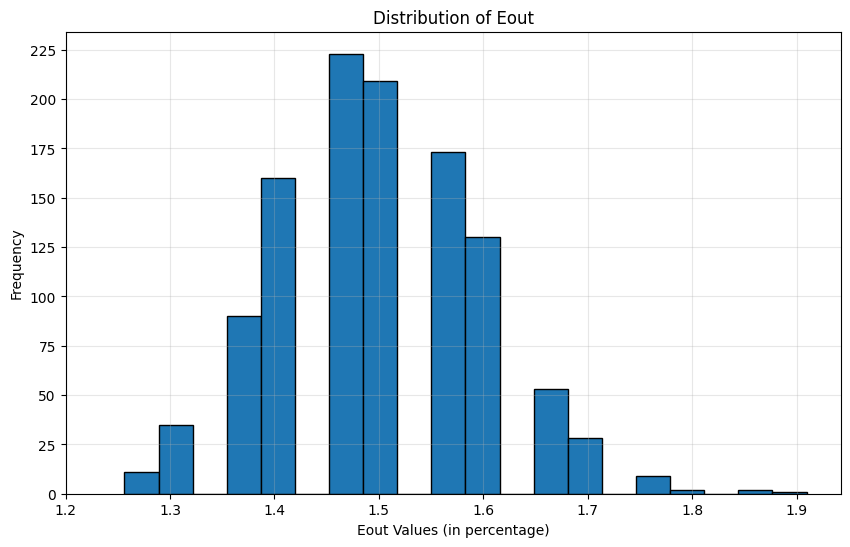

Mean Eout: 0.0150
Standard Deviation: 0.0010


In [22]:
plt.figure(figsize=(10, 6))
plt.hist([e * 100 for e in Eouts], bins=20, edgecolor='black')
plt.xlabel('Eout Values (in percentage)')
plt.ylabel('Frequency')
plt.title('Distribution of Eout')
plt.grid(True, alpha=0.3)

# Note: The values should be adjusted according to the range based on the actual results
plt.xticks(np.arange(1.2, 2.0, 0.1))

ax = plt.gca()  
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.show()

# Print the statistics in original unit so that we can compare the result with the previous question
print(f"Mean Eout: {np.mean(Eouts):.4f}")
print(f"Standard Deviation: {np.std(Eouts):.4f}")

In [24]:
print("\nStatistics for Eout:")
print(f"Mean: {np.mean(Eouts):.4f}")
print(f"Median: {np.median(Eouts):.4f}")
print(f"Standard Deviation: {np.std(Eouts):.4f}")
print(f"Min: {np.min(Eouts):.4f}")
print(f"Max: {np.max(Eouts):.4f}")


Statistics for Eout:
Mean: 0.0150
Median: 0.0151
Standard Deviation: 0.0010
Min: 0.0126
Max: 0.0191


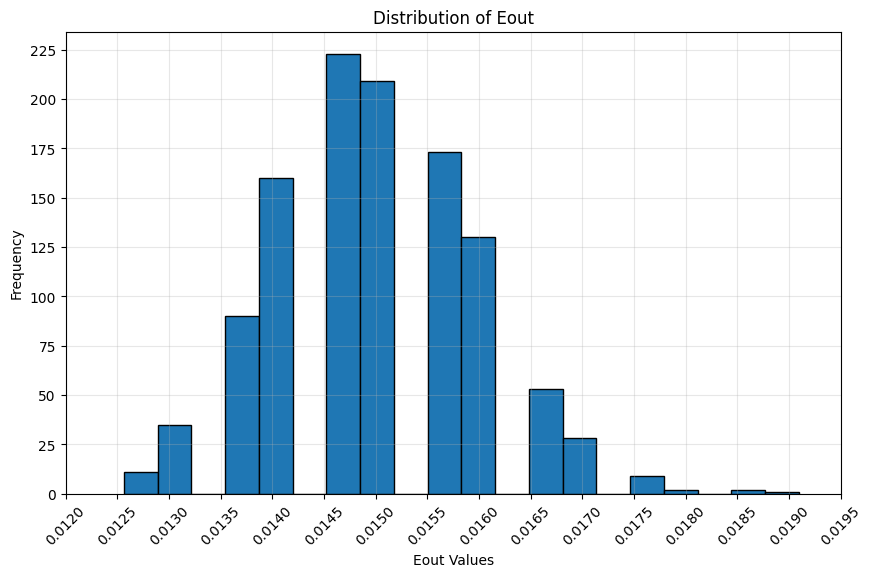

Mean Eout: 0.0150
Standard Deviation: 0.0010


In [23]:
plt.figure(figsize=(10, 6))
plt.hist(Eouts, bins=20, edgecolor='black')
plt.xlabel('Eout Values')
plt.ylabel('Frequency')
plt.title('Distribution of Eout')
plt.grid(True, alpha=0.3)

# Set x-axis ticks with smaller intervals (0.0005 intervals)
plt.xticks(np.arange(0.012, 0.020, 0.0005))
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

ax = plt.gca()  
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.show()

# Print the statistics in original unit
print(f"Mean Eout: {np.mean(Eouts):.4f}")
print(f"Standard Deviation: {np.std(Eouts):.4f}")